# INM430 - Tiny DS Project 

***

Name: Qiqi Su 

Project Title: Do London Airbnb Listing Prices affect London House Prices
***


## Appendix 

### 1. Import Relevant Packages 
### 2. Import Datasets
### 3. Data Wrangling on the Airbnb Listing Dataset
    3.1 Clean the price columns 
    3.2 Clean the time column
    3.3 Initial visualisations on the dataset
    3.4 Condense the dataset further 
    3.5 Visualisations on the condensed dataset
### 4. Data Wrangling on the UK Average House Price Dataset
    4.1 Data Wrangling
    4.2 Visualisations on the dataset
### 5. Merge Two Datasets
    5.1 Merge two datasets
    5.2 Data wrangling on the merged dataset 
    5.3 Visualisations on the merged dataset 
    5.4 Log transformation
    5.5 Robustic statistics 
    5.6 Simple correlation visualisation
    5.7 Identify and remove the outliers
### 6. Principle Component Analysis (PCA)
    6.1 Convert the columns to numpy arrays 
    6.2 PCA visualisations
      6.2.1 Compare Total_airbnb and Price_house first 
      6.2.2 Compare Price_airbnb and Price_house
### 7. Investigate the Correlations Further 
    7.1 Pair plots 
    7.2 Residual plots
    7.3 Correlation heatmap
    7.4 Pearson correlation
    7.5 Spearman correlation
    7.6 Time Series
       7.6.1 Pearson correlation time series with rolling windows 
### 8. Time Lag Cross-correlation (TLCC)
### 9. Linear Regression Models 
    9.1 Simple linear regression models (SLRM)
      9.1.1 OLS
      9.1.2 10-fold
    9.2 Multiple linear regression models (MLRM)
      9.2.1 OLS
      9.2.2 10-fold
    9.3 Multiple linear regression models on all postcode districts
***

## 1. Import Relevant Packages 

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy import spatial
from scipy import signal
from scipy import misc
import statsmodels.api as sm
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn import linear_model
from sklearn.linear_model import RANSACRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, r2_score

## 2. Import Datasets

In [2]:
#Import house dataset
house = pd.read_csv('pp-complete.csv',header=None)

#Check everything is in place
print(house.shape)
house.head()

(24852949, 16)


0      1                 2         3   \
0  {A42E2F04-2538-4A25-94C5-49E29C6C8FA8}  18500  1995-01-31 00:00   TQ1 1RY   
1  {1BA349E3-2579-40D6-999E-49E2A25D2284}  73450  1995-10-09 00:00   L26 7XJ   
2  {E5B50DCB-BC7A-4E54-B167-49E2A6B4148B}  59000  1995-03-31 00:00  BH12 2AE   
3  {81E50116-D675-4B7F-9F8D-49E2B5D43271}  31000  1995-12-04 00:00  IP13 0DR   
4  {B97455B9-75CB-40BB-A615-42C53683E143}  95000  1995-09-22 00:00  WS14 0BE   

  4  5  6                  7        8                     9          10  \
0  F  N  L     VILLA PARADISO  FLAT 10  HIGHER WARBERRY ROAD    TORQUAY   
1  D  Y  F                  6      NaN           CATKIN ROAD  LIVERPOOL   
2  D  N  F                 28      NaN            ALDER ROAD      POOLE   
3  D  Y  F    NONSUCH COTTAGE      NaN            THE STREET  HACHESTON   
4  D  N  F  FOX COVER COTTAGE      NaN             HALL LANE  LICHFIELD   

           11               12             13 14 15  
0     TORQUAY           TORBAY         TORBAY  A  A  
1   LIVERPOOL         KNOWSLEY     MERSEYSIDE  A  A  
2       POOLE            POOLE          POOLE  A  A  
3  WOODBRIDGE  SUFFOLK COASTAL        SUFFOLK  A  A  
4   LICHFIELD        LICHFIELD  STAFFORDSHIRE  A  A

In [3]:
#Import airbnb listing dataset
file   = pd.read_csv('listings.csv',dtype={'weekly_price':str,'monthly_price':str,'license':str,'jurisdiction_names':str})

#Drop irrelevant columns 
airbnb = file.loc[0:,['id', 'name','neighbourhood_cleansed', 'city', 'zipcode', 'smart_location', 'property_type',
                    'room_type', 'accommodates', 'price','weekly_price', 'monthly_price', 'security_deposit',
                    'cleaning_fee', 'extra_people','first_review','last_review']]

#Drop empty cells with no last review date as this column will be taken for the time stamp
airbnb = airbnb.dropna(subset=['last_review'])

#Check if everything is in place
print(airbnb.shape)
airbnb.head()

(62827, 17)


id                                               name  \
0  13913                Holiday London DB Room Let-on going   
1  15400                Bright Chelsea  Apartment. Chelsea!   
2  17402              Superb 3-Bed/2 Bath & Wifi: Trendy W1   
3  24328  Battersea bedroom & office w parking shared ga...   
4  25023      All-comforts 2-bed flat near Wimbledon tennis   

   neighbourhood_cleansed       city   zipcode             smart_location  \
0               Islington  Islington      N4 3  Islington, United Kingdom   
1  Kensington and Chelsea     London       SW3     London, United Kingdom   
2             Westminster     London    W1T4BP     London, United Kingdom   
3              Wandsworth     London  SW11 5GX     London, United Kingdom   
4              Wandsworth  Wimbledon  SW19 6QH  Wimbledon, United Kingdom   

  property_type        room_type  accommodates    price weekly_price  \
0     Apartment     Private room             2   $65.00      $333.00   
1     Apartment  Entire home/apt             2  $100.00      $600.00   
2     Apartment  Entire home/apt             6  $300.00    $1,378.00   
3     Townhouse  Entire home/apt             2  $175.00    $1,050.00   
4     Apartment  Entire home/apt             4   $65.00      $630.00   

  monthly_price security_deposit cleaning_fee extra_people first_review  \
0     $1,176.00          $100.00       $15.00       $15.00   2010-08-18   
1     $2,250.00          $150.00       $50.00        $0.00   2009-12-21   
2           NaN          $350.00       $65.00       $10.00   2011-03-21   
3     $3,500.00          $250.00       $70.00        $0.00   2010-11-15   
4     $2,515.00          $250.00       $50.00       $11.00   2016-03-05   

  last_review  
0  2019-06-10  
1  2019-05-05  
2  2019-06-19  
3  2019-06-08  
4  2019-06-22

## 3. Data Wrangling on the Airbnb Dataset

    3.1  Clean the price columns

In [4]:
#Change the data type
airbnb[['price','weekly_price','monthly_price','security_deposit','cleaning_fee',
        'extra_people']]= airbnb[['price','weekly_price','monthly_price','security_deposit','cleaning_fee',
                                 'extra_people']].replace('[\$,]','',regex=True).astype(float)

#Convert dollar to pound
airbnb[['price','weekly_price','monthly_price']]=airbnb[['price','weekly_price','monthly_price']]*0.78

#Find the average days of weekly and monthly price columns
weekly_avg  = (airbnb['weekly_price']/airbnb['price']).mean()
monthly_avg = (airbnb['monthly_price']/airbnb['price']).mean()

print(weekly_avg,monthly_avg)

#Fill in the missing values with the average days
airbnb['weekly_price']  = airbnb['weekly_price'].fillna(airbnb['price']*weekly_avg)
airbnb['monthly_price'] = airbnb['monthly_price'].fillna(airbnb['price']*monthly_avg)

6.52860635811319 23.365256344479633


In [5]:
#Calculate the yearly price based on the given monthly price 
Price_airbnb_original = airbnb['monthly_price']*12
airbnb.insert(17,'Price_airbnb_original',Price_airbnb_original)

#Create new columns of average 365 days a year
Price_airbnb_cal = airbnb['price']*365
airbnb.insert(18,'Price_airbnb_cal',Price_airbnb_cal)

#Create new columns of total prices which include other fees
airbnb['cleaning_fee'] = airbnb['cleaning_fee'].fillna(0)

total_airbnb_original = airbnb['Price_airbnb_original']+airbnb['cleaning_fee']*365
airbnb.insert(19,'Total_airbnb_original',total_airbnb_original)

total_airbnb_cal = airbnb['Price_airbnb_cal']+airbnb['cleaning_fee']*365
airbnb.insert(20,'Total_airbnb_cal',total_airbnb_cal)

airbnb.head()

id                                               name  \
0  13913                Holiday London DB Room Let-on going   
1  15400                Bright Chelsea  Apartment. Chelsea!   
2  17402              Superb 3-Bed/2 Bath & Wifi: Trendy W1   
3  24328  Battersea bedroom & office w parking shared ga...   
4  25023      All-comforts 2-bed flat near Wimbledon tennis   

   neighbourhood_cleansed       city   zipcode             smart_location  \
0               Islington  Islington      N4 3  Islington, United Kingdom   
1  Kensington and Chelsea     London       SW3     London, United Kingdom   
2             Westminster     London    W1T4BP     London, United Kingdom   
3              Wandsworth     London  SW11 5GX     London, United Kingdom   
4              Wandsworth  Wimbledon  SW19 6QH  Wimbledon, United Kingdom   

  property_type        room_type  accommodates  price  ...  monthly_price  \
0     Apartment     Private room             2   50.7  ...     917.280000   
1     Apartment  Entire home/apt             2   78.0  ...    1755.000000   
2     Apartment  Entire home/apt             6  234.0  ...    5467.469985   
3     Townhouse  Entire home/apt             2  136.5  ...    2730.000000   
4     Apartment  Entire home/apt             4   50.7  ...    1961.700000   

   security_deposit  cleaning_fee  extra_people  first_review last_review  \
0             100.0          15.0          15.0    2010-08-18  2019-06-10   
1             150.0          50.0           0.0    2009-12-21  2019-05-05   
2             350.0          65.0          10.0    2011-03-21  2019-06-19   
3             250.0          70.0           0.0    2010-11-15  2019-06-08   
4             250.0          50.0          11.0    2016-03-05  2019-06-22   

  Price_airbnb_original  Price_airbnb_cal  Total_airbnb_original  \
0          11007.360000           18505.5           16482.360000   
1          21060.000000           28470.0           39310.000000   
2          65609.639815           85410.0           89334.639815   
3          32760.000000           49822.5           58310.000000   
4          23540.400000           18505.5           41790.400000   

   Total_airbnb_cal  
0           23980.5  
1           46720.0  
2          109135.0  
3           75372.5  
4           36755.5  

[5 rows x 21 columns]

Calculated airbnb prices (CALP) assumes that every airbnb listings will be occupied every day of the year. Whereas Original ALP (OALP) considers the actual occupancy rate. CALP will be considered to test whether HP has a different correlation with the Airbnb hosts’ advertised price (OALP) or maximum potential income (CALP).

In [6]:
#Drop rows with no price values
null_price = airbnb.loc[airbnb['price']==0]
null_price['neighbourhood_cleansed'].value_counts()

Tower Hamlets     4
Southwark         4
Westminster       2
Hackney           1
Ealing            1
Lambeth           1
Newham            1
Waltham Forest    1
Name: neighbourhood_cleansed, dtype: int64

In [7]:
#There are only 15 rows with missing price values, these will be dropped
airbnb = airbnb[airbnb['price']!= 0]

In [8]:
airbnb.shape

(62812, 21)

    3.2 Clean the date columns

In [9]:
#Change the format of date
airbnb['first_review'] = pd.to_datetime(airbnb['first_review'],format='%Y-%m-%d')
#airbnb['first_review'] = pd.to_datetime(airbnb['first_review'])

airbnb['last_review']  = pd.to_datetime(airbnb['last_review'],format='%Y-%m-%d')
#airbnb['last_review']  = pd.to_datetime(airbnb['last_review'])

#Sort the dates from the oldest to newest
airbnb = airbnb.sort_values(by=['last_review'],ascending=[True])
airbnb.head()

id                                               name  \
26    41870                      Room in relaxed family house!   
259  241133                     Double bedroom in North London   
154  109299  Trendy Dalston 2BR/2BA En-Suite/Balcony/Gym/Train   
596  388306                                Garden flat, Putney   
387  306405                Spacious Double Room in East London   

    neighbourhood_cleansed         city   zipcode  \
26          Waltham Forest  Walthamstow     E11 4   
259                 Barnet       Barnet     N10 1   
154                Hackney      Hackney      E8 3   
596             Wandsworth       Putney  SW15 6AW   
387   Barking and Dagenham     Dagenham  RM10 8SN   

                  smart_location property_type        room_type  accommodates  \
26   Walthamstow, United Kingdom         House     Private room             2   
259       Barnet, United Kingdom         House     Private room             2   
154      Hackney, United Kingdom     Apartment  Entire home/apt             4   
596       Putney, United Kingdom     Apartment     Private room             1   
387     Dagenham, United Kingdom     Apartment     Private room             1   

     price  ...  monthly_price  security_deposit  cleaning_fee  extra_people  \
26   27.30  ...     599.820000               0.0           0.0          10.0   
259  35.10  ...     712.140000             200.0           0.0           0.0   
154  97.50  ...    1173.900000             300.0          30.0          10.0   
596  19.50  ...     390.000000               NaN           0.0           0.0   
387  31.98  ...     747.220898              80.0          10.0           0.0   

     first_review last_review Price_airbnb_original  Price_airbnb_cal  \
26     2011-06-26  2011-07-02           7197.840000            9964.5   
259    2011-10-21  2011-10-21           8545.680000           12811.5   
154    2011-08-01  2011-11-22          14086.800000           35587.5   
596    2012-03-26  2012-03-26           4680.000000            7117.5   
387    2012-02-21  2012-05-27           8966.650775           11672.7   

     Total_airbnb_original  Total_airbnb_cal  
26             7197.840000            9964.5  
259            8545.680000           12811.5  
154           25036.800000           46537.5  
596            4680.000000            7117.5  
387           12616.650775           15322.7  

[5 rows x 21 columns]

    3.3 Initial visualisations on the dataset        

In [10]:
#Set 'last_review' as the index for the airbnb dataset to allow temporal analysis   
airbnb.set_index(airbnb['last_review'],inplace=True)

In [11]:
# Inspect the temporal distribution by year
yearly_count = airbnb.resample('Y').count()[['last_review']]

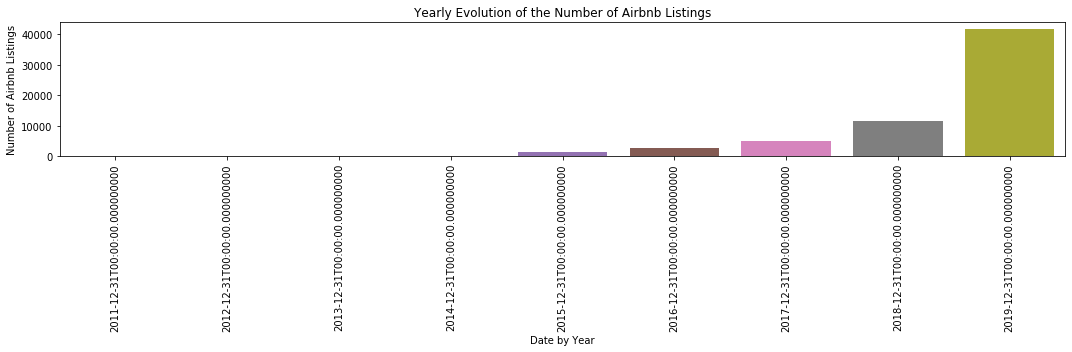

In [12]:
# Visualize the evolution
plt.figure(figsize = (15, 5))
sns.barplot(yearly_count.index, yearly_count.values.flatten())
plt.xlabel('Date by Year')
plt.ylabel('Number of Airbnb Listings')
plt.title('Yearly Evolution of the Number of Airbnb Listings')
plt.xticks(rotation=90)
plt.tight_layout()

From the barplot we can see that Airbnb started to gain a significant amount of listings in London from 2015, and increased dramatically from less than 5,000 in 2015 to more than 40,000 in 2019. 

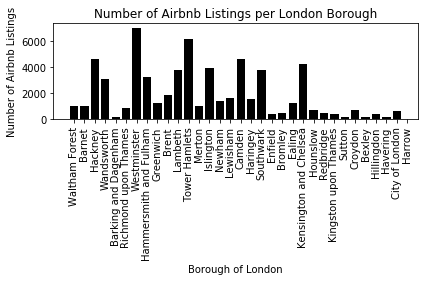

In [13]:
plt.hist(airbnb['neighbourhood_cleansed'],bins=32,rwidth=0.8,color='black',align='left')
plt.title('Number of Airbnb Listings per London Borough')
plt.xlabel('Borough of London')
plt.ylabel('Number of Airbnb Listings')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

The Lonodn borough with the most airbnb listings are Westminster, with 7,039 listings. Following by Tower Hamlets, with 6,171 listings. The borough with the least airbnb listing is Havering with 151 listings.

In [14]:
airbnb['neighbourhood_cleansed'].value_counts()

Westminster               7039
Tower Hamlets             6167
Hackney                   4676
Camden                    4670
Kensington and Chelsea    4258
Islington                 3967
Lambeth                   3829
Southwark                 3820
Hammersmith and Fulham    3237
Wandsworth                3143
Brent                     1870
Lewisham                  1683
Haringey                  1561
Newham                    1390
Ealing                    1239
Greenwich                 1234
Barnet                    1063
Waltham Forest            1028
Merton                    1005
Richmond upon Thames       881
Croydon                    753
Hounslow                   724
Bromley                    467
Redbridge                  466
Hillingdon                 431
Enfield                    415
Kingston upon Thames       398
Harrow                     340
City of London             329
Barking and Dagenham       221
Sutton                     205
Bexley                     152
Havering

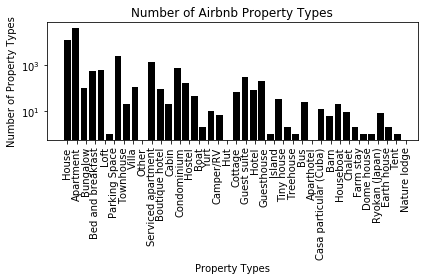

In [15]:
plt.hist(airbnb['property_type'],bins=40,rwidth=0.8,color='black',log=True,align='left')
plt.xlabel('Property Types')
plt.ylabel('Number of Property Types')
plt.title('Number of Airbnb Property Types')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

The majority property type in London is Apartment with 43,425 listings. Following by House with 12,101 listings.

In [16]:
airbnb['property_type'].value_counts()

Apartment                 43425
House                     12101
Townhouse                  2500
Serviced apartment         1425
Condominium                 792
Loft                        605
Bed and breakfast           594
Guest suite                 296
Guesthouse                  213
Hostel                      165
Other                       118
Bungalow                    100
Boutique hotel               92
Hotel                        84
Cottage                      68
Boat                         45
Tiny house                   34
Aparthotel                   26
Houseboat                    21
Villa                        21
Cabin                        21
Casa particular (Cuba)       12
Camper/RV                    10
Chalet                        9
Earth house                   8
Hut                           7
Barn                          6
Farm stay                     2
Treehouse                     2
Tent                          2
Yurt                          2
Parking 

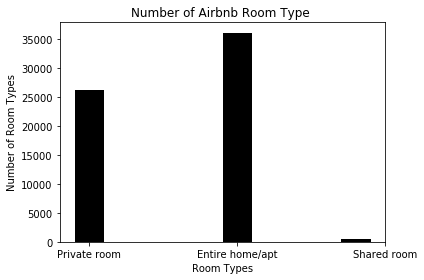

In [17]:
plt.hist(airbnb['room_type'],color='black',align='left')
plt.title('Number of Airbnb Room Type ')
plt.xlabel('Room Types')
plt.ylabel('Number of Room Types')
plt.tight_layout()
plt.show()

The majority of the room type in London is 'Entire home/apt' with 36,146 Listings.

In [18]:
airbnb['room_type'].value_counts()

Entire home/apt    36146
Private room       26199
Shared room          467
Name: room_type, dtype: int64

    3.4 Condense the dataset further

In [18]:
#Creat a new file to avoid overlapping
airbnb1 = airbnb

#Extract the year and month from the date column
airbnb1['YearMonth'] = airbnb1['last_review'].map(lambda x: 100*x.year + x.month)

#Extract the first part (postcode districts) from Postcodes 
airbnb1['Postcode'] = airbnb1['zipcode'].str[0:3]

#Group the postcode and year columns and reset idex
airbnb1 = airbnb1.groupby(['YearMonth','Postcode']).mean().reset_index()

#Drop further irrelevant columns
airbnb1 = airbnb1.drop(columns=['id','accommodates','weekly_price','monthly_price','security_deposit','cleaning_fee','extra_people'])

#Rearrange the columns
airbnb1 = airbnb1[['Price_airbnb_original','Price_airbnb_cal','Total_airbnb_original','Total_airbnb_cal','Postcode','YearMonth']]

print(airbnb1.shape)
airbnb1.head()

(6218, 6)


Price_airbnb_original  Price_airbnb_cal  Total_airbnb_original  \
0            7197.840000            9964.5            7197.840000   
1            8545.680000           12811.5            8545.680000   
2           14086.800000           35587.5           25036.800000   
3            4680.000000            7117.5            4680.000000   
4            8966.650775           11672.7           12616.650775   

   Total_airbnb_cal Postcode  YearMonth  
0            9964.5      E11     201107  
1           12811.5      N10     201110  
2           46537.5      E8      201111  
3            7117.5      SW1     201203  
4           15322.7      RM1     201205

In [19]:
#Remove special characters and symbols in the Postcode column 
def preprocess(Postcode):
    Postcode = Postcode.str.upper()
    Postcode = Postcode.dropna()
    Postcode = Postcode.str.replace('[','')
    Postcode = Postcode.str.replace('€','')
    Postcode = Postcode.str.replace('.','')
    Postcode = Postcode.str.replace('$', '')
    return(Postcode)

In [20]:
#Extract the first part (postcode district) from postcodes
airbnb1['Postcode'] = preprocess(airbnb1['Postcode'])

airbnb1 = airbnb1[~airbnb1['Postcode'].astype(str).str.startswith('1')]
airbnb1 = airbnb1[~airbnb1['Postcode'].astype(str).str.startswith('3')]  

#Spliting the Postcode areas into East, West, North, North Weset, South East, South West, Central and Outer
East_airbnb = airbnb1[airbnb1['Postcode'].str[0]=='E']
East_airbnb = East_airbnb[East_airbnb['Postcode'].str[1]!='C']
East_airbnb = East_airbnb[East_airbnb['Postcode'].str[1]!='N']

if East_airbnb['Postcode'].all()<='E18':
    East_airbnb['Postcode'] = East_airbnb['Postcode']
else: 
    East_airbnb['Postcode'] = East_airbnb['Postcode'].str[0:2]

East_airbnb.reset_index()
    
West_airbnb   = airbnb1[airbnb1['Postcode'].str[0]=='W']
West_airbnb   = West_airbnb[West_airbnb['Postcode'].str[1]!='C']

if West_airbnb['Postcode'].all()<='W13':
    West_airbnb['Postcode'] = West_airbnb['Postcode']
else: 
    West_airbnb['Postcode'] = West_airbnb['Postcode'].str[0:2]

West_airbnb.reset_index()

North_airbnb = airbnb1[airbnb1['Postcode'].str[0]=='N']
North_West_airbnb = North_airbnb[North_airbnb['Postcode'].str[1]=='W']
North_airbnb = North_airbnb[North_airbnb['Postcode'].str[1]!='W']

if North_airbnb['Postcode'].all()<='N22':
    North_airbnb['Postcode'] = North_airbnb['Postcode']
else: 
    North_airbnb['Postcode'] = North_airbnb['Postcode'].str[0:2]

North_airbnb.reset_index()
North_West_airbnb.reset_index()

South_airbnb = airbnb1[airbnb1['Postcode'].str[0]=='S']    
South_East_airbnb = South_airbnb[South_airbnb['Postcode'].str[1]=='E']
South_West_airbnb = South_airbnb[South_airbnb['Postcode'].str[1]=='W']

South_East_airbnb.reset_index()
South_West_airbnb.reset_index()
       
Central_airbnb = airbnb1[airbnb1['Postcode'].str[1]=='C']

Central_airbnb.reset_index()

IG = airbnb1[airbnb1['Postcode'].str[0]=='I']
RM = airbnb1[airbnb1['Postcode'].str[0]=='R']
EN = airbnb1[airbnb1['Postcode'].str[1]=='N']
DA = airbnb1[airbnb1['Postcode'].str[0]=='D']
BR = airbnb1[airbnb1['Postcode'].str[0]=='B']
CR = airbnb1[airbnb1['Postcode'].str[0]=='C']
SM = airbnb1[airbnb1['Postcode'].str[1]=='M']
KT = airbnb1[airbnb1['Postcode'].str[0]=='K']
TW = airbnb1[airbnb1['Postcode'].str[0]=='T']
UB = airbnb1[airbnb1['Postcode'].str[0]=='U']
HA = airbnb1[airbnb1['Postcode'].str[0]=='H']
WD = airbnb1[airbnb1['Postcode'].str[1]=='D']

Outer_airbnb = pd.concat([IG,RM,EN,DA,BR,CR,SM,KT,TW,UB,HA,WD]).reset_index()

    3.5 Visualisations on the condensed dataset

Text(0, 0.5, 'Number of Airbnb Listings')

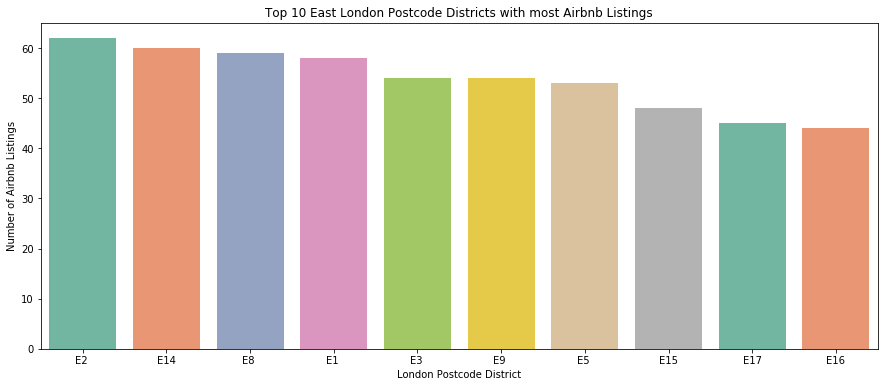

In [21]:
East_count = East_airbnb['Postcode'].value_counts()
East_count = East_count[:10,]
plt.figure(figsize=(15,6))
sns.barplot(East_count.index,East_count.values,palette='Set2')
plt.title('Top 10 East London Postcode Districts with most Airbnb Listings')
plt.xlabel('London Postcode District')
plt.ylabel('Number of Airbnb Listings')

Text(0, 0.5, 'Number of Airbnb Listings')

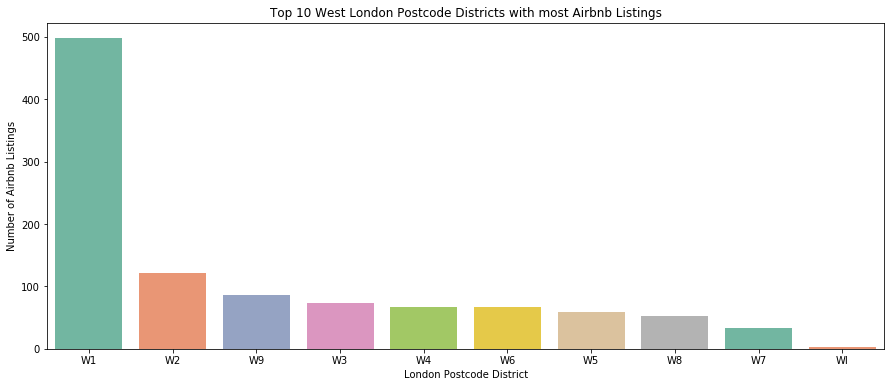

In [22]:
West_count = West_airbnb['Postcode'].value_counts()
West_count = West_count[:10,]
plt.figure(figsize=(15,6))
sns.barplot(West_count.index,West_count.values,palette='Set2')
plt.title('Top 10 West London Postcode Districts with most Airbnb Listings')
plt.xlabel('London Postcode District')
plt.ylabel('Number of Airbnb Listings')

Text(0, 0.5, 'Number of Airbnb Listings')

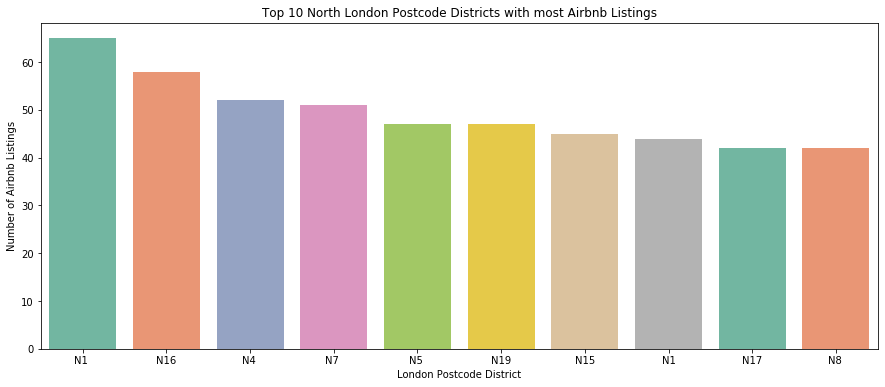

In [23]:
North_count = North_airbnb['Postcode'].value_counts()
North_count = North_count[:10,]
plt.figure(figsize=(15,6))
sns.barplot(North_count.index,North_count.values,palette='Set2')
plt.title('Top 10 North London Postcode Districts with most Airbnb Listings')
plt.xlabel('London Postcode District')
plt.ylabel('Number of Airbnb Listings')

Text(0, 0.5, 'Number of Airbnb Listings')

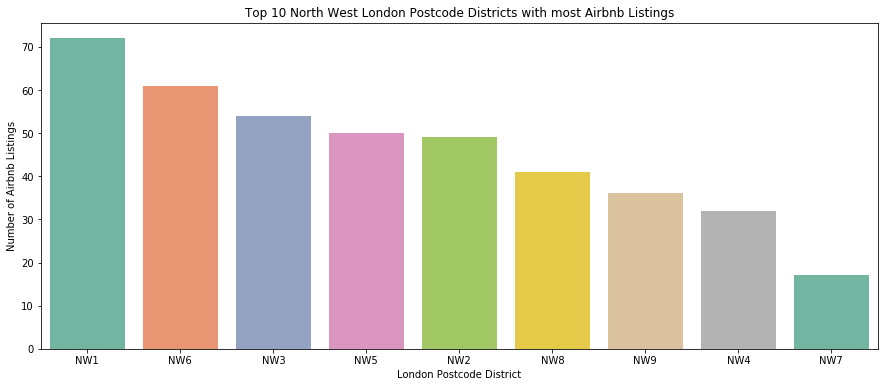

In [24]:
NW_count = North_West_airbnb['Postcode'].value_counts()
NW_count = NW_count[:10,]
plt.figure(figsize=(15,6))
sns.barplot(NW_count.index,NW_count.values,palette='Set2')
plt.title('Top 10 North West London Postcode Districts with most Airbnb Listings')
plt.xlabel('London Postcode District')
plt.ylabel('Number of Airbnb Listings')

Text(0, 0.5, 'Number of Airbnb Listings')

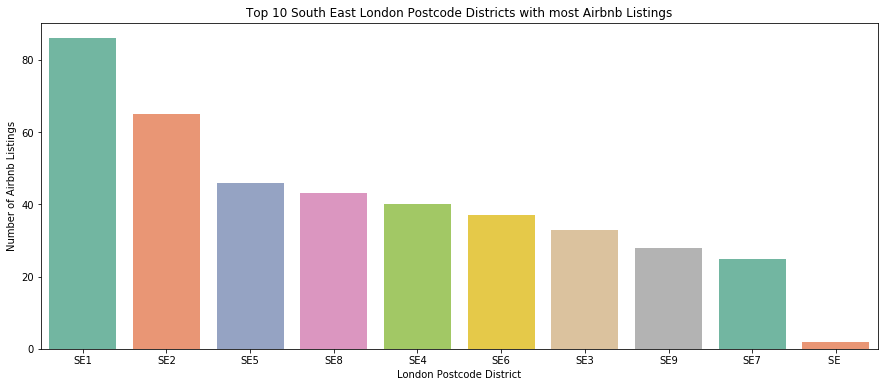

In [25]:
SE_count = South_East_airbnb['Postcode'].value_counts()
SE_count = SE_count[:10,]
plt.figure(figsize=(15,6))
sns.barplot(SE_count.index,SE_count.values,palette='Set2')
plt.title('Top 10 South East London Postcode Districts with most Airbnb Listings')
plt.xlabel('London Postcode District')
plt.ylabel('Number of Airbnb Listings')

Text(0, 0.5, 'Number of Airbnb Listings')

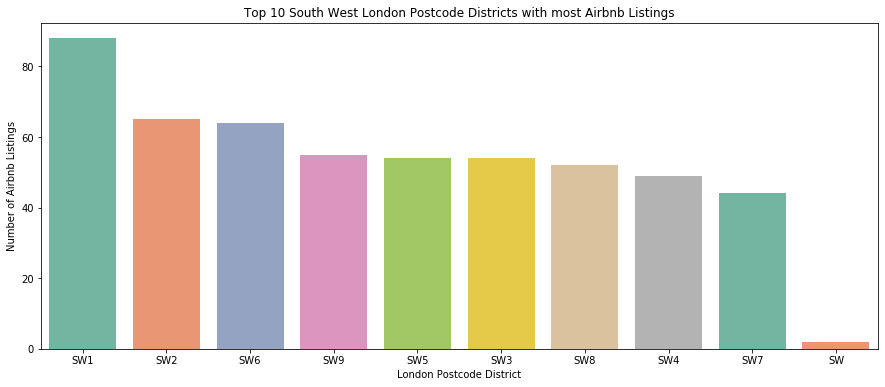

In [26]:
SW_count = South_West_airbnb['Postcode'].value_counts()
SW_count = SW_count[:10,]
plt.figure(figsize=(15,6))
sns.barplot(SW_count.index,SW_count.values,palette='Set2')
plt.title('Top 10 South West London Postcode Districts with most Airbnb Listings')
plt.xlabel('London Postcode District')
plt.ylabel('Number of Airbnb Listings')

Text(0, 0.5, 'Number of Airbnb Listings')

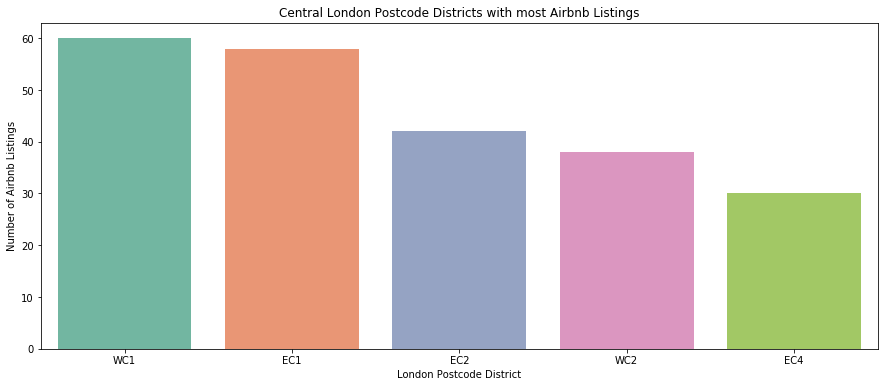

In [27]:
Central_count = Central_airbnb['Postcode'].value_counts()
Central_count = Central_count[:5,]
plt.figure(figsize=(15,6))
sns.barplot(Central_count.index,Central_count.values,palette='Set2')
plt.title('Central London Postcode Districts with most Airbnb Listings')
plt.xlabel('London Postcode District')
plt.ylabel('Number of Airbnb Listings')

Text(0, 0.5, 'Number of Airbnb Listings')

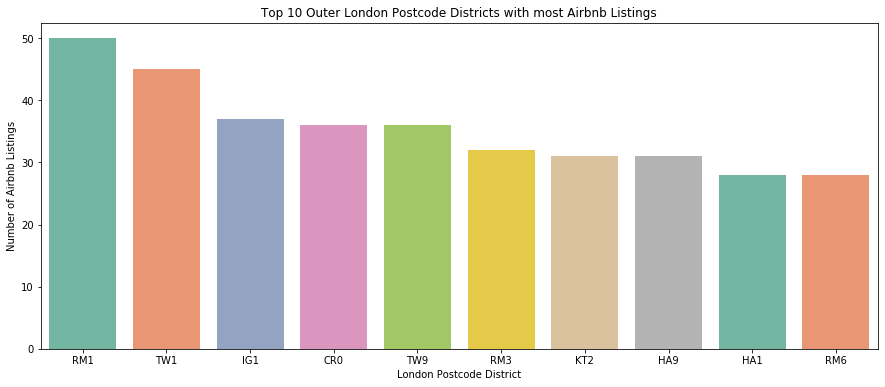

In [28]:
Outer_count = Outer_airbnb['Postcode'].value_counts()
Outer_count = Outer_count[:10,]
plt.figure(figsize=(15,6))
sns.barplot(Outer_count.index,Outer_count.values,palette='Set2')
plt.title('Top 10 Outer London Postcode Districts with most Airbnb Listings')
plt.xlabel('London Postcode District')
plt.ylabel('Number of Airbnb Listings')

# 4. Data Wrangling on the UK Average House Price Dataset

    4.1 Data Wrangling

In [29]:
#Drop irrelevant columns
house.columns=['ID','Price_house','Time','Postcode','a','b','c','First','Number','Street','Locality','City','Area','County','A','A1']
house = house.drop(columns={'ID','a','b','c','First','Number','Street','Locality','A','A1'})
print(house.shape)
house.head()

(24852949, 6)


Price_house              Time  Postcode        City             Area  \
0        18500  1995-01-31 00:00   TQ1 1RY     TORQUAY           TORBAY   
1        73450  1995-10-09 00:00   L26 7XJ   LIVERPOOL         KNOWSLEY   
2        59000  1995-03-31 00:00  BH12 2AE       POOLE            POOLE   
3        31000  1995-12-04 00:00  IP13 0DR  WOODBRIDGE  SUFFOLK COASTAL   
4        95000  1995-09-22 00:00  WS14 0BE   LICHFIELD        LICHFIELD   

          County  
0         TORBAY  
1     MERSEYSIDE  
2          POOLE  
3        SUFFOLK  
4  STAFFORDSHIRE

In [30]:
#Filter the dataset to London only
house = house.loc[house['County']=='GREATER LONDON']
house = house.loc[house['City']=='LONDON']

#Change the date format
Clean_Time = pd.to_datetime(house['Time'],format='%Y-%m-%d %H:%M')
house.insert(1,'Clean_Time',Clean_Time)

In [31]:
#Create another dataframe to avoid overlapping
house1 = house

#Extract the year and month from date column
house1['YearMonth'] = house1['Clean_Time'].map(lambda x: 100*x.year + x.month)

#Extracting postcode districts 
house1['Postcode'] = house1['Postcode'].str[0:3]

#Group the dataset by YearMonth and Postcode
house1 = house1.groupby(['YearMonth','Postcode']).mean().reset_index()

#Rearranging the columns
house1 = house1[['YearMonth','Postcode','Price_house']]

print(house1.shape)
house1.head()

(29050, 3)


YearMonth Postcode   Price_house
0     199501      E1   87606.956522
1     199501      E10  51049.833333
2     199501      E11  75225.952381
3     199501      E12  51885.000000
4     199501      E13  48591.600000

In [32]:
#Extract the postocde ditricts from postcode
house1['Postcode'] = preprocess(house1['Postcode'])

#Spliting the Postcode areas into East, West, North, North Weset, South East, South West, Central 
#and Outer
East_house = house1[house1['Postcode'].str[0]=='E']
East_house = East_house[East_house['Postcode'].str[1]!='C']
East_house = East_house[East_house['Postcode'].str[1]!='N']

if East_house['Postcode'].all()<='E18':
    East_house['Postcode'] = East_house['Postcode']
else: 
    East_house['Postcode'] = East_house['Postcode'].str[0:2]

East_house.reset_index()
    
West_house = house1[house1['Postcode'].str[0]=='W']
West_house = West_house[West_house['Postcode'].str[1]!='C']

if West_house['Postcode'].all()<='W13':
    West_house['Postcode'] = West_house['Postcode']
else: 
    West_house['Postcode'] = West_house['Postcode'].str[0:2]

West_house.reset_index()

North_house = house1[house1['Postcode'].str[0]=='N']
North_West_house = North_house[North_house['Postcode'].str[1]=='W']
North_house = North_house[North_house['Postcode'].str[1]!='W']

if North_house['Postcode'].all()<='N22':
    North_house['Postcode'] = North_house['Postcode']
else: 
    North_house['Postcode'] = North_house['Postcode'].str[0:2]

North_house.reset_index()
North_West_house.reset_index()

South_house = house1[house1['Postcode'].str[0]=='S']   

South_East_house = South_house[South_house['Postcode'].str[1]=='E']
South_West_house = South_house[South_house['Postcode'].str[1]=='W']

South_East_house.reset_index()
South_West_house.reset_index()
       
Central_house = house1[house1['Postcode'].str[1]=='C']

Central_house.reset_index()

IG = house1[house1['Postcode'].str[0]=='I']
RM = house1[house1['Postcode'].str[0]=='R']
EN = house1[house1['Postcode'].str[1]=='N']
DA = house1[house1['Postcode'].str[0]=='D']
BR = house1[house1['Postcode'].str[0]=='B']
CR = house1[house1['Postcode'].str[0]=='C']
SM = house1[house1['Postcode'].str[1]=='M']
KT = house1[house1['Postcode'].str[0]=='K']
TW = house1[house1['Postcode'].str[0]=='T']
UB = house1[house1['Postcode'].str[0]=='U']
HA = house1[house1['Postcode'].str[0]=='H']
WD = house1[house1['Postcode'].str[1]=='D']

Outer_house = pd.concat([IG,RM,EN,DA,BR,CR,SM,KT,TW,UB,HA,WD]).reset_index()

    4.2 Visualisations on the dataset

In [33]:
#Set 'YearMonth' as the index for the airbnb dataset to allow temporal analysis   
house.set_index(house['Clean_Time'],inplace=True)

In [34]:
# Inspect the temporal distribution by year
yearly_count1 = house.resample('Y').count()[['Clean_Time']]

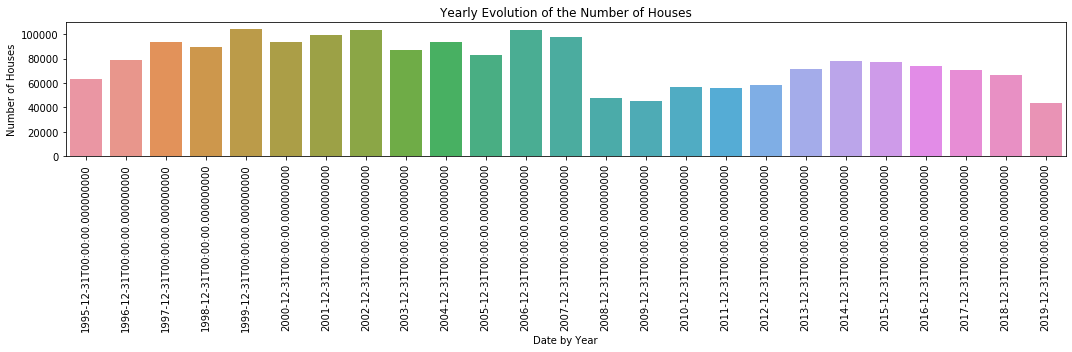

In [35]:
# Visualize the evolution
plt.figure(figsize = (15, 5))
sns.barplot(yearly_count1.index, yearly_count1.values.flatten())
plt.xlabel('Date by Year')
plt.ylabel('Number of Houses')
plt.title('Yearly Evolution of the Number of Houses')
plt.xticks(rotation=90)
plt.tight_layout()

The graph showed that there is a siginificant dip in house sales in 2008, which is when the finicial crisis happened. 

Text(0, 0.5, 'Number of Houses')

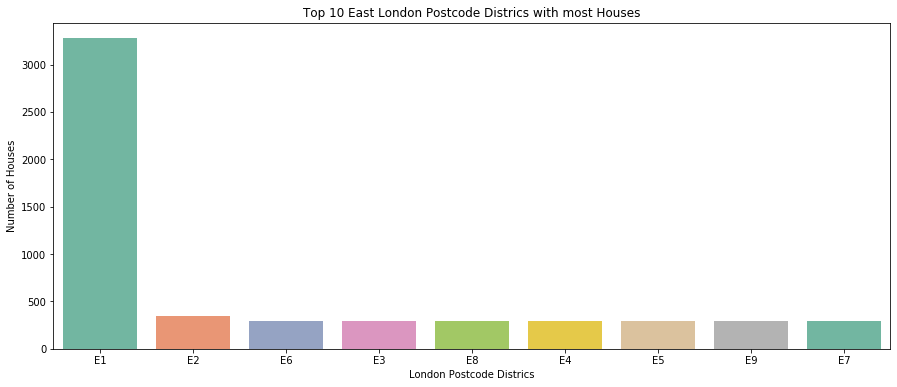

In [36]:
East_count_house = East_house['Postcode'].value_counts()
East_count_house = East_count_house[:10,]
plt.figure(figsize=(15,6))
sns.barplot(East_count_house.index,East_count_house.values,palette='Set2')
plt.title('Top 10 East London Postcode Districs with most Houses')
plt.xlabel('London Postcode Districs')
plt.ylabel('Number of Houses')

Text(0, 0.5, 'Number of Houses')

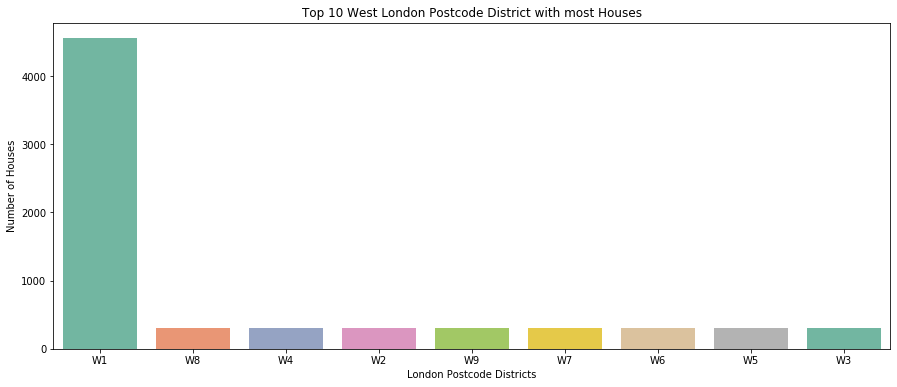

In [37]:
West_count_house = West_house['Postcode'].value_counts()
West_count_house = West_count_house[:10,]
plt.figure(figsize=(15,6))
sns.barplot(West_count_house.index,West_count_house.values,palette='Set2')
plt.title('Top 10 West London Postcode District with most Houses')
plt.xlabel('London Postcode Districts')
plt.ylabel('Number of Houses')

Text(0, 0.5, 'Number of Houses')

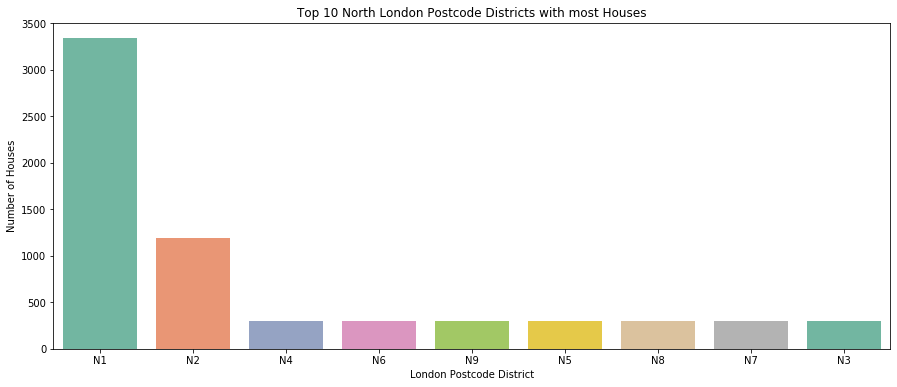

In [38]:
North_count_house = North_house['Postcode'].value_counts()
North_count_house = North_count_house[:10,]
plt.figure(figsize=(15,6))
sns.barplot(North_count_house.index,North_count_house.values,palette='Set2')
plt.title('Top 10 North London Postcode Districts with most Houses')
plt.xlabel('London Postcode District')
plt.ylabel('Number of Houses')

Text(0, 0.5, 'Number of Houses')

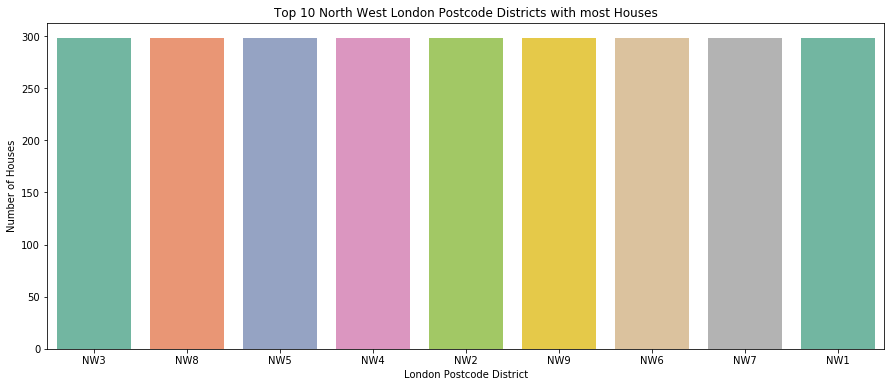

In [39]:
NW_count_house = North_West_house['Postcode'].value_counts()
NW_count_house = NW_count_house[:10,]
plt.figure(figsize=(15,6))
sns.barplot(NW_count_house.index,NW_count_house.values,palette='Set2')
plt.title('Top 10 North West London Postcode Districts with most Houses')
plt.xlabel('London Postcode District')
plt.ylabel('Number of Houses')

Text(0, 0.5, 'Number of Houses')

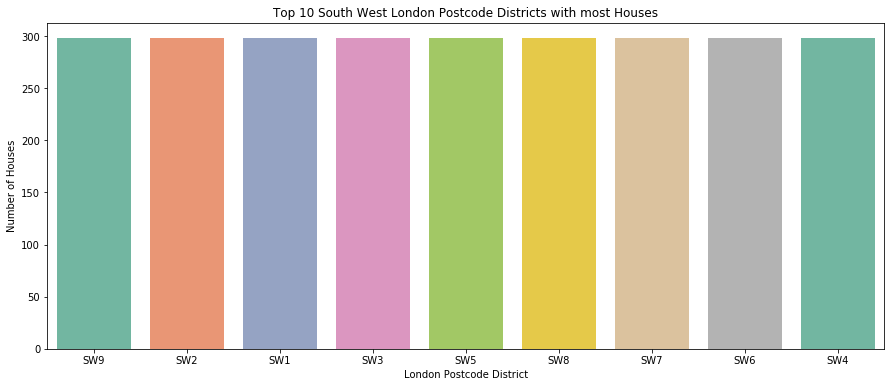

In [40]:
SW_count_house = South_West_house['Postcode'].value_counts()
SW_count_house = SW_count_house[:10,]
plt.figure(figsize=(15,6))
sns.barplot(SW_count_house.index,SW_count_house.values,palette='Set2')
plt.title('Top 10 South West London Postcode Districts with most Houses')
plt.xlabel('London Postcode District')
plt.ylabel('Number of Houses')

Text(0, 0.5, 'Number of Houses')

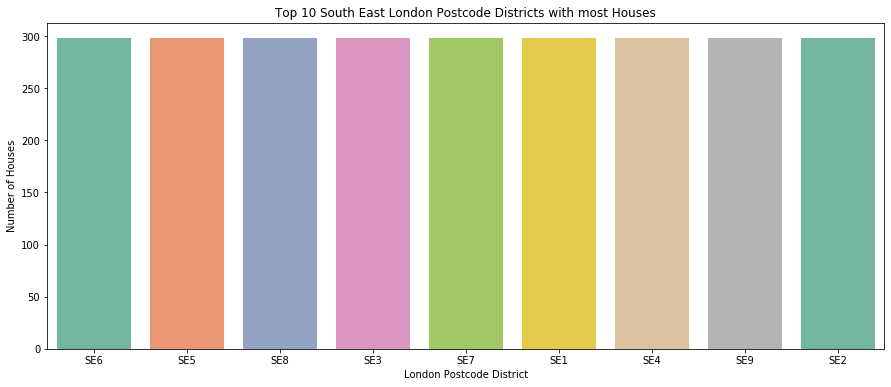

In [41]:
SE_count_house = South_East_house['Postcode'].value_counts()
SE_count_house = SE_count_house[:10,]
plt.figure(figsize=(15,6))
sns.barplot(SE_count_house.index,SE_count_house.values,palette='Set2')
plt.title('Top 10 South East London Postcode Districts with most Houses')
plt.xlabel('London Postcode District')
plt.ylabel('Number of Houses')

All the postcode districts in north west,south west and south east london had equal amount of houses sold. This is stange and could be caused by errors when the postcode districts were extracted.

Text(0, 0.5, 'Number of Houses')

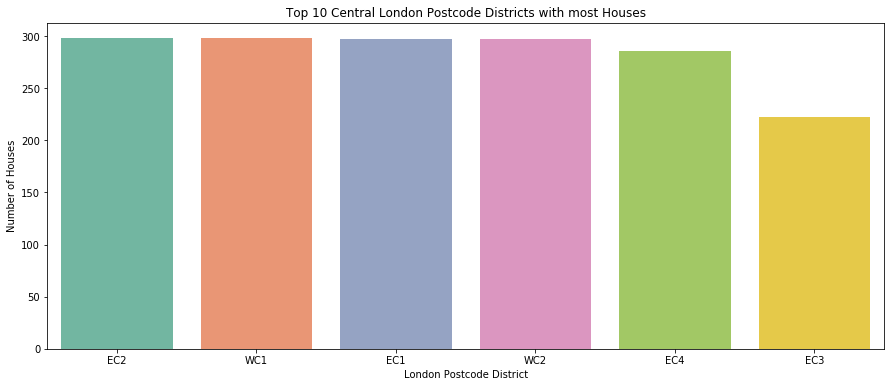

In [42]:
Central_count_house = Central_house['Postcode'].value_counts()
Central_count_house = Central_count_house[:10,]
plt.figure(figsize=(15,6))
sns.barplot(Central_count_house.index,Central_count_house.values,palette='Set2')
plt.title('Top 10 Central London Postcode Districts with most Houses')
plt.xlabel('London Postcode District')
plt.ylabel('Number of Houses')

Text(0, 0.5, 'Number of Houses')

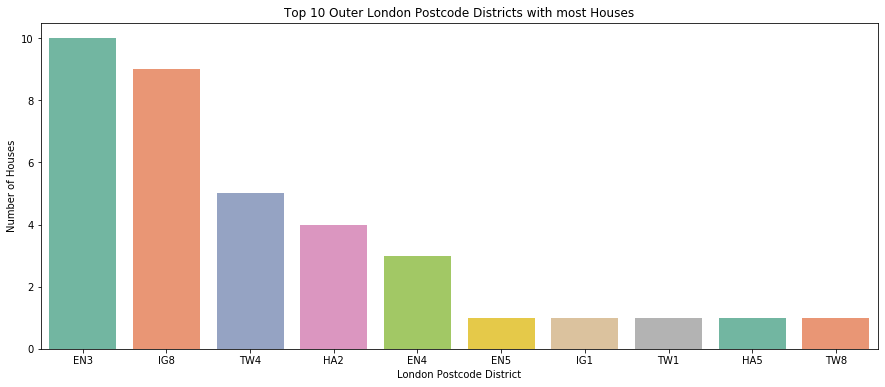

In [43]:
Outer_count_house = Outer_house['Postcode'].value_counts()
Outer_count_house = Outer_count_house[:10,]
plt.figure(figsize=(15,6))
sns.barplot(Outer_count_house.index,Outer_count_house.values,palette='Set2')
plt.title('Top 10 Outer London Postcode Districts with most Houses')
plt.xlabel('London Postcode District')
plt.ylabel('Number of Houses')

# 5. Merge Two Datasets

    5.1 Merge two datasets

In [44]:
#Merge two datasets on Year and Postcode 
merged = pd.merge(house1,airbnb1,how='outer',on=['YearMonth','Postcode'])

#Sort both columns 
merged = merged.sort_values(by=['Postcode','YearMonth'],ascending=[True,True]).reset_index()

#Rearrange columns
merged = merged[['YearMonth','Postcode','Price_house','Price_airbnb_original','Price_airbnb_cal','Total_airbnb_original','Total_airbnb_cal']]

merged

YearMonth Postcode  Price_house  Price_airbnb_original  \
0         201907                   NaN            7654.457978   
1         201510      BR1          NaN            4680.000000   
2         201601      BR1          NaN           37440.000000   
3         201605      BR1          NaN           10934.939969   
4         201608      BR1          NaN            5467.469985   
...          ...      ...          ...                    ...   
31478     201910      WC2   21950000.0                    NaN   
31479     201810      WIJ          NaN           93165.688538   
31480     201906      WIJ          NaN          160306.219949   
31481     201906      WIW          NaN           54674.699846   
31482     201704      • E          NaN           61235.663828   

       Price_airbnb_cal  Total_airbnb_original  Total_airbnb_cal  
0                9964.5            7654.457978            9964.5  
1                7117.5           10155.000000           12592.5  
2               25623.0           55690.000000           43873.0  
3               14235.0           15314.939969           18615.0  
4                7117.5            9117.469985           10767.5  
...                 ...                    ...               ...  
31478               NaN                    NaN               NaN  
31479          121282.2           93165.688538          121282.2  
31480          208685.1          160306.219949          208685.1  
31481           71175.0           85699.699846          102200.0  
31482           79716.0           61235.663828           79716.0  

[31483 rows x 7 columns]

    5.2 Data wrangling on the merged dataset 

In [45]:
#Set YearMonth as the datetime index of the merged dataset 
datetime_series = pd.to_datetime(merged['YearMonth'].astype(str), format='%Y%m')
datetime_index = pd.DatetimeIndex(datetime_series.values)
merged1 = merged.set_index(datetime_index)
merged1 = merged1.drop('YearMonth',axis=1)
merged1

Postcode  Price_house  Price_airbnb_original  Price_airbnb_cal  \
2019-07-01                   NaN            7654.457978            9964.5   
2015-10-01      BR1          NaN            4680.000000            7117.5   
2016-01-01      BR1          NaN           37440.000000           25623.0   
2016-05-01      BR1          NaN           10934.939969           14235.0   
2016-08-01      BR1          NaN            5467.469985            7117.5   
...             ...          ...                    ...               ...   
2019-10-01      WC2   21950000.0                    NaN               NaN   
2018-10-01      WIJ          NaN           93165.688538          121282.2   
2019-06-01      WIJ          NaN          160306.219949          208685.1   
2019-06-01      WIW          NaN           54674.699846           71175.0   
2017-04-01      • E          NaN           61235.663828           79716.0   

            Total_airbnb_original  Total_airbnb_cal  
2019-07-01            7654.457978            9964.5  
2015-10-01           10155.000000           12592.5  
2016-01-01           55690.000000           43873.0  
2016-05-01           15314.939969           18615.0  
2016-08-01            9117.469985           10767.5  
...                           ...               ...  
2019-10-01                    NaN               NaN  
2018-10-01           93165.688538          121282.2  
2019-06-01          160306.219949          208685.1  
2019-06-01           85699.699846          102200.0  
2017-04-01           61235.663828           79716.0  

[31483 rows x 6 columns]

In [46]:
#Drop missing rows with both house prices and airbnb prices
merged1 = merged1.dropna()

#Sort the index from oldest to newest
merged1 = merged1.sort_index()

merged1

Postcode   Price_house  Price_airbnb_original  Price_airbnb_cal  \
2011-07-01      E11  2.904545e+05            7197.840000       9964.500000   
2011-10-01      N10  5.269625e+05            8545.680000      12811.500000   
2011-11-01      E8   3.459664e+05           14086.800000      35587.500000   
2012-03-01      SW1  6.026462e+05            4680.000000       7117.500000   
2012-07-01      W14  7.358192e+05            9360.000000       9964.500000   
...             ...           ...                    ...               ...   
2019-07-01      SE6  4.661586e+05           10505.476326      13728.866667   
2019-07-01      EC3  8.322470e+05           37512.097311      47117.850000   
2019-07-01      SE7  4.765455e+05           10570.441970      13760.500000   
2019-07-01      NW9  4.841728e+05           15902.526984      20701.757143   
2019-07-01      WC2  5.747231e+06           12684.530364      16512.600000   

            Total_airbnb_original  Total_airbnb_cal  
2011-07-01            7197.840000       9964.500000  
2011-10-01            8545.680000      12811.500000  
2011-11-01           25036.800000      46537.500000  
2012-03-01            4680.000000       7117.500000  
2012-07-01           36735.000000      37339.500000  
...                           ...               ...  
2019-07-01           16075.105956      19298.496296  
2019-07-01           54545.430645      64151.183333  
2019-07-01           15710.858637      18900.916667  
2019-07-01           26195.526984      30994.757143  
2019-07-01           19984.530364      23812.600000  

[4015 rows x 6 columns]

In [47]:
#Split the Postcode areas into East, West, North, North Weset, South East, South West, Central and Outer
East_merged   = merged1[merged1['Postcode'].str[0]=='E']
East_merged   = East_merged[East_merged['Postcode'].str[1]!='C']
East_merged   = East_merged[East_merged['Postcode'].str[1]!='N']

if East_merged['Postcode'].all()<='E18':
    East_merged['Postcode'] = East_merged['Postcode']
else: 
    East_merged['Postcode'] = East_merged['Postcode'].str[0:2]

East_merged.drop_duplicates(subset=['Postcode']).reset_index()
    
West_merged   = merged1[merged1['Postcode'].str[0]=='W']
West_merged   = West_merged[West_merged['Postcode'].str[1]!='C']

West_merged.drop_duplicates(subset=['Postcode']).reset_index()

North_merged = merged1[merged1['Postcode'].str[0]=='N']
North_West_merged = North_merged[North_merged['Postcode'].str[1]=='W']
North_merged = North_merged[North_merged['Postcode'].str[1]!='W']

North_merged.drop_duplicates(subset=['Postcode']).reset_index()
North_West_merged.drop_duplicates(subset=['Postcode']).reset_index()

South_merged = merged1[merged1['Postcode'].str[0]=='S']    
South_East_merged = South_merged[South_merged['Postcode'].str[1]=='E']
South_West_merged = South_merged[South_merged['Postcode'].str[1]=='W']

South_East_merged.drop_duplicates(subset=['Postcode']).reset_index()
South_West_merged.drop_duplicates(subset=['Postcode']).reset_index()
       
Central_merged = merged1[merged1['Postcode'].str[1]=='C']

Central_merged.drop_duplicates(subset=['Postcode']).reset_index()

IG = merged1[merged1['Postcode'].str[0]=='I']
RM = merged1[merged1['Postcode'].str[0]=='R']
EN = merged1[merged1['Postcode'].str[1]=='N']
DA = merged1[merged1['Postcode'].str[0]=='D']
BR = merged1[merged1['Postcode'].str[0]=='B']
CR = merged1[merged1['Postcode'].str[0]=='C']
SM = merged1[merged1['Postcode'].str[1]=='M']
KT = merged1[merged1['Postcode'].str[0]=='K']
TW = merged1[merged1['Postcode'].str[0]=='T']
UB = merged1[merged1['Postcode'].str[0]=='U']
HA = merged1[merged1['Postcode'].str[0]=='H']
WD = merged1[merged1['Postcode'].str[1]=='D']

Outer_merged = pd.concat([IG,RM,EN,DA,BR,CR,SM,KT,TW,UB,HA,WD]).reset_index()

In [48]:
print(len(East_merged)+len(West_merged)+len(North_merged)+len(North_West_merged)+
     len(South_West_merged)+len(South_East_merged)+len(Central_merged)+len(Outer_merged))

4015


The total row count of each sub-datasets is 4015, which is the total number of rows of the original dataset.

    5.3 Visualisations on the merged dataset

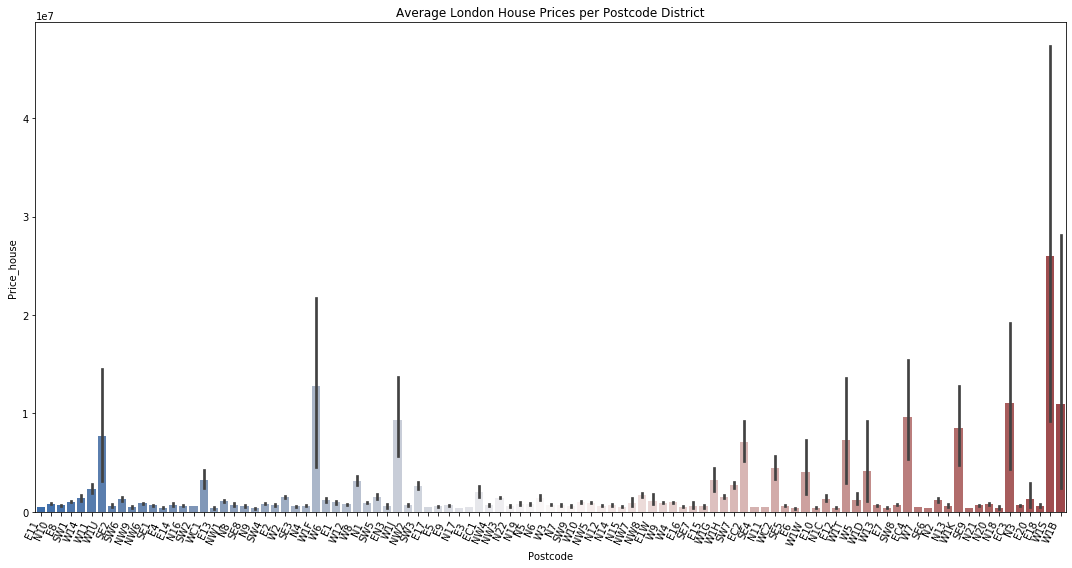

In [49]:
plt.figure(figsize=(15,8))
sns.barplot(x=merged1['Postcode'],y=merged1['Price_house'],palette='vlag')
plt.xticks(rotation=65,horizontalalignment='right')
plt.title('Average London House Prices per Postcode District')
plt.tight_layout()
plt.show()

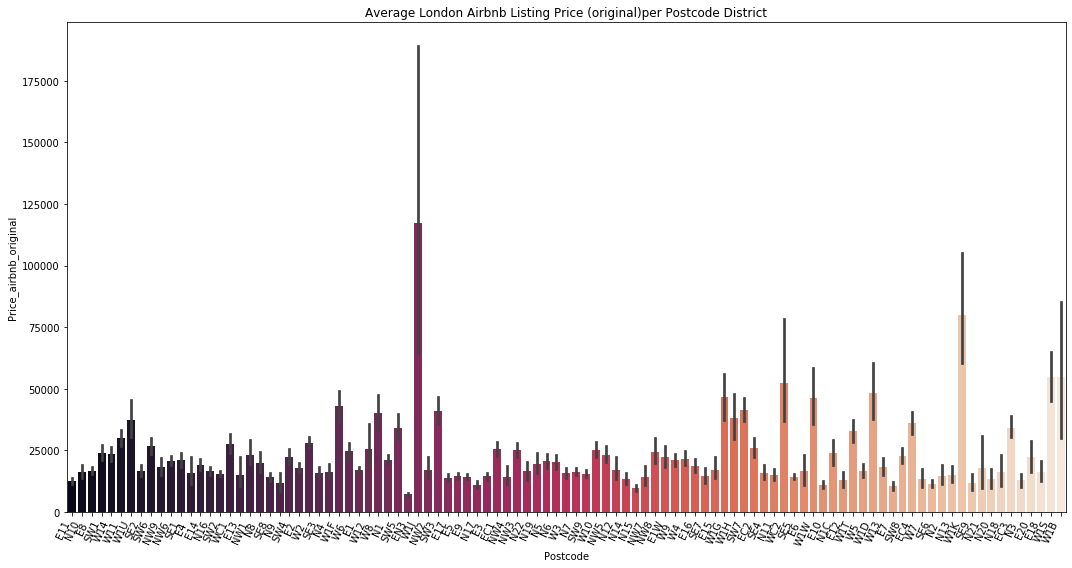

In [50]:
plt.figure(figsize=(15,8))
sns.barplot(x=merged1['Postcode'],y=merged1['Price_airbnb_original'],palette='rocket')
plt.xticks(rotation=65,horizontalalignment='right')
plt.title('Average London Airbnb Listing Price (original)per Postcode District')
plt.tight_layout()
plt.show()

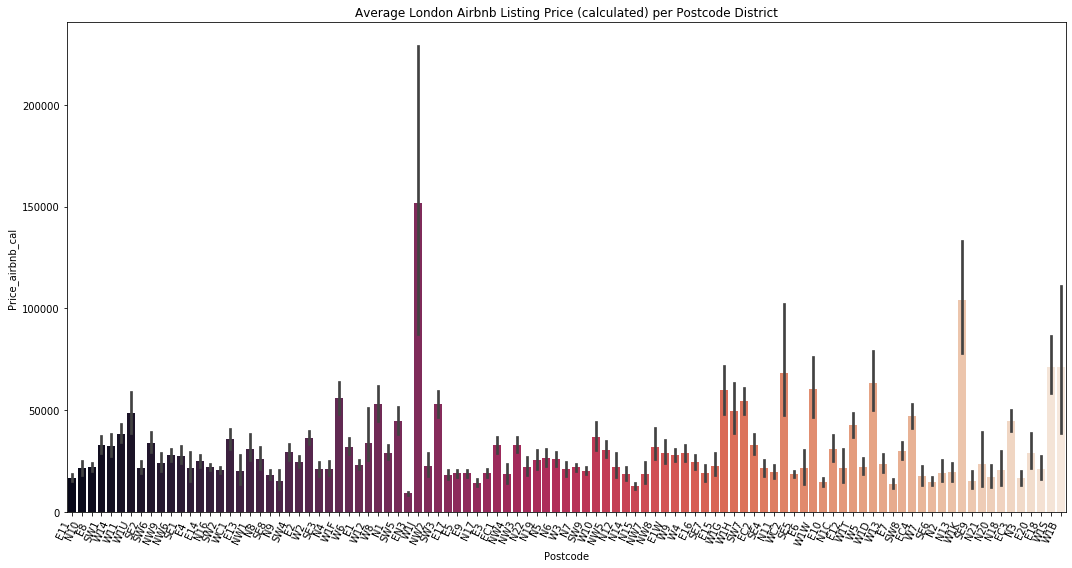

In [51]:
plt.figure(figsize=(15,8))
sns.barplot(x=merged1['Postcode'],y=merged1['Price_airbnb_cal'],palette='rocket')
plt.xticks(rotation=65,horizontalalignment='right')
plt.title('Average London Airbnb Listing Price (calculated) per Postcode District')
plt.tight_layout()
plt.show()

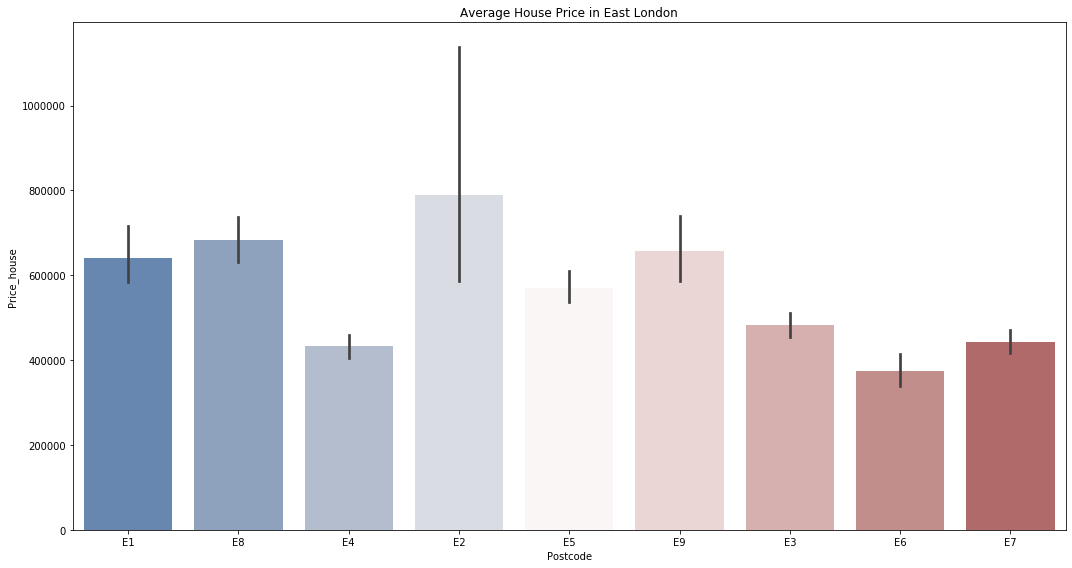

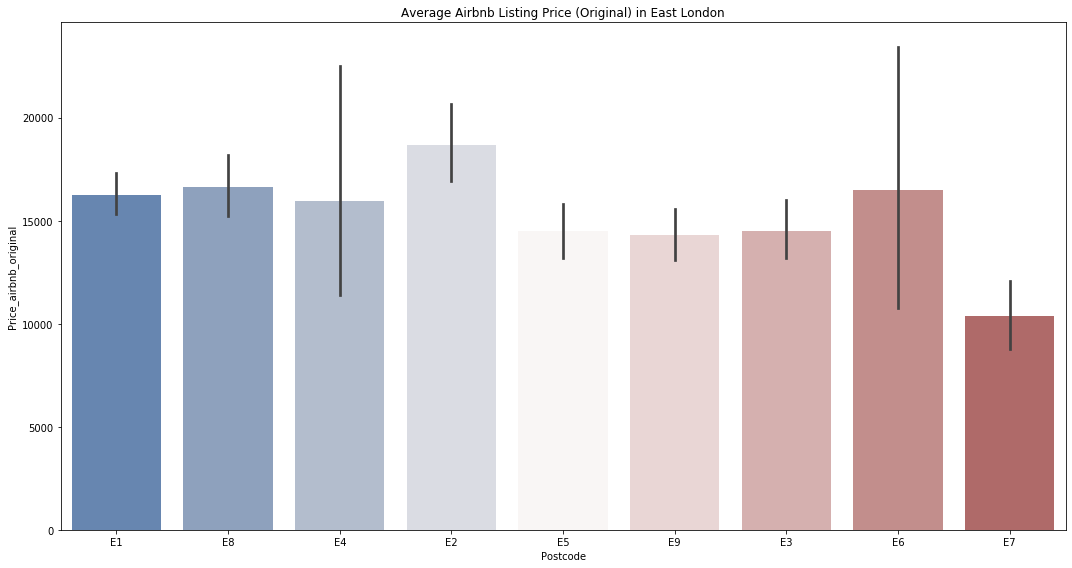

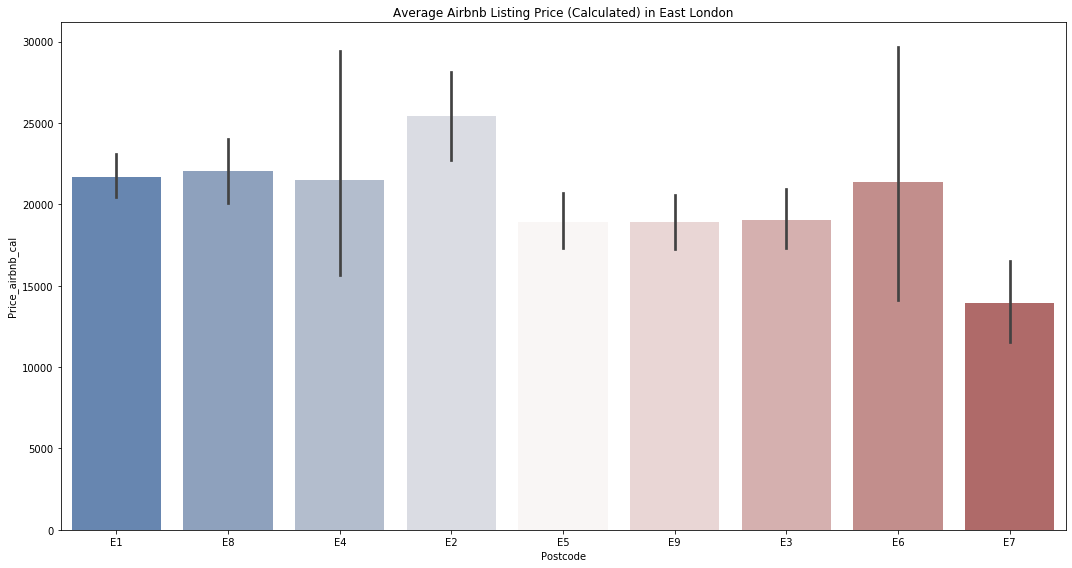

In [52]:
#Visualise average house and aribnb listing prices in East London
plt.figure(figsize=(15,8))
sns.barplot(x=East_merged['Postcode'],y=East_merged['Price_house'],palette='vlag')
plt.title('Average House Price in East London')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15,8))
sns.barplot(x=East_merged['Postcode'],y=East_merged['Price_airbnb_original'],palette='vlag')
plt.title('Average Airbnb Listing Price (Original) in East London')
plt.tight_layout()

plt.figure(figsize=(15,8))
sns.barplot(x=East_merged['Postcode'],y=East_merged['Price_airbnb_cal'],palette='vlag')
plt.title('Average Airbnb Listing Price (Calculated) in East London')
plt.tight_layout()

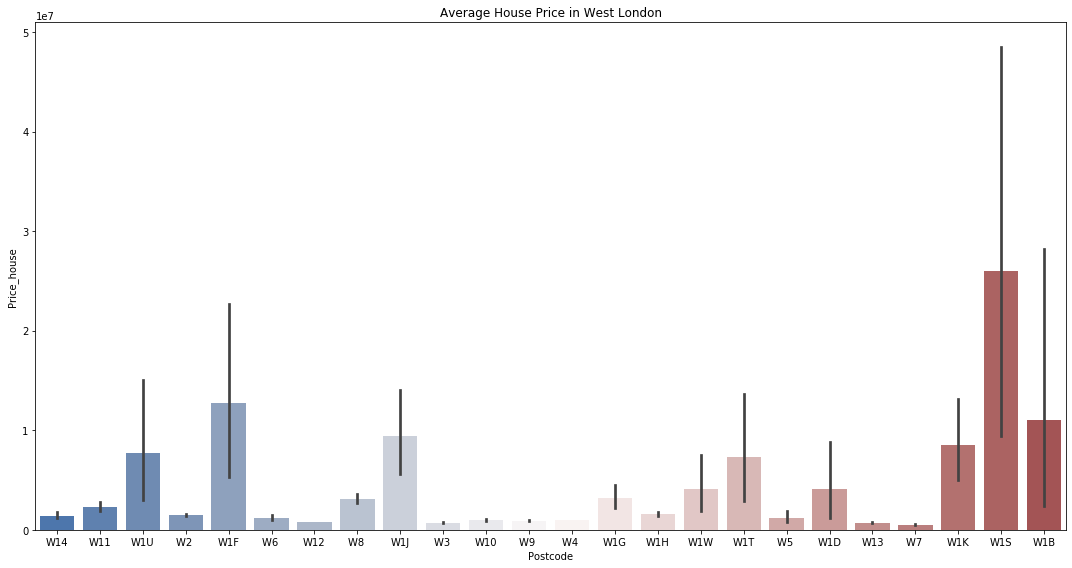

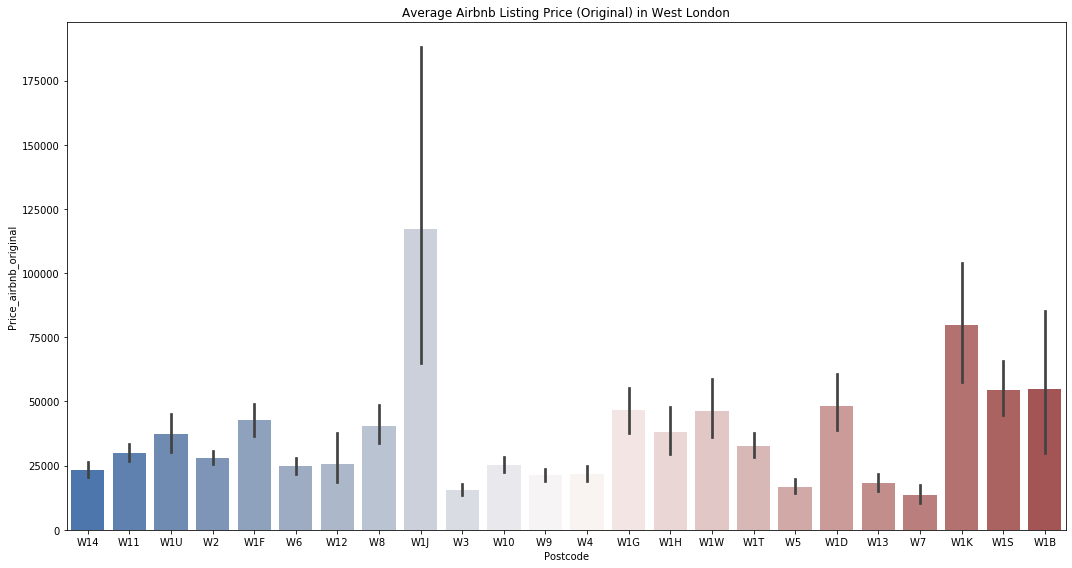

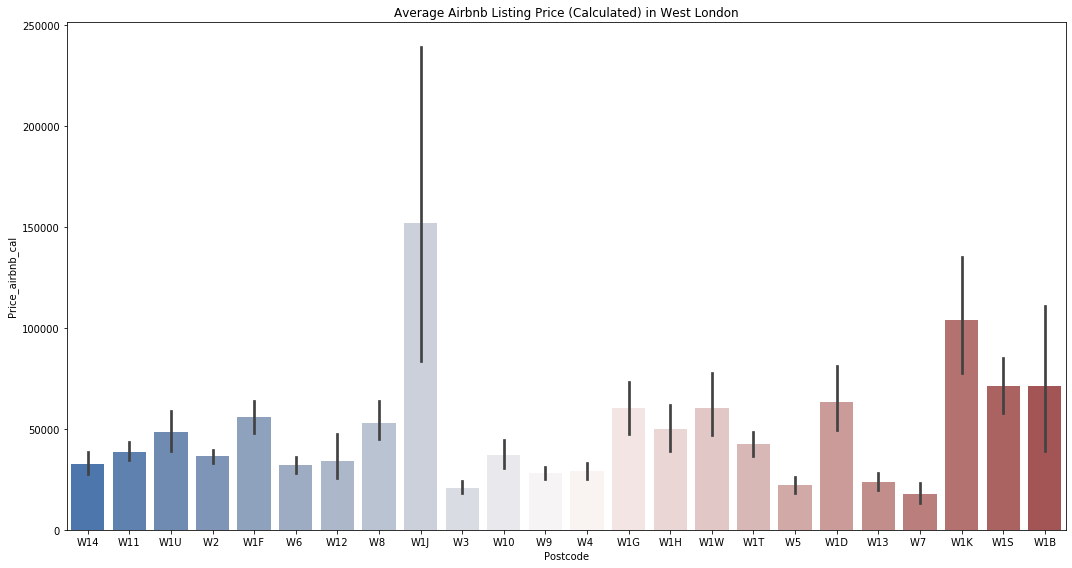

In [53]:
#Visualise average house and aribnb listing prices in West London
plt.figure(figsize=(15,8))
sns.barplot(x=West_merged['Postcode'],y=West_merged['Price_house'],palette='vlag')
plt.title('Average House Price in West London')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15,8))
sns.barplot(x=West_merged['Postcode'],y=West_merged['Price_airbnb_original'],palette='vlag')
plt.title('Average Airbnb Listing Price (Original) in West London')
plt.tight_layout()

plt.figure(figsize=(15,8))
sns.barplot(x=West_merged['Postcode'],y=West_merged['Price_airbnb_cal'],palette='vlag')
plt.title('Average Airbnb Listing Price (Calculated) in West London')
plt.tight_layout()

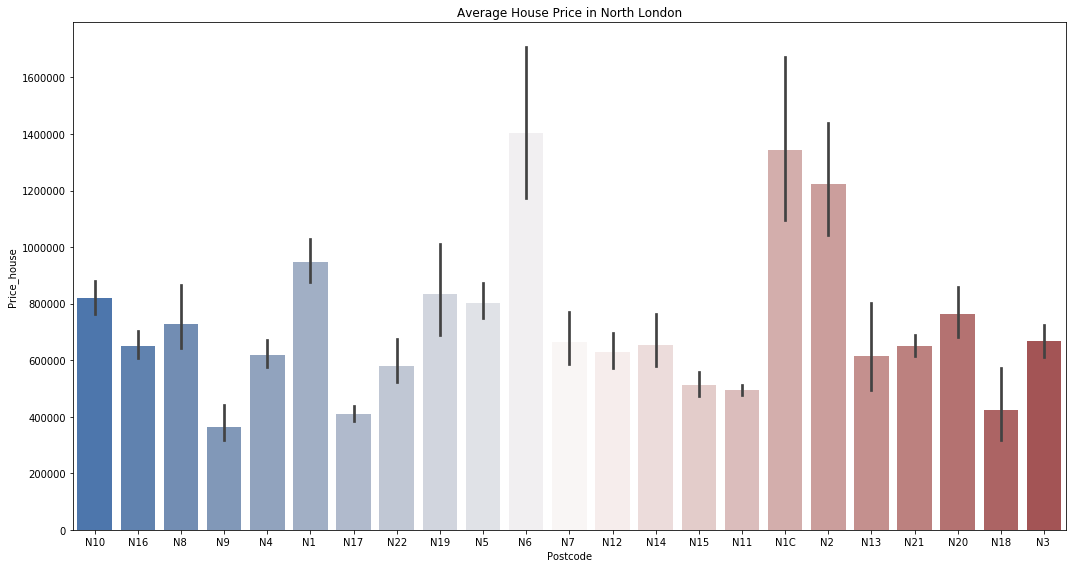

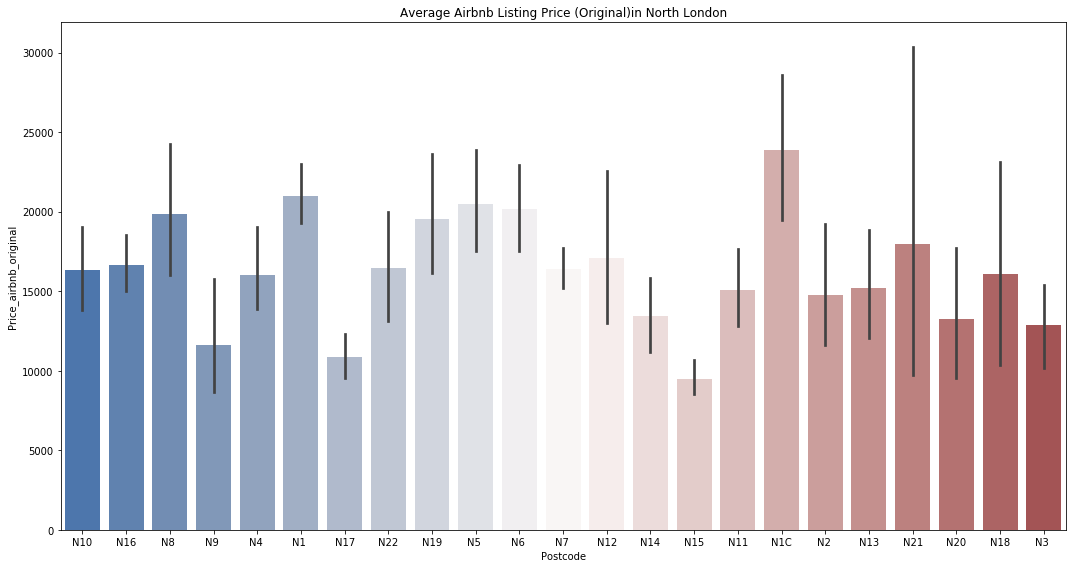

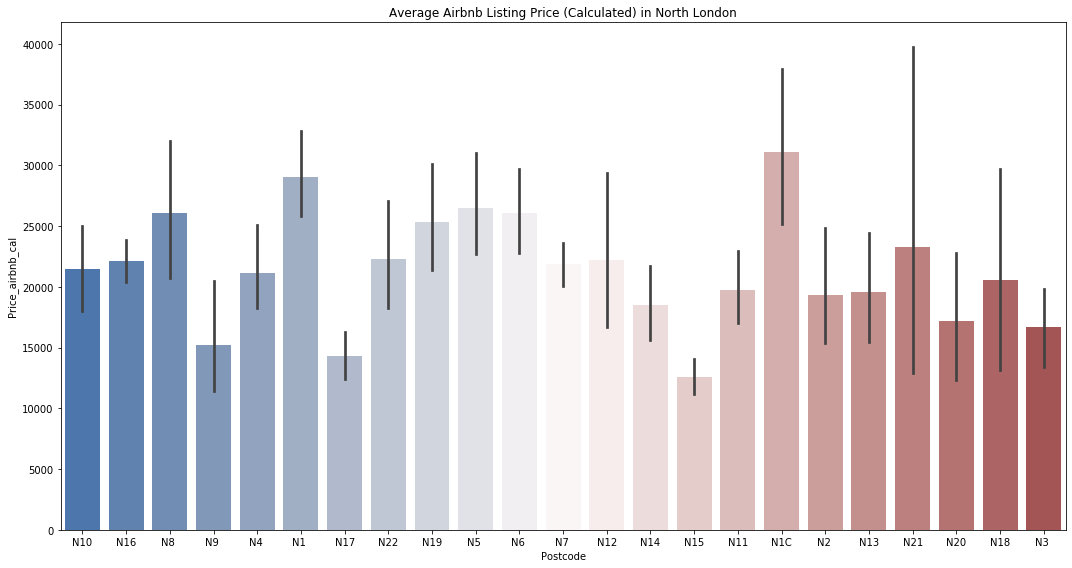

In [54]:
#Visualise average house and aribnb listing prices in North London
plt.figure(figsize=(15,8))
sns.barplot(x=North_merged['Postcode'],y=North_merged['Price_house'],palette='vlag')
plt.title('Average House Price in North London')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15,8))
sns.barplot(x=North_merged['Postcode'],y=North_merged['Price_airbnb_original'],palette='vlag')
plt.title('Average Airbnb Listing Price (Original)in North London')
plt.tight_layout()

plt.figure(figsize=(15,8))
sns.barplot(x=North_merged['Postcode'],y=North_merged['Price_airbnb_cal'],palette='vlag')
plt.title('Average Airbnb Listing Price (Calculated) in North London')
plt.tight_layout()

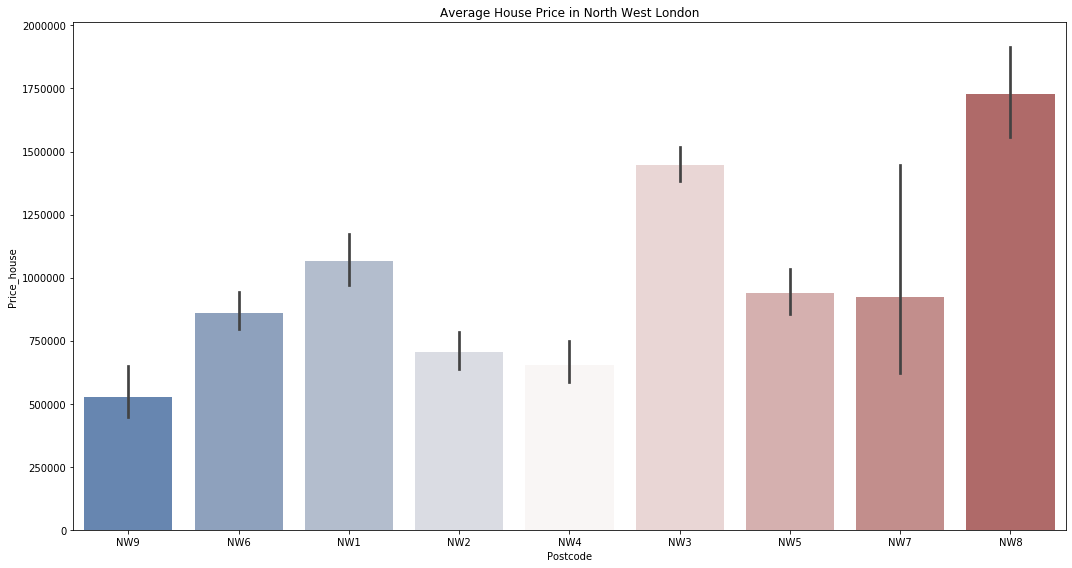

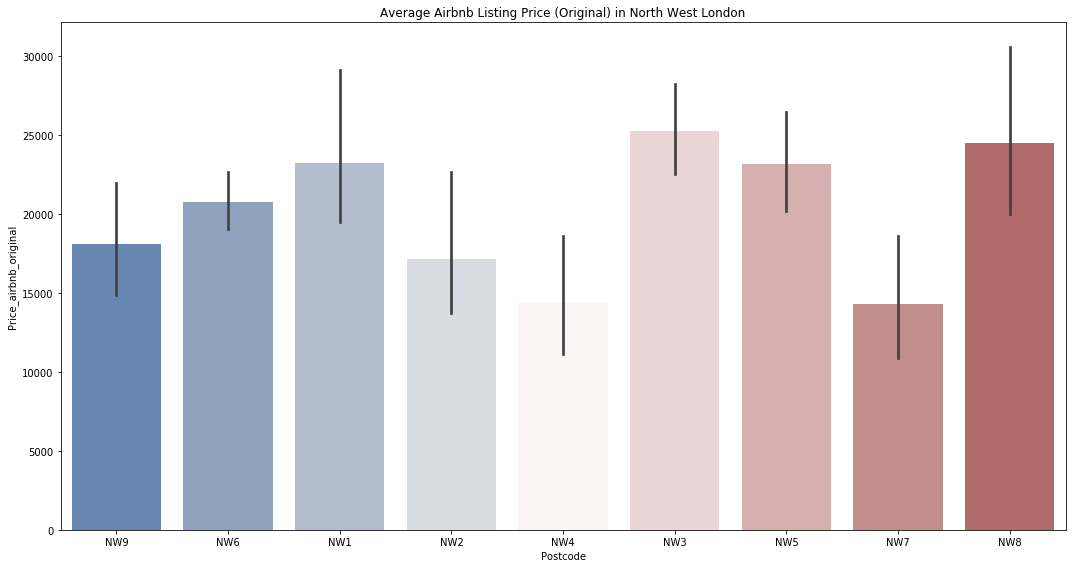

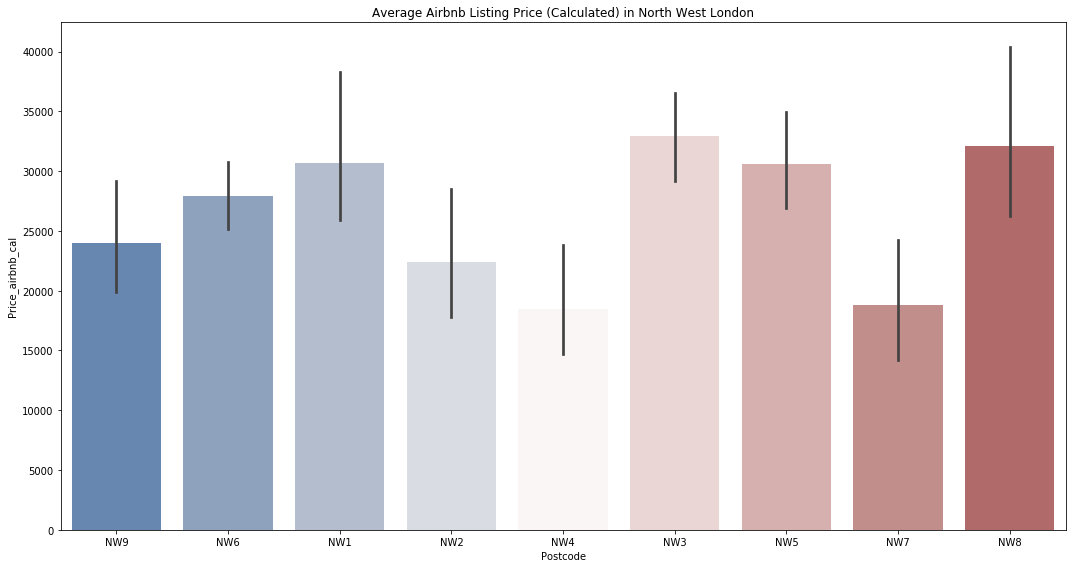

In [55]:
#Visualise average house and aribnb listing prices in North West London
plt.figure(figsize=(15,8))
sns.barplot(x=North_West_merged['Postcode'],y=North_West_merged['Price_house'],palette='vlag')
plt.title('Average House Price in North West London')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15,8))
sns.barplot(x=North_West_merged['Postcode'],y=North_West_merged['Price_airbnb_original'],palette='vlag')
plt.title('Average Airbnb Listing Price (Original) in North West London')
plt.tight_layout()

plt.figure(figsize=(15,8))
sns.barplot(x=North_West_merged['Postcode'],y=North_West_merged['Price_airbnb_cal'],palette='vlag')
plt.title('Average Airbnb Listing Price (Calculated) in North West London')
plt.tight_layout()

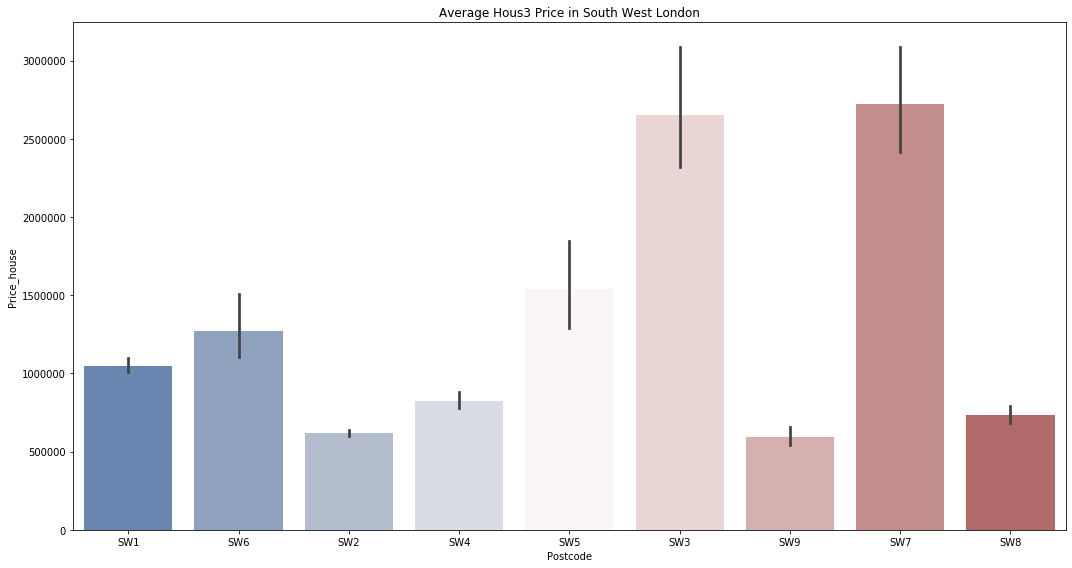

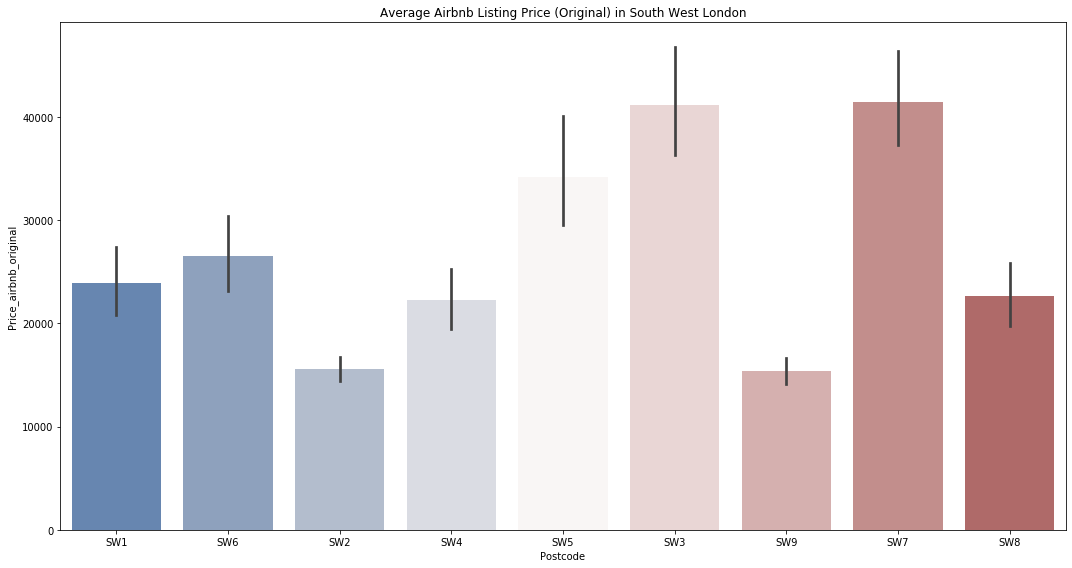

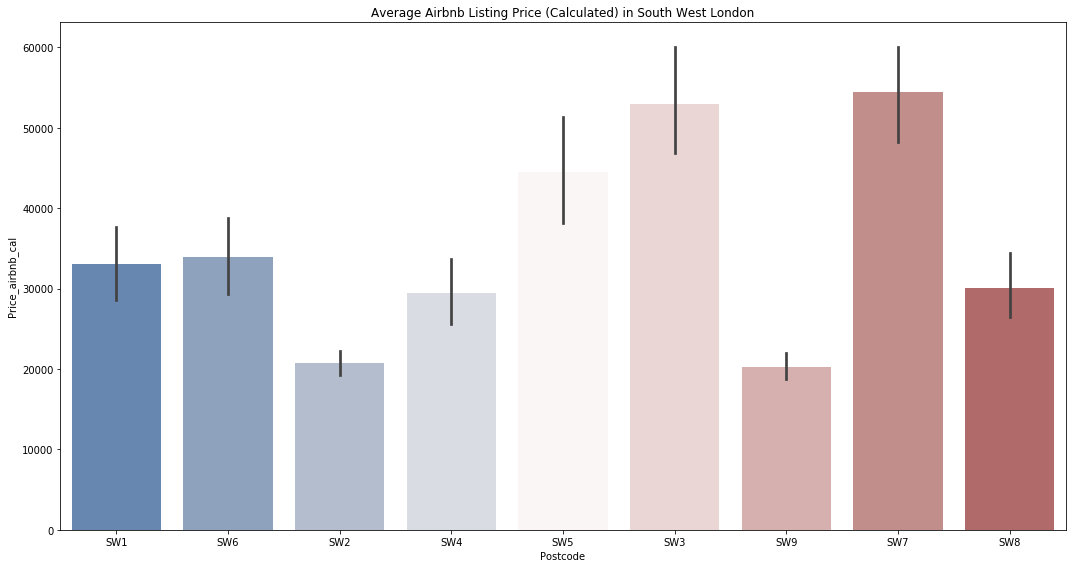

In [56]:
#Visualise average house and aribnb listing prices in South West London
plt.figure(figsize=(15,8))
sns.barplot(x=South_West_merged['Postcode'],y=South_West_merged['Price_house'],palette='vlag')
plt.title('Average Hous3 Price in South West London')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15,8))
sns.barplot(x=South_West_merged['Postcode'],y=South_West_merged['Price_airbnb_original'],palette='vlag')
plt.title('Average Airbnb Listing Price (Original) in South West London')
plt.tight_layout()

plt.figure(figsize=(15,8))
sns.barplot(x=South_West_merged['Postcode'],y=South_West_merged['Price_airbnb_cal'],palette='vlag')
plt.title('Average Airbnb Listing Price (Calculated) in South West London')
plt.tight_layout()

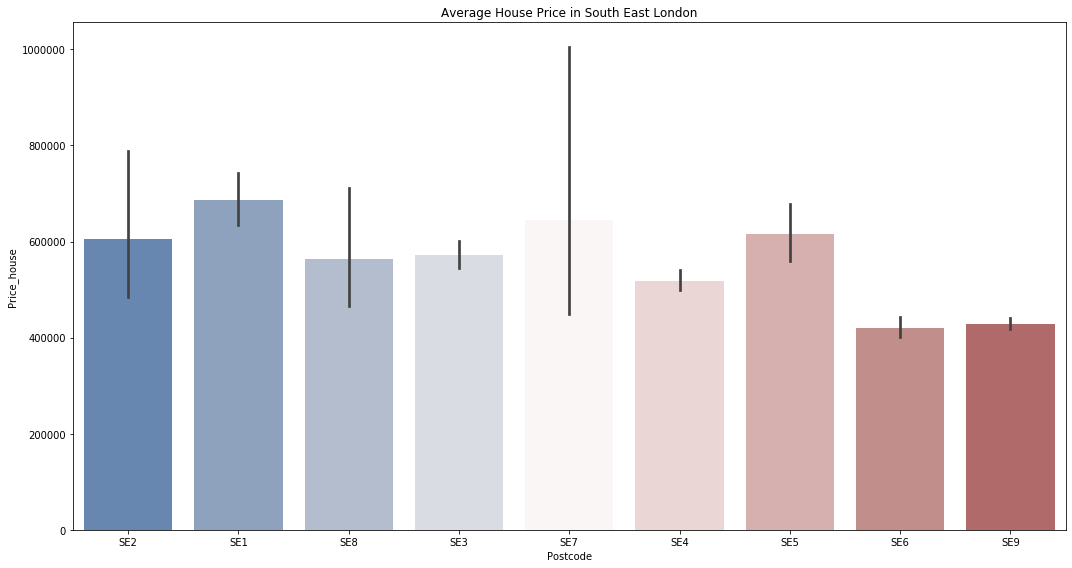

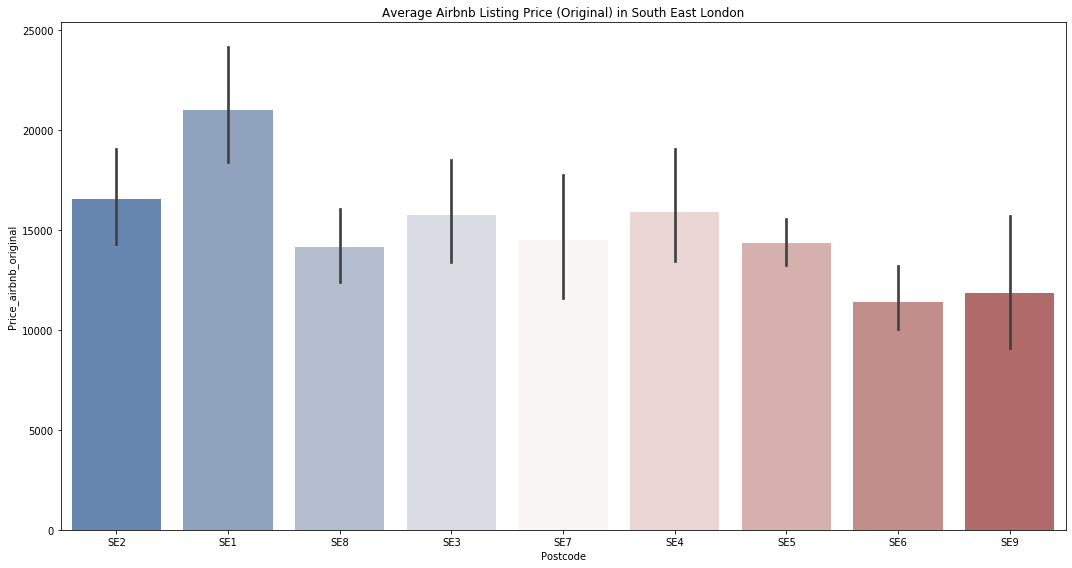

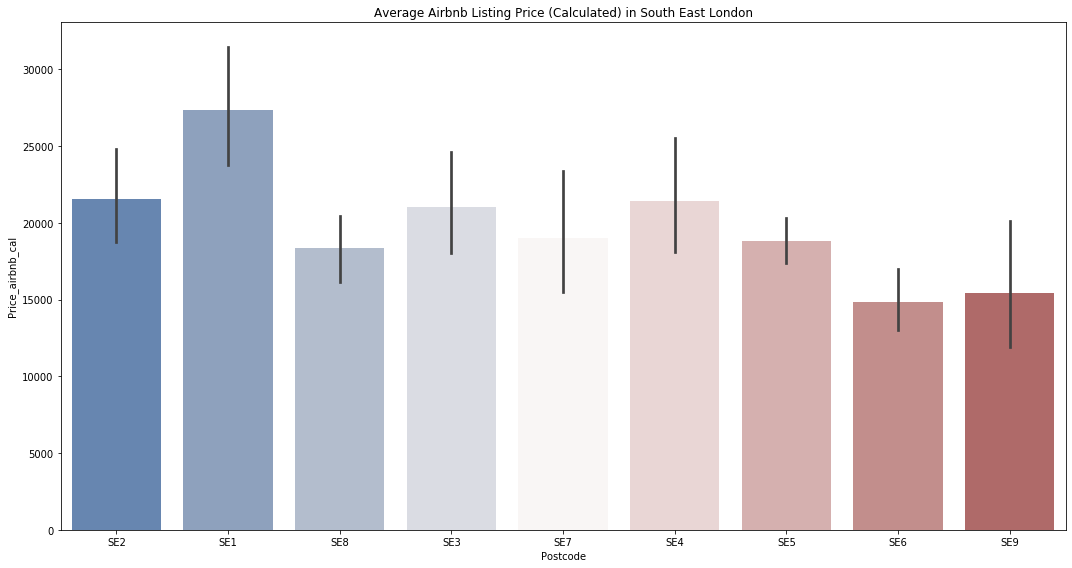

In [57]:
#Visualise average house and aribnb listing prices in South East London
plt.figure(figsize=(15,8))
sns.barplot(x=South_East_merged['Postcode'],y=South_East_merged['Price_house'],palette='vlag')
plt.title('Average House Price in South East London')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15,8))
sns.barplot(x=South_East_merged['Postcode'],y=South_East_merged['Price_airbnb_original'],palette='vlag')
plt.title('Average Airbnb Listing Price (Original) in South East London')
plt.tight_layout()

plt.figure(figsize=(15,8))
sns.barplot(x=South_East_merged['Postcode'],y=South_East_merged['Price_airbnb_cal'],palette='vlag')
plt.title('Average Airbnb Listing Price (Calculated) in South East London')
plt.tight_layout()

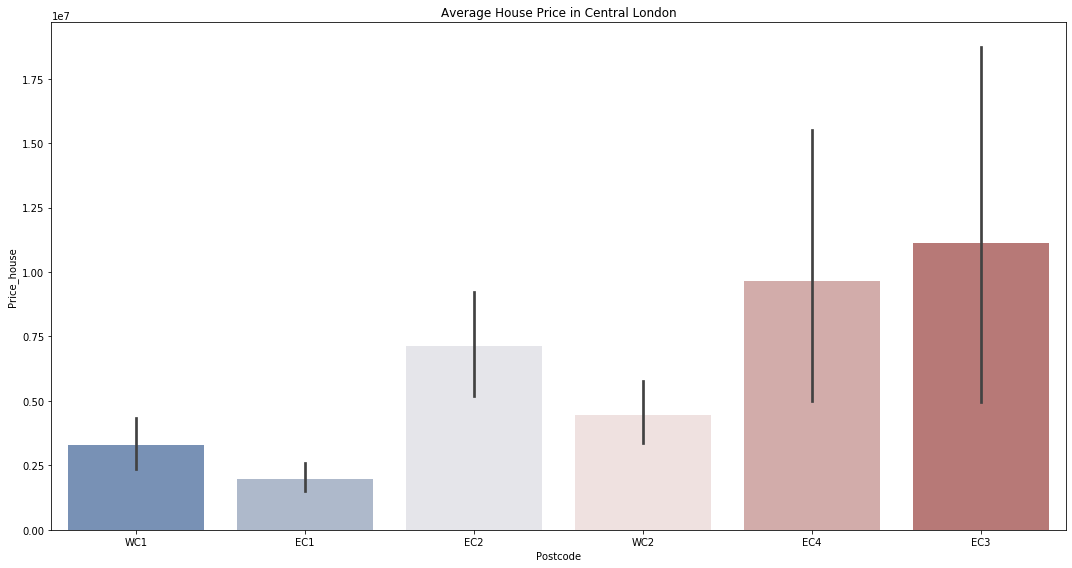

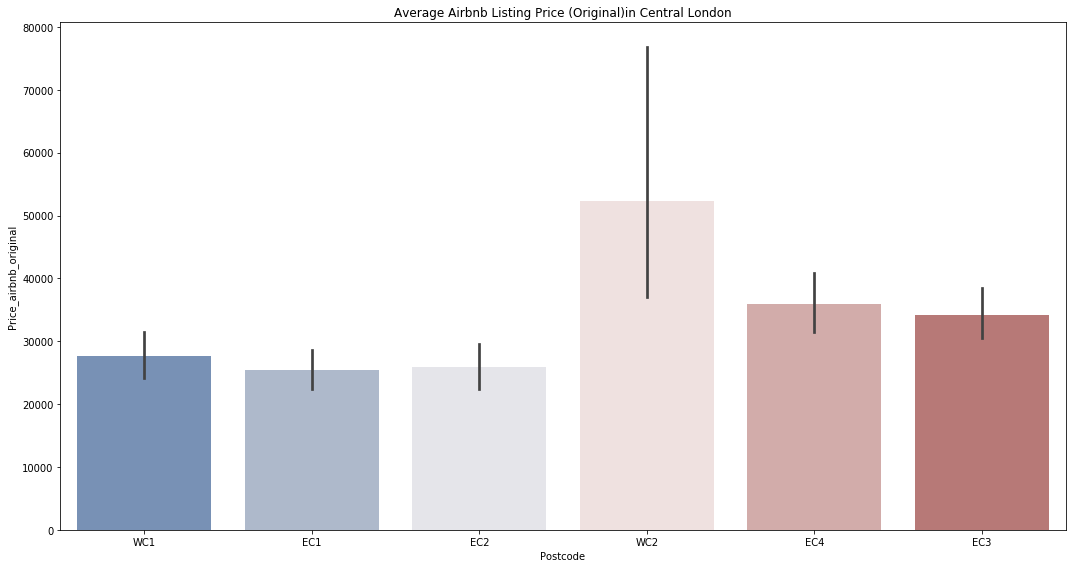

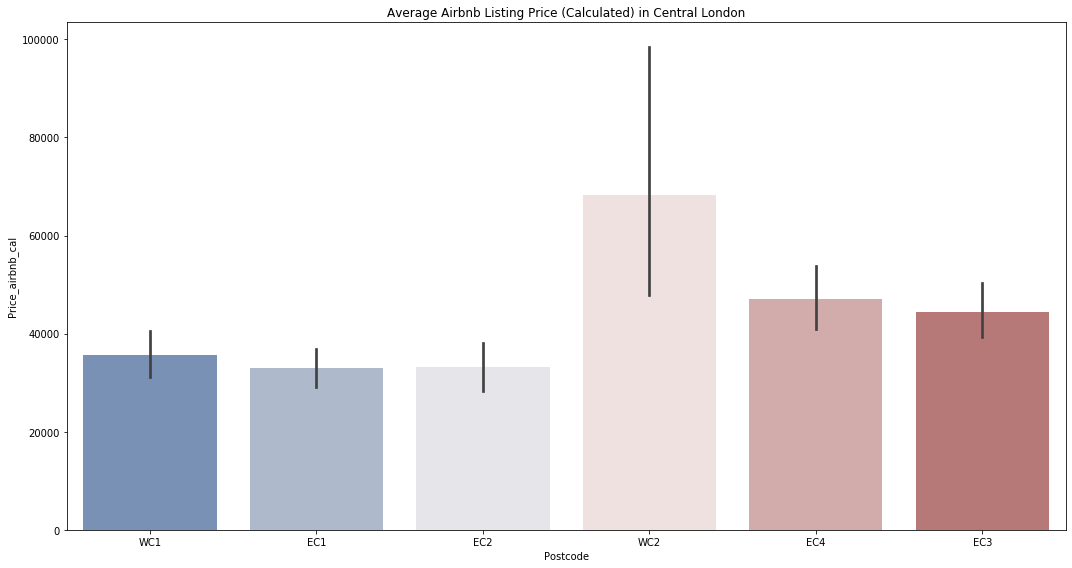

In [58]:
#Visualise average house and aribnb listing prices in Central London
plt.figure(figsize=(15,8))
sns.barplot(x=Central_merged['Postcode'],y=Central_merged['Price_house'],palette='vlag')
plt.title('Average House Price in Central London')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15,8))
sns.barplot(x=Central_merged['Postcode'],y=Central_merged['Price_airbnb_original'],palette='vlag')
plt.title('Average Airbnb Listing Price (Original)in Central London')
plt.tight_layout()

plt.figure(figsize=(15,8))
sns.barplot(x=Central_merged['Postcode'],y=Central_merged['Price_airbnb_cal'],palette='vlag')
plt.title('Average Airbnb Listing Price (Calculated) in Central London')
plt.tight_layout()

       5.4 Log transformation

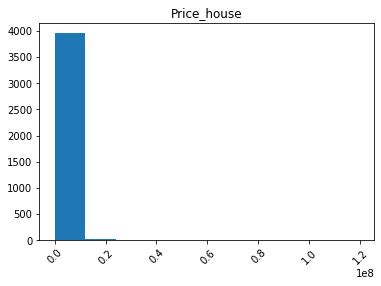

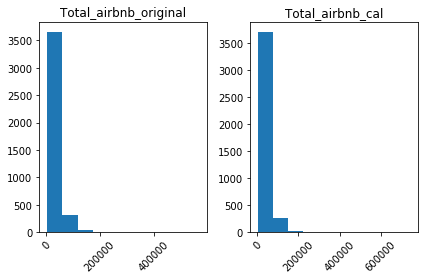

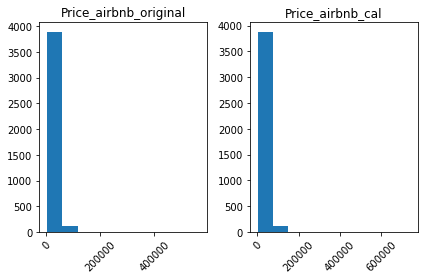

In [59]:
#Visualise the datasets with histograms to see if log transformation is needed
plt.hist(merged1['Price_house'])
plt.title('Price_house')
plt.xticks(rotation=45)
plt.show()

plt.subplot(1,2,1)
plt.hist(merged1['Total_airbnb_original'])
plt.title('Total_airbnb_original')
plt.xticks(rotation=45)

plt.subplot(1,2,2)
plt.hist(merged1['Total_airbnb_cal'])
plt.title('Total_airbnb_cal')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.subplot(1,2,1)
plt.hist(merged1['Price_airbnb_original'])
plt.title('Price_airbnb_original')
plt.xticks(rotation=45)

plt.subplot(1,2,2)
plt.hist(merged1['Price_airbnb_cal'])
plt.title('Price_airbnb_cal')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The histograms showed that all of the columns in the datasets are highly skewed to the left, therefore, a log transformation will be applied. 

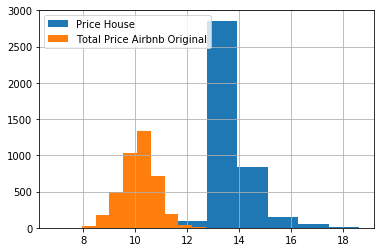

In [60]:
#Applying log transformation
merged1['Price_house'].apply(np.log).hist(label='Price House')
merged1['Total_airbnb_original'].apply(np.log).hist(label='Total Price Airbnb Original')
plt.legend(loc='upper left')
plt.show()

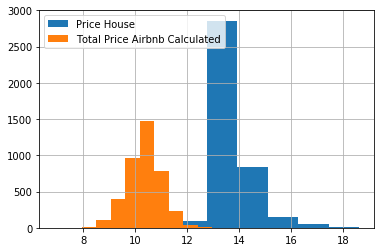

In [61]:
#Applying log transformation
merged1['Price_house'].apply(np.log).hist(label='Price House')
merged1['Total_airbnb_cal'].apply(np.log).hist(label='Total Price Airbnb Calculated')
plt.legend(loc='upper left')
plt.show()

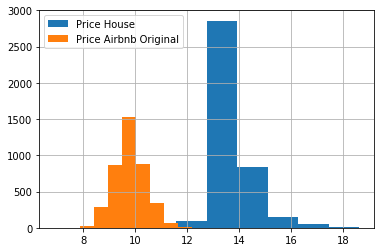

In [62]:
#Applying log transformation
merged1['Price_house'].apply(np.log).hist(label='Price House')
merged1['Price_airbnb_original'].apply(np.log).hist(label='Price Airbnb Original')
plt.legend(loc='upper left')
plt.show()

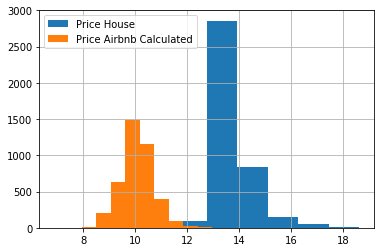

In [63]:
#Applying log transformation
merged1['Price_house'].apply(np.log).hist(label='Price House')
merged1['Price_airbnb_cal'].apply(np.log).hist(label='Price Airbnb Calculated')
plt.legend(loc='upper left')
plt.show()

In [64]:
#Insert log transformed columns to the dataframe
log_Price_house           = np.log(merged1.Price_house)
log_Price_airbnb_original = np.log(merged1.Price_airbnb_original)
log_Price_airbnb_cal      = np.log(merged1.Price_airbnb_cal)
log_Total_airbnb_original = np.log(merged1.Total_airbnb_original)
log_Total_airbnb_cal      = np.log(merged1.Total_airbnb_cal)

merged1.insert(2,'log_Price_house',log_Price_house)
merged1.insert(4,'log_Price_airbnb_original',log_Price_airbnb_original)
merged1.insert(6,'log_Price_airbnb_cal',log_Price_airbnb_cal)
merged1.insert(8,'log_Total_airbnb_original',log_Total_airbnb_original)
merged1.insert(10,'log_Total_airbnb_cal',log_Total_airbnb_cal)

merged1.head()

Postcode    Price_house  log_Price_house  Price_airbnb_original  \
2011-07-01      E11  290454.462963        12.579202                7197.84   
2011-10-01      N10  526962.500000        13.174885                8545.68   
2011-11-01      E8   345966.444444        12.754097               14086.80   
2012-03-01      SW1  602646.250000        13.309086                4680.00   
2012-07-01      W14  735819.150000        13.508740                9360.00   

            log_Price_airbnb_original  Price_airbnb_cal  log_Price_airbnb_cal  \
2011-07-01                   8.881536            9964.5              9.206784   
2011-10-01                   9.053181           12811.5              9.458098   
2011-11-01                   9.552993           35587.5             10.479750   
2012-03-01                   8.451053            7117.5              8.870312   
2012-07-01                   9.144201            9964.5              9.206784   

            Total_airbnb_original  log_Total_airbnb_original  \
2011-07-01                7197.84                   8.881536   
2011-10-01                8545.68                   9.053181   
2011-11-01               25036.80                  10.128102   
2012-03-01                4680.00                   8.451053   
2012-07-01               36735.00                  10.511485   

            Total_airbnb_cal  log_Total_airbnb_cal  
2011-07-01            9964.5              9.206784  
2011-10-01           12811.5              9.458098  
2011-11-01           46537.5             10.748014  
2012-03-01            7117.5              8.870312  
2012-07-01           37339.5             10.527807

In [65]:
#Applying log transformation to each postcode districts
East_merged   = merged1[merged1['Postcode'].str[0]=='E']
East_merged   = East_merged[East_merged['Postcode'].str[1]!='C']
East_merged   = East_merged[East_merged['Postcode'].str[1]!='N']

if East_merged['Postcode'].all()<='E18':
    East_merged['Postcode'] = East_merged['Postcode']
else: 
    East_merged['Postcode'] = East_merged['Postcode'].str[0:2]

East_merged.drop_duplicates(subset=['Postcode']).reset_index()
    
West_merged   = merged1[merged1['Postcode'].str[0]=='W']
West_merged   = West_merged[West_merged['Postcode'].str[1]!='C']

West_merged.drop_duplicates(subset=['Postcode']).reset_index()

North_merged = merged1[merged1['Postcode'].str[0]=='N']
North_West_merged = North_merged[North_merged['Postcode'].str[1]=='W']
North_merged = North_merged[North_merged['Postcode'].str[1]!='W']

North_merged.drop_duplicates(subset=['Postcode']).reset_index()
North_West_merged.drop_duplicates(subset=['Postcode']).reset_index()

South_merged = merged1[merged1['Postcode'].str[0]=='S']    
South_East_merged = South_merged[South_merged['Postcode'].str[1]=='E']
South_West_merged = South_merged[South_merged['Postcode'].str[1]=='W']

South_East_merged.drop_duplicates(subset=['Postcode']).reset_index()
South_West_merged.drop_duplicates(subset=['Postcode']).reset_index()
       
Central_merged = merged1[merged1['Postcode'].str[1]=='C']

Central_merged.drop_duplicates(subset=['Postcode']).reset_index()

IG = merged1[merged1['Postcode'].str[0]=='I']
RM = merged1[merged1['Postcode'].str[0]=='R']
EN = merged1[merged1['Postcode'].str[1]=='N']
DA = merged1[merged1['Postcode'].str[0]=='D']
BR = merged1[merged1['Postcode'].str[0]=='B']
CR = merged1[merged1['Postcode'].str[0]=='C']
SM = merged1[merged1['Postcode'].str[1]=='M']
KT = merged1[merged1['Postcode'].str[0]=='K']
TW = merged1[merged1['Postcode'].str[0]=='T']
UB = merged1[merged1['Postcode'].str[0]=='U']
HA = merged1[merged1['Postcode'].str[0]=='H']
WD = merged1[merged1['Postcode'].str[1]=='D']

Outer_merged = pd.concat([IG,RM,EN,DA,BR,CR,SM,KT,TW,UB,HA,WD]).reset_index()

    5.5 Robust statistics

mean: 1567345.7965249384 median: 719575.588888889 
 std: 4859458.322683743 iqr: 634198.4623040752 
 std: 4859458.322683743 mad: 356824.102857061


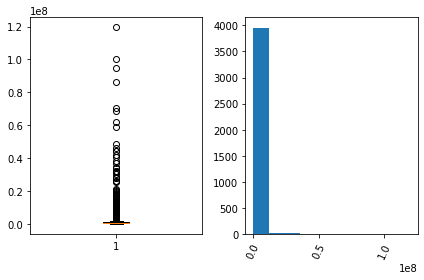

In [66]:
f, ax = plt.subplots(1, 2)
ax[0].boxplot(merged1['Price_house'])
ax[1].hist(merged1['Price_house'])
plt.xticks(rotation=65)
plt.tight_layout()

print('mean:', merged1['Price_house'].mean(),'median:', merged1['Price_house'].median(),
      '\n std:', merged1['Price_house'].std(),'iqr:', stats.iqr(merged1['Price_house']),
      '\n std:', merged1['Price_house'].std(),'mad:', sm.robust.scale.mad(merged1['Price_house']))

mean: 22311.422501676636 median: 17770.707152388135 
 std: 21173.182022649493 iqr: 13853.758830167859 
 std: 21173.182022649493 mad: 9407.960290278797


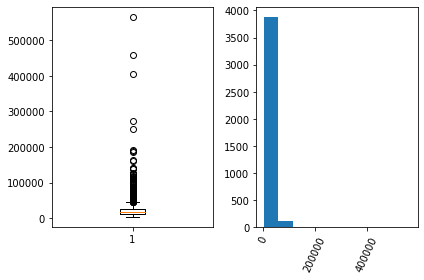

In [67]:
f, ax = plt.subplots(1, 2)
ax[0].boxplot(merged1['Price_airbnb_original'])
ax[1].hist(merged1['Price_airbnb_original'])
plt.xticks(rotation=65)
plt.tight_layout()

print('mean:', merged1['Price_airbnb_original'].mean(),'median:', merged1['Price_airbnb_original'].median(),
      '\n std:', merged1['Price_airbnb_original'].std(),'iqr:', stats.iqr(merged1['Price_airbnb_original']),
      '\n std:', merged1['Price_airbnb_original'].std(),'mad:', sm.robust.scale.mad(merged1['Price_airbnb_original']))

mean: 29392.69299331602 median: 23459.280000000002 
 std: 27780.303624888697 iqr: 17793.75 
 std: 27780.303624888697 mad: 12268.948486755042


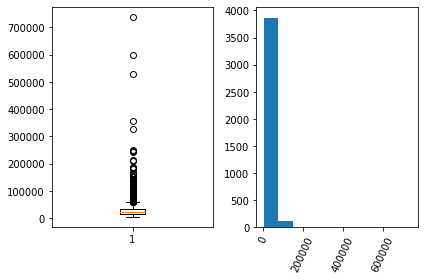

In [68]:
f, ax = plt.subplots(1, 2)
ax[0].boxplot(merged1['Price_airbnb_cal'])
ax[1].hist(merged1['Price_airbnb_cal'])
plt.xticks(rotation=65)
plt.tight_layout()

print('mean:', merged1['Price_airbnb_cal'].mean(),'median:', merged1['Price_airbnb_cal'].median(),
      '\n std:', merged1['Price_airbnb_cal'].std(),'iqr:', stats.iqr(merged1['Price_airbnb_cal']),
      '\n std:', merged1['Price_airbnb_cal'].std(),'mad:', sm.robust.scale.mad(merged1['Price_airbnb_cal']))

mean: 32183.804866107334 median: 26459.70603386602 
 std: 26709.027915366358 iqr: 22352.034618780854 
 std: 26709.027915366358 mad: 15822.336894542803


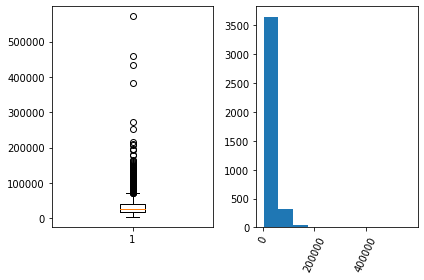

In [69]:
f, ax = plt.subplots(1, 2)
ax[0].boxplot(merged1['Total_airbnb_original'])
ax[1].hist(merged1['Total_airbnb_original'])
plt.xticks(rotation=65)
plt.tight_layout()

print('mean:', merged1['Total_airbnb_original'].mean(),'median:', merged1['Total_airbnb_original'].median(),
      '\n std:', merged1['Total_airbnb_original'].std(),'iqr:', stats.iqr(merged1['Total_airbnb_original']),
      '\n std:', merged1['Total_airbnb_original'].std(),'mad:', sm.robust.scale.mad(merged1['Total_airbnb_original']))

mean: 39265.07535774679 median: 32200.3 
 std: 33063.89522918519 iqr: 26463.845707070708 
 std: 33063.89522918519 mad: 18562.984616894468


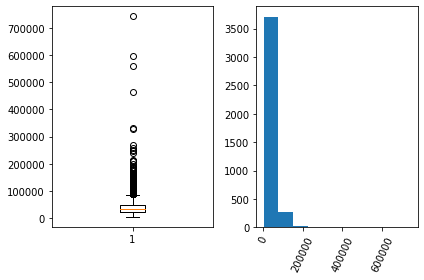

In [70]:
f, ax = plt.subplots(1, 2)
ax[0].boxplot(merged1['Total_airbnb_cal'])
ax[1].hist(merged1['Total_airbnb_cal'])
plt.xticks(rotation=65)
plt.tight_layout()

print('mean:', merged1['Total_airbnb_cal'].mean(),'median:', merged1['Total_airbnb_cal'].median(),
      '\n std:', merged1['Total_airbnb_cal'].std(),'iqr:', stats.iqr(merged1['Total_airbnb_cal']),
      '\n std:', merged1['Total_airbnb_cal'].std(),'mad:', sm.robust.scale.mad(merged1['Total_airbnb_cal']))

Here, the boxplots have shown the outliers of each columns more effectively than the histograms. The robust and non-robust statistics measures of each columns are shown too, we can see that the non-robust measures (std) are seriously affected by the outliers. 

    5.6 Simple correlation visualisation

Text(0.5, 1, 'Total Airbnb Price vs House Price (Original)')

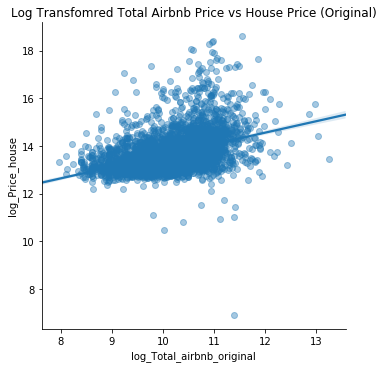

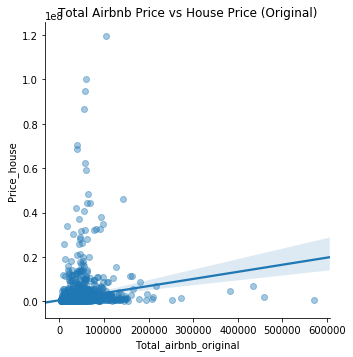

In [71]:
#Visualise a simple correlation between log transformed house prices and airbnb prices comparing
#with non log transformed datasets
sns.lmplot(x='log_Total_airbnb_original',y='log_Price_house',data=merged1,scatter_kws={'alpha':0.4})
plt.title('Log Transfomred Total Airbnb Price vs House Price (Original)')
sns.lmplot(x='Total_airbnb_original',y='Price_house',data=merged1,scatter_kws={'alpha':0.4})
plt.title('Total Airbnb Price vs House Price (Original)')

Text(0.5, 1, 'Total Airbnb Price vs House Price (Calculated)')

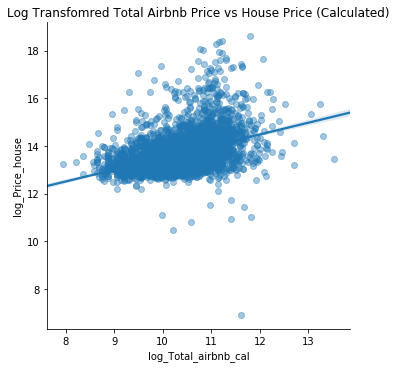

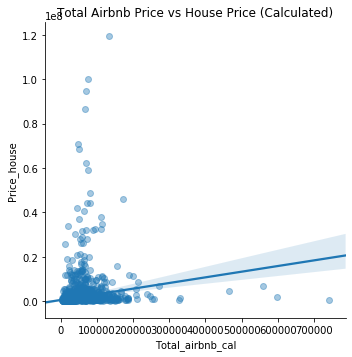

In [72]:
#Visualise a simple correlation between log transformed house prices and airbnb prices comparing
#with non log transformed datasets
sns.lmplot(x='log_Total_airbnb_cal',y='log_Price_house',data=merged1,scatter_kws={'alpha':0.4})
plt.title('Log Transfomred Total Airbnb Price vs House Price (Calculated)')
sns.lmplot(x='Total_airbnb_cal',y='Price_house',data=merged1,scatter_kws={'alpha':0.4})
plt.title('Total Airbnb Price vs House Price (Calculated)')

Text(0.5, 1, 'Airbnb Price vs House Price (Original)')

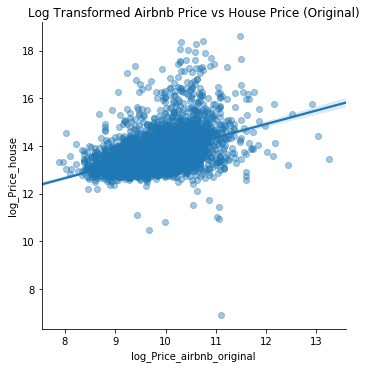

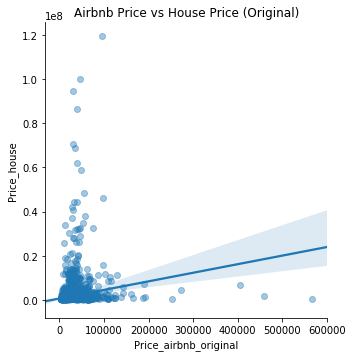

In [73]:
sns.lmplot(x='log_Price_airbnb_original',y='log_Price_house',data=merged1,scatter_kws={'alpha':0.4})
plt.title('Log Transformed Airbnb Price vs House Price (Original)')
sns.lmplot(x='Price_airbnb_original',y='Price_house',data=merged1,scatter_kws={'alpha':0.4})
plt.title('Airbnb Price vs House Price (Original)')

Text(0.5, 1, 'Airbnb Price vs House Price (Calculated)')

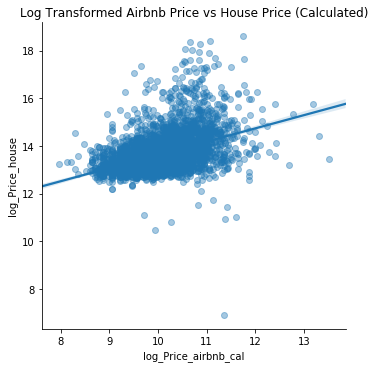

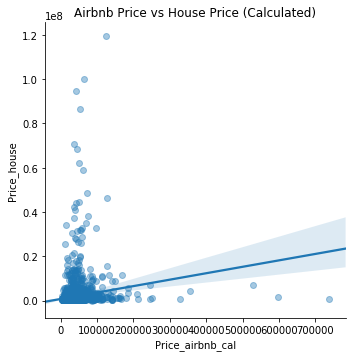

In [74]:
sns.lmplot(x='log_Price_airbnb_cal',y='log_Price_house',data=merged1,scatter_kws={'alpha':0.4})
plt.title('Log Transformed Airbnb Price vs House Price (Calculated)')
sns.lmplot(x='Price_airbnb_cal',y='Price_house',data=merged1,scatter_kws={'alpha':0.4})
plt.title('Airbnb Price vs House Price (Calculated)')

The regression plots showed there is a linear relationship between HP and ALP. By log transforming the dataset, the datapoints are more evenly distributed around the projected line. 

    5.7 Identiy and remove the outliers 

In [75]:
#1D outliers for each individual columns are already shown above, now 2D outliers will be shown 
#by comparing HP and ALP. 
#Calculate the mean and the std of each feature and identify the outliers
mean_house                 = merged1['log_Price_house'].mean()
mean_airbnb_original       = merged1['log_Price_airbnb_original'].mean()
mean_airbnb_cal            = merged1['log_Price_airbnb_cal'].mean()
mean_total_airbnb_original = merged1['log_Total_airbnb_original'].mean()
mean_total_airbnb_cal      = merged1['log_Total_airbnb_cal'].mean()

std_house                  = merged1['log_Price_house'].std()
std_airbnb_original        = merged1['log_Price_airbnb_original'].std()
std_airbnb_cal             = merged1['log_Price_airbnb_cal'].std()
std_total_airbnb_original  = merged1['log_Total_airbnb_original'].std()
std_total_airbnb_cal       = merged1['log_Total_airbnb_cal'].std()

is_outlier_house                 = np.where(abs(merged1['log_Price_house'] - mean_house) > 2 * std_house,
                                            1, 0)
is_outlier_airbnb_original       = np.where(abs(merged1['log_Price_airbnb_original'] - mean_airbnb_original) 
                                            > 2 * std_airbnb_original, 1, 0)
is_outlier_airbnb_cal            = np.where(abs(merged1['log_Price_airbnb_cal'] - mean_airbnb_cal) 
                                            > 2 * std_airbnb_cal, 1, 0)
is_outlier_total_airbnb_original = np.where(abs(merged1['log_Total_airbnb_original'] - mean_total_airbnb_original) 
                                            > 2 * std_total_airbnb_original, 1, 0)
is_outlier_total_airbnb_cal      = np.where(abs(merged1['log_Total_airbnb_cal'] - mean_total_airbnb_cal) 
                                            > 2 * std_total_airbnb_cal, 1, 0)

merged1.insert(11,'is_outlier_house',is_outlier_house)
merged1.insert(12,'is_outlier_airbnb_original',is_outlier_airbnb_original)
merged1.insert(13,'is_outlier_airbnb_cal',is_outlier_airbnb_cal)
merged1.insert(14,'is_outlier_total_airbnb_original',is_outlier_total_airbnb_original)
merged1.insert(15,'is_outlier_total_airbnb_cal',is_outlier_total_airbnb_cal)

from collections import Counter
print('Outliers for log transformed Price_house are: ',Counter(merged1['is_outlier_house']))
print('Outliers for log transformed Price_airbnb_original are: ',Counter(merged1['is_outlier_airbnb_original']))
print('Outliers for log transformed Price_airbnb_cal are: ',Counter(merged1['is_outlier_airbnb_cal']))
print('Outliers for log transformed Total_house_original are: ',Counter(merged1['is_outlier_total_airbnb_original']))
print('Outliers for log transformed Total_house_cal are: ',Counter(merged1['is_outlier_total_airbnb_cal']))

Outliers for log transformed Price_house are:  Counter({0: 3824, 1: 191})
Outliers for log transformed Price_airbnb_original are:  Counter({0: 3827, 1: 188})
Outliers for log transformed Price_airbnb_cal are:  Counter({0: 3832, 1: 183})
Outliers for log transformed Total_house_original are:  Counter({0: 3815, 1: 200})
Outliers for log transformed Total_house_cal are:  Counter({0: 3812, 1: 203})


In [76]:
#Calculate the mean and the std of each feature and identify the outliers
mean_house1                 = merged1['Price_house'].mean()
mean_airbnb_original1       = merged1['Price_airbnb_original'].mean()
mean_airbnb_cal1            = merged1['Price_airbnb_cal'].mean()
mean_total_airbnb_original1 = merged1['Total_airbnb_original'].mean()
mean_total_airbnb_cal1      = merged1['Total_airbnb_cal'].mean()

std_house1                  = merged1['Price_house'].std()
std_airbnb_original1        = merged1['Price_airbnb_original'].std()
std_airbnb_cal1             = merged1['Price_airbnb_cal'].std()
std_total_airbnb_original1  = merged1['Total_airbnb_original'].std()
std_total_airbnb_cal1       = merged1['Total_airbnb_cal'].std()

is_outlier_house1                 = np.where(abs(merged1['Price_house'] - mean_house1) > 2 * std_house1,
                                            1, 0)
is_outlier_airbnb_original1       = np.where(abs(merged1['Price_airbnb_original'] - mean_airbnb_original1) 
                                            > 2 * std_airbnb_original1, 1, 0)
is_outlier_airbnb_cal1            = np.where(abs(merged1['Price_airbnb_cal'] - mean_airbnb_cal1) 
                                            > 2 * std_airbnb_cal1, 1, 0)
is_outlier_total_airbnb_original1 = np.where(abs(merged1['Total_airbnb_original'] - mean_total_airbnb_original1) 
                                            > 2 * std_total_airbnb_original1, 1, 0)
is_outlier_total_airbnb_cal1      = np.where(abs(merged1['Total_airbnb_cal'] - mean_total_airbnb_cal1) 
                                            > 2 * std_total_airbnb_cal1, 1, 0)

merged1.insert(16,'is_outlier_house1',is_outlier_house1)
merged1.insert(17,'is_outlier_airbnb_original1',is_outlier_airbnb_original1)
merged1.insert(18,'is_outlier_airbnb_cal1',is_outlier_airbnb_cal1)
merged1.insert(19,'is_outlier_total_airbnb_original1',is_outlier_total_airbnb_original1)
merged1.insert(20,'is_outlier_total_airbnb_cal1',is_outlier_total_airbnb_cal1)

from collections import Counter
print('Outliers for  transformed Price_house are: ',Counter(merged1['is_outlier_house1']))
print('Outliers for  transformed Price_airbnb_original are: ',Counter(merged1['is_outlier_airbnb_original1']))
print('Outliers for  transformed Price_airbnb_cal are: ',Counter(merged1['is_outlier_airbnb_cal1']))
print('Outliers for  transformed Total_house_original are: ',Counter(merged1['is_outlier_total_airbnb_original1']))
print('Outliers for  transformed Total_house_cal are: ',Counter(merged1['is_outlier_total_airbnb_cal1']))

Outliers for  transformed Price_house are:  Counter({0: 3946, 1: 69})
Outliers for  transformed Price_airbnb_original are:  Counter({0: 3909, 1: 106})
Outliers for  transformed Price_airbnb_cal are:  Counter({0: 3906, 1: 109})
Outliers for  transformed Total_house_original are:  Counter({0: 3891, 1: 124})
Outliers for  transformed Total_house_cal are:  Counter({0: 3891, 1: 124})


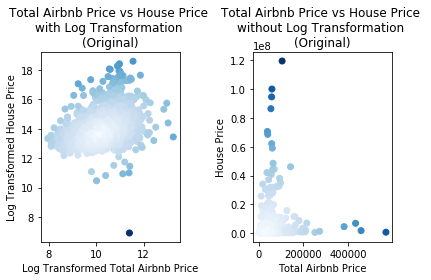

In [77]:
#Plot the outliers for with mahalnobis distance
column_values_log = merged1[['log_Total_airbnb_original','log_Price_house']].values
mean_vector_log   = np.asarray([merged1['log_Total_airbnb_original'].mean(),merged1['log_Price_house'].mean()]).reshape((1,2))
mahalanobis_distances_log = spatial.distance.cdist(column_values_log,mean_vector_log,'mahalanobis')[:,0]

column_values = merged1[['Total_airbnb_original','Price_house']].values
mean_vector   = np.asarray([merged1['Total_airbnb_original'].mean(),merged1['Price_house'].mean()]).reshape((1,2))
mahalanobis_distances = spatial.distance.cdist(column_values,mean_vector,'mahalanobis')[:,0]

plt.subplot(1,2,1)
plt.scatter(merged1['log_Total_airbnb_original'],merged1['log_Price_house'],c=mahalanobis_distances_log,cmap=plt.cm.Blues)
plt.xlabel('Log Transformed Total Airbnb Price')
plt.ylabel('Log Transformed House Price')
plt.title('Total Airbnb Price vs House Price \nwith Log Transformation \n(Original)')

plt.subplot(1,2,2)
plt.scatter(merged1['Total_airbnb_original'],merged1['Price_house'],c=mahalanobis_distances,cmap=plt.cm.Blues)
plt.xlabel('Total Airbnb Price')
plt.ylabel('House Price')
plt.title('Total Airbnb Price vs House Price \nwithout Log Transformation \n(Original)')
plt.tight_layout()
plt.show()

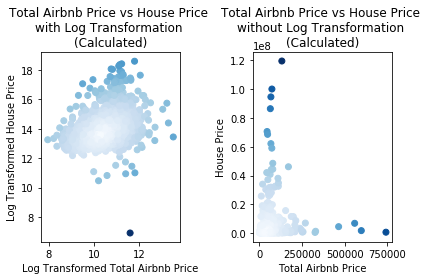

In [78]:
#Plot the outliers for with mahalnobis distance
column_values_log1 = merged1[['log_Total_airbnb_cal','log_Price_house']].values
mean_vector_log1   = np.asarray([merged1['log_Total_airbnb_cal'].mean(),merged1['log_Price_house'].mean()]).reshape((1,2))
mahalanobis_distances_log1 = spatial.distance.cdist(column_values_log1,mean_vector_log1,'mahalanobis')[:,0]

column_values1 = merged1[['Total_airbnb_cal','Price_house']].values
mean_vector1   = np.asarray([merged1['Total_airbnb_cal'].mean(),merged1['Price_house'].mean()]).reshape((1,2))
mahalanobis_distances1 = spatial.distance.cdist(column_values1,mean_vector1,'mahalanobis')[:,0]

plt.subplot(1,2,1)
plt.scatter(merged1['log_Total_airbnb_cal'],merged1['log_Price_house'],c=mahalanobis_distances_log1,cmap=plt.cm.Blues)
plt.xlabel('Log Transformed Total Airbnb Price')
plt.ylabel('Log Transformed House Price')
plt.title('Total Airbnb Price vs House Price \nwith Log Transformation \n(Calculated)')

plt.subplot(1,2,2)
plt.scatter(merged1['Total_airbnb_cal'],merged1['Price_house'],c=mahalanobis_distances1,cmap=plt.cm.Blues)
plt.xlabel('Total Airbnb Price')
plt.ylabel('House Price')
plt.title('Total Airbnb Price vs House Price \nwithout Log Transformation \n(Calculated)')
plt.tight_layout()
plt.show()

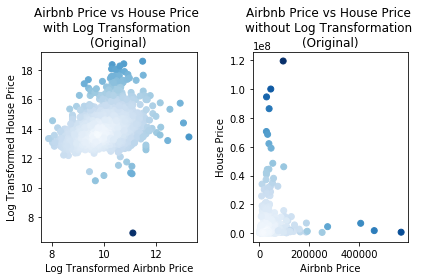

In [79]:
#Plot the outliers with mahalnobis distance
column_values_log2 = merged1[['log_Price_airbnb_original','log_Price_house']].values
mean_vector_log2   = np.asarray([merged1['log_Price_airbnb_original'].mean(),merged1['log_Price_house'].mean()]).reshape((1,2))
mahalanobis_distances_log2 = spatial.distance.cdist(column_values_log2,mean_vector_log2,'mahalanobis')[:,0]

column_values2 = merged1[['Price_airbnb_original','Price_house']].values
mean_vector2   = np.asarray([merged1['Price_airbnb_original'].mean(),merged1['Price_house'].mean()]).reshape((1,2))
mahalanobis_distances2 = spatial.distance.cdist(column_values1,mean_vector1,'mahalanobis')[:,0]

plt.subplot(1,2,1)
plt.scatter(merged1['log_Price_airbnb_original'],merged1['log_Price_house'],c=mahalanobis_distances_log2,cmap=plt.cm.Blues)
plt.xlabel('Log Transformed Airbnb Price')
plt.ylabel('Log Transformed House Price')
plt.title('Airbnb Price vs House Price \nwith Log Transformation \n(Original)')

plt.subplot(1,2,2)
plt.scatter(merged1['Price_airbnb_original'],merged1['Price_house'],c=mahalanobis_distances2,cmap=plt.cm.Blues)
plt.xlabel('Airbnb Price')
plt.ylabel('House Price')
plt.title('Airbnb Price vs House Price \nwithout Log Transformation \n(Original)')
plt.tight_layout()
plt.show()

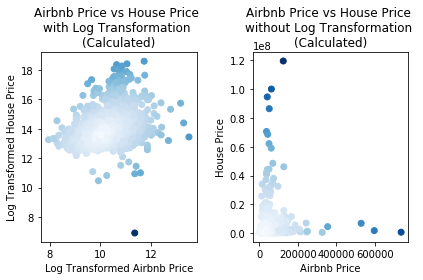

In [80]:
#Plot the outliers with mahalnobis distance
column_values_log3 = merged1[['log_Price_airbnb_cal','log_Price_house']].values
mean_vector_log3  = np.asarray([merged1['log_Price_airbnb_cal'].mean(),merged1['log_Price_house'].mean()]).reshape((1,2))
mahalanobis_distances_log3 = spatial.distance.cdist(column_values_log3,mean_vector_log3,'mahalanobis')[:,0]

column_values3 = merged1[['Price_airbnb_cal','Price_house']].values
mean_vector3   = np.asarray([merged1['Price_airbnb_cal'].mean(),merged1['Price_house'].mean()]).reshape((1,2))
mahalanobis_distances3 = spatial.distance.cdist(column_values1,mean_vector1,'mahalanobis')[:,0]

plt.subplot(1,2,1)
plt.scatter(merged1['log_Price_airbnb_cal'],merged1['log_Price_house'],c=mahalanobis_distances_log3,cmap=plt.cm.Blues)
plt.xlabel('Log Transformed Airbnb Price')
plt.ylabel('Log Transformed House Price')
plt.title('Airbnb Price vs House Price \nwith Log Transformation \n(Calculated)')

plt.subplot(1,2,2)
plt.scatter(merged1['Price_airbnb_cal'],merged1['Price_house'],c=mahalanobis_distances3,cmap=plt.cm.Blues)
plt.xlabel('Airbnb Price')
plt.ylabel('House Price')
plt.title('Airbnb Price vs House Price \nwithout Log Transformation \n(Calculated)')
plt.tight_layout()
plt.show()

Now, abbreviations of the sub-dataframes will be introduced to avoid confusion.
- With outliers (O)
- With outliers removed (OR)
- With log transfomation (LT)
- Without log transformation (W/LT)
- With outliers and with log transformation (OLT)
- With outliers and without log transformation (OW/LT)
- With outliers removed and with log transformation (ORLT)
- With outliers removed and without log transformation (ORW/LT)

In [81]:
#A new dataframe will be created with outliers and the results can be compared later. 
merged_with_outlier = merged1.copy(deep=False)

In [82]:
#Remove the outliers
merged1 = merged1[merged1['is_outlier_house'] == 0]
merged1 = merged1[merged1['is_outlier_airbnb_original'] == 0]
merged1 = merged1[merged1['is_outlier_airbnb_cal'] == 0]
merged1 = merged1[merged1['is_outlier_total_airbnb_original'] == 0]
merged1 = merged1[merged1['is_outlier_total_airbnb_cal'] == 0]
merged1 = merged1[merged1['is_outlier_house1'] == 0]
merged1 = merged1[merged1['is_outlier_airbnb_original1'] == 0]
merged1 = merged1[merged1['is_outlier_airbnb_cal1'] == 0]
merged1 = merged1[merged1['is_outlier_total_airbnb_original1'] == 0]
merged1 = merged1[merged1['is_outlier_total_airbnb_cal1'] == 0]

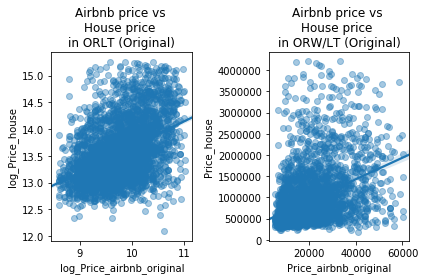

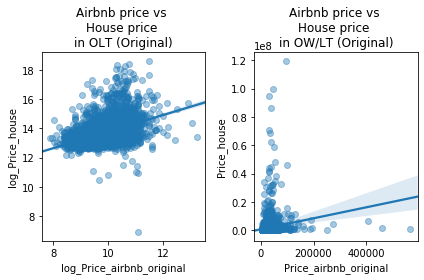

In [83]:
#Visualise the regressions of all sub-dataframes
plt.subplot(1,2,1)
sns.regplot(x='log_Price_airbnb_original',y='log_Price_house',data=merged1,scatter_kws={'alpha':0.4})
plt.title('Airbnb price vs \nHouse price \nin ORLT (Original)')

plt.subplot(1,2,2)
sns.regplot(x='Price_airbnb_original',y='Price_house',data=merged1,scatter_kws={'alpha':0.4})
plt.title('Airbnb price vs \nHouse price \nin ORW/LT (Original)')
plt.tight_layout()
plt.show()

plt.subplot(1,2,1)
sns.regplot(x='log_Price_airbnb_original',y='log_Price_house',data=merged_with_outlier,scatter_kws={'alpha':0.4})
plt.title('Airbnb price vs \nHouse price \nin OLT (Original)')

plt.subplot(1,2,2)
sns.regplot(x='Price_airbnb_original',y='Price_house',data=merged_with_outlier,scatter_kws={'alpha':0.4})
plt.title('Airbnb price vs \nHouse price \nin OW/LT (Original)')
plt.tight_layout()
plt.show()

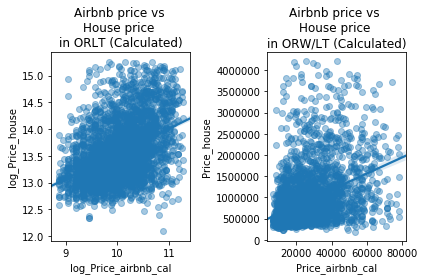

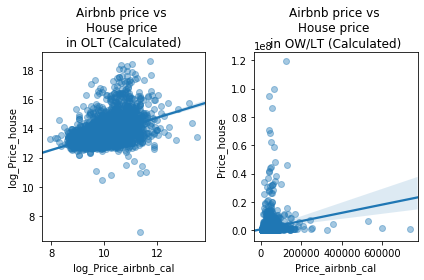

In [84]:
plt.subplot(1,2,1)
sns.regplot(x='log_Price_airbnb_cal',y='log_Price_house',data=merged1,scatter_kws={'alpha':0.4})
plt.title('Airbnb price vs \nHouse price \nin ORLT (Calculated)')

plt.subplot(1,2,2)
sns.regplot(x='Price_airbnb_cal',y='Price_house',data=merged1,scatter_kws={'alpha':0.4})
plt.title('Airbnb price vs \nHouse price \nin ORW/LT (Calculated)')
plt.tight_layout()
plt.show()

plt.subplot(1,2,1)
sns.regplot(x='log_Price_airbnb_cal',y='log_Price_house',data=merged_with_outlier,scatter_kws={'alpha':0.4})
plt.title('Airbnb price vs \nHouse price \nin OLT (Calculated)')

plt.subplot(1,2,2)
sns.regplot(x='Price_airbnb_cal',y='Price_house',data=merged_with_outlier,scatter_kws={'alpha':0.4})
plt.title('Airbnb price vs \nHouse price \nin OW/LT (Calculated)')
plt.tight_layout()
plt.show()

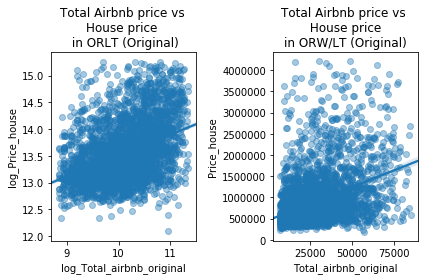

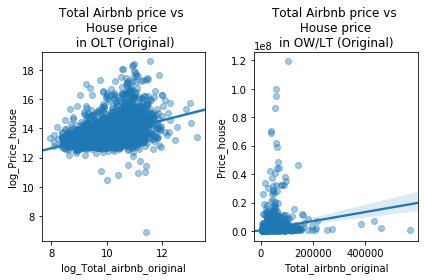

In [85]:
plt.subplot(1,2,1)
sns.regplot(x='log_Total_airbnb_original',y='log_Price_house',data=merged1,scatter_kws={'alpha':0.4})
plt.title('Total Airbnb price vs \nHouse price \n in ORLT (Original)')

plt.subplot(1,2,2)
sns.regplot(x='Total_airbnb_original',y='Price_house',data=merged1,scatter_kws={'alpha':0.4})
plt.title('Total Airbnb price vs \n House price \nin ORW/LT (Original)')
plt.tight_layout()
plt.show()

plt.subplot(1,2,1)
sns.regplot(x='log_Total_airbnb_original',y='log_Price_house',data=merged_with_outlier,scatter_kws={'alpha':0.4})
plt.title('Total Airbnb price vs \nHouse price \n in OLT (Original)')

plt.subplot(1,2,2)
sns.regplot(x='Total_airbnb_original',y='Price_house',data=merged_with_outlier,scatter_kws={'alpha':0.4})
plt.title('Total Airbnb price vs \n House price \nin OW/LT (Original)')
plt.tight_layout()
plt.show()

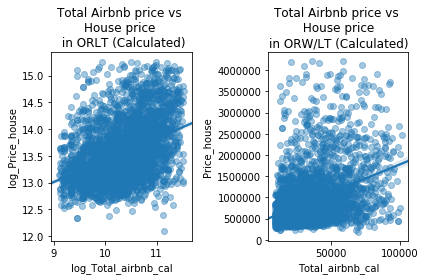

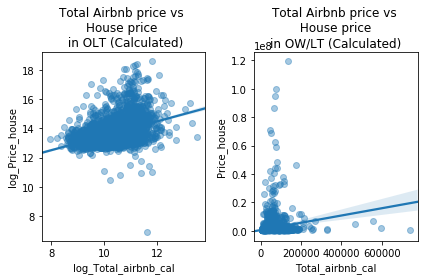

In [86]:
plt.subplot(1,2,1)
sns.regplot(x='log_Total_airbnb_cal',y='log_Price_house',data=merged1,scatter_kws={'alpha':0.4})
plt.title('Total Airbnb price vs \nHouse price \n in ORLT (Calculated)')

plt.subplot(1,2,2)
sns.regplot(x='Total_airbnb_cal',y='Price_house',data=merged1,scatter_kws={'alpha':0.4})
plt.title('Total Airbnb price vs \n House price \nin ORW/LT (Calculated)')
plt.tight_layout()
plt.show()

plt.subplot(1,2,1)
sns.regplot(x='log_Total_airbnb_cal',y='log_Price_house',data=merged_with_outlier,scatter_kws={'alpha':0.4})
plt.title('Total Airbnb price vs \nHouse price \n in OLT (Calculated)')

plt.subplot(1,2,2)
sns.regplot(x='Total_airbnb_cal',y='Price_house',data=merged_with_outlier,scatter_kws={'alpha':0.4})
plt.title('Total Airbnb price vs \n House price \nin OW/LT (Calculated)')
plt.tight_layout()
plt.show()

The regression plots showed that by removing the outliers, the datapoints are more evenly distributed arount the regression line.

# 6. Principe Component Analysis (PCA) 

    6.1 PCA

In [87]:
#Convert the columns to numpy arrays
merged_PCA = merged1[['Postcode','Total_airbnb_original','Price_airbnb_original','Total_airbnb_cal',
                      'Price_airbnb_cal','Price_house','log_Price_house','log_Total_airbnb_original',
                      'log_Price_airbnb_original','log_Total_airbnb_cal','log_Price_airbnb_cal']]
column_values_np = np.asarray(merged_PCA.columns.values)
merged_np = merged_PCA.to_numpy()
merged_np_filtered = merged_np[:,1::]

In [88]:
#Convert the columns to numpy arrays
merged_with_outlier_PCA = merged_with_outlier[['Postcode','Total_airbnb_original','Price_airbnb_original',
                                               'Total_airbnb_cal', 'Price_airbnb_cal','Price_house',
                                               'log_Price_house','log_Total_airbnb_original',
                                               'log_Price_airbnb_original','log_Total_airbnb_cal',
                                               'log_Price_airbnb_cal']]
column_values_np = np.asarray(merged_with_outlier_PCA.columns.values)
merged_outlier_np = merged_with_outlier_PCA.to_numpy()
merged__outlier_np_filtered = merged_np[:,1::]

In [89]:
#Assign 10 principle components
pca=PCA(n_components=10)
pca.fit(merged_np_filtered)
merged_projected=pca.transform(merged_np_filtered)
print(pca.explained_variance_ratio_)

pca1=PCA(n_components=10)
pca1.fit(merged__outlier_np_filtered)
merged_outlier_projected=pca.transform(merged__outlier_np_filtered)
print(pca1.explained_variance_ratio_)

[9.98227695e-01 1.69727518e-03 6.09934023e-05 1.40367780e-05
 2.03763041e-13 7.63523010e-14 1.96638964e-14 3.07404363e-15
 2.17136490e-16 6.34531664e-35]
[9.98227695e-01 1.69727518e-03 6.09934023e-05 1.40367780e-05
 2.03763041e-13 7.63523010e-14 1.96638964e-14 3.07404363e-15
 2.17136490e-16 6.34531664e-35]


In [90]:
print(pca.components_)
print(pca1.components_)

[[ 9.25631240e-03  6.31732750e-03  1.10360380e-02  8.09705310e-03
   9.99843516e-01  8.04392121e-07  2.95198096e-07  2.93859211e-07
   2.89751612e-07  2.87845431e-07]
 [ 5.33056924e-01  3.33070446e-01  6.40643099e-01  4.40656621e-01
  -1.76792047e-02  1.18106858e-06  1.78745560e-05  1.56857190e-05
   1.75269876e-05  1.58227516e-05]
 [ 4.82476188e-01 -4.85380545e-01  3.06095876e-01 -6.61760856e-01
   5.80675488e-04 -4.65544496e-07  1.78960603e-05 -1.83957090e-05
   1.05838176e-05 -1.95443568e-05]
 [-4.82681430e-01 -6.35161314e-01  4.95741807e-01  3.43261924e-01
   2.29972683e-04 -5.35060138e-07 -1.51105866e-05 -2.58437240e-05
   9.85402231e-06  9.89175022e-06]
 [ 2.17126653e-05  1.86759837e-05  1.55811006e-05  1.25444193e-05
   1.03548974e-07 -1.50352337e-01 -5.40284856e-01 -4.53382771e-01
  -5.21913601e-01 -4.55561965e-01]
 [-3.24016099e-06 -7.83628619e-07 -2.69331136e-06 -2.36778890e-07
   7.75817423e-07 -9.87355252e-01  1.07338136e-01  3.83179920e-02
   1.00379483e-01  4.54293090e-02

In [91]:
print(merged_projected.shape)
print(merged_outlier_projected.shape)

(3552, 10)
(3552, 10)


    6.2 PCA visualisations

        6.2.1 Compare Total_airbnb (Original and Calculated) and Price_house first. 

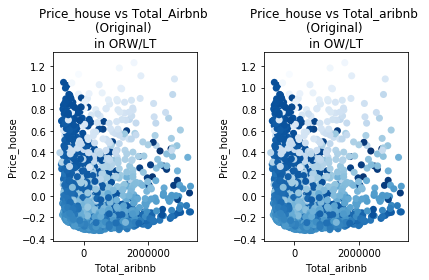

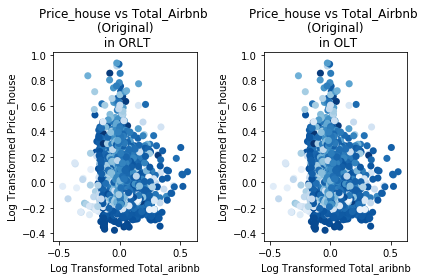

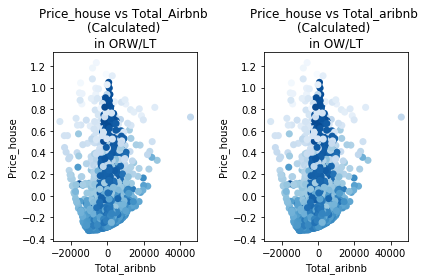

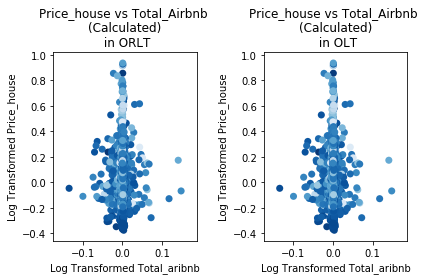

In [92]:
#Plot the visualisation of PCA with colour mapping of the dataset
coulour_mapping  = np.asarray(merged_projected[:,-1],'f')
coulour_mapping1 = np.asarray(merged_outlier_projected[:,-1],'f')

coulour_mapping_log  = np.asarray(merged_projected[:,-1],'f')
coulour_mapping_log1 = np.asarray(merged_outlier_projected[:,-1],'f')

plt.subplot(1,2,1)
plt.scatter(merged_projected[:,0],merged_projected[:,4],s=50,c=coulour_mapping,linewidths=0,cmap=plt.cm.Blues)
plt.title('Price_house vs Total_Airbnb \n(Original) \nin ORW/LT')
plt.xlabel('Total_aribnb')
plt.ylabel('Price_house')

plt.subplot(1,2,2)
plt.scatter(merged_outlier_projected[:,0],merged_outlier_projected[:,4],s=50,c=coulour_mapping1,linewidths=0,cmap=plt.cm.Blues)
plt.title('Price_house vs Total_aribnb \n(Original) \nin OW/LT')
plt.xlabel('Total_aribnb')
plt.ylabel('Price_house')
plt.tight_layout()
plt.show()

plt.subplot(1,2,1)
plt.scatter(merged_projected[:,6],merged_projected[:,5],s=50,c=coulour_mapping_log,linewidths=0,cmap=plt.cm.Blues)
plt.title('Price_house vs Total_Airbnb \n(Original)\n in ORLT')
plt.xlabel('Log Transformed Total_aribnb')
plt.ylabel('Log Transformed Price_house')

plt.subplot(1,2,2)
plt.scatter(merged_outlier_projected[:,6],merged_outlier_projected[:,5],s=50,c=coulour_mapping_log1,linewidths=0,cmap=plt.cm.Blues)
plt.title('Price_house vs Total_Airbnb \n(Original)\n in OLT')
plt.xlabel('Log Transformed Total_aribnb')
plt.ylabel('Log Transformed Price_house')
plt.tight_layout()
plt.show()

plt.subplot(1,2,1)
plt.scatter(merged_projected[:,2],merged_projected[:,4],s=50,c=coulour_mapping,linewidths=0,cmap=plt.cm.Blues)
plt.title('Price_house vs Total_Airbnb \n(Calculated) \nin ORW/LT')
plt.xlabel('Total_aribnb')
plt.ylabel('Price_house')

plt.subplot(1,2,2)
plt.scatter(merged_outlier_projected[:,2],merged_outlier_projected[:,4],s=50,c=coulour_mapping1,linewidths=0,cmap=plt.cm.Blues)
plt.title('Price_house vs Total_aribnb \n(Calculated) \nin OW/LT')
plt.xlabel('Total_aribnb')
plt.ylabel('Price_house')
plt.tight_layout()
plt.show()

plt.subplot(1,2,1)
plt.scatter(merged_projected[:,8],merged_projected[:,5],s=50,c=coulour_mapping_log,linewidths=0,cmap=plt.cm.Blues)
plt.title('Price_house vs Total_Airbnb \n(Calculated)\n in ORLT')
plt.xlabel('Log Transformed Total_aribnb')
plt.ylabel('Log Transformed Price_house')

plt.subplot(1,2,2)
plt.scatter(merged_outlier_projected[:,8],merged_outlier_projected[:,5],s=50,c=coulour_mapping_log1,linewidths=0,cmap=plt.cm.Blues)
plt.title('Price_house vs Total_Airbnb \n(Calculated)\n in OLT')
plt.xlabel('Log Transformed Total_aribnb')
plt.ylabel('Log Transformed Price_house')
plt.tight_layout()
plt.show()

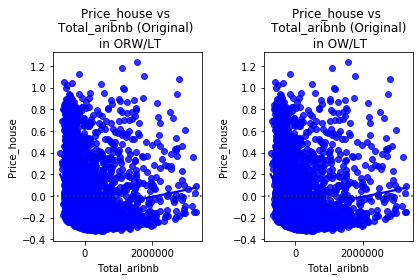

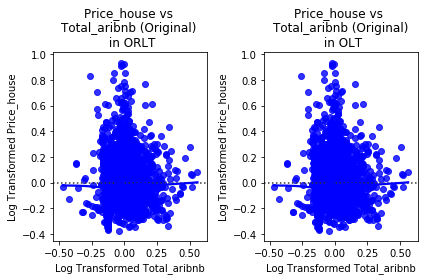

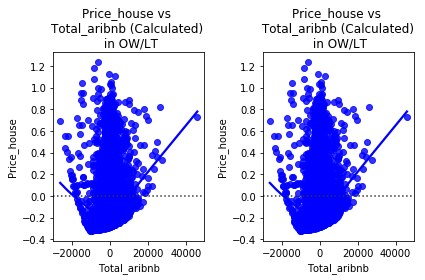

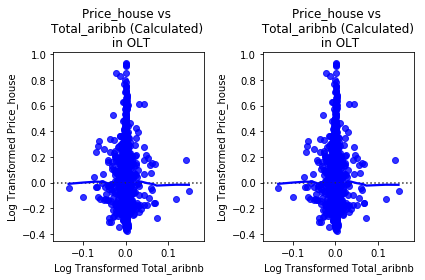

In [93]:
#Plot the residual plots 
plt.subplot(1,2,1)
sns.residplot(merged_projected[:,0],merged_projected[:,4],lowess=True,color='b')
plt.title('Price_house vs \nTotal_aribnb (Original) \n in ORW/LT')
plt.xlabel('Total_aribnb')
plt.ylabel('Price_house')

plt.subplot(1,2,2)
sns.residplot(merged_outlier_projected[:,0],merged_outlier_projected[:,4],lowess=True,color='b')
plt.title('Price_house vs \nTotal_aribnb (Original)\n in OW/LT')
plt.xlabel('Total_aribnb')
plt.ylabel('Price_house')
plt.tight_layout()
plt.show()

plt.subplot(1,2,1)
sns.residplot(merged_projected[:,6],merged_projected[:,5],lowess=True,color='b')
plt.title('Price_house vs \nTotal_aribnb (Original) \n in ORLT')
plt.xlabel('Log Transformed Total_aribnb')
plt.ylabel('Log Transformed Price_house')

plt.subplot(1,2,2)
sns.residplot(merged_outlier_projected[:,6],merged_outlier_projected[:,5],lowess=True,color='b')
plt.title('Price_house vs \nTotal_aribnb (Original)\n in OLT')
plt.xlabel('Log Transformed Total_aribnb')
plt.ylabel('Log Transformed Price_house')
plt.tight_layout()
plt.show()

plt.subplot(1,2,1)
sns.residplot(merged_projected[:,2],merged_projected[:,4],lowess=True,color='b')
plt.title('Price_house vs \nTotal_aribnb (Calculated) \n in OW/LT')
plt.xlabel('Total_aribnb')
plt.ylabel('Price_house')

plt.subplot(1,2,2)
sns.residplot(merged_outlier_projected[:,2],merged_outlier_projected[:,4],lowess=True,color='b')
plt.title('Price_house vs \n Total_aribnb (Calculated) \n in OW/LT')
plt.xlabel('Total_aribnb')
plt.ylabel('Price_house')
plt.tight_layout()
plt.show()

plt.subplot(1,2,1)
sns.residplot(merged_projected[:,8],merged_projected[:,5],lowess=True,color='b')
plt.title('Price_house vs \nTotal_aribnb (Calculated) \n in OLT')
plt.xlabel('Log Transformed Total_aribnb')
plt.ylabel('Log Transformed Price_house')

plt.subplot(1,2,2)
sns.residplot(merged_outlier_projected[:,8],merged_outlier_projected[:,5],lowess=True,color='b')
plt.title('Price_house vs \n Total_aribnb (Calculated) \n in OLT')
plt.xlabel('Log Transformed Total_aribnb')
plt.ylabel('Log Transformed Price_house')
plt.tight_layout()
plt.show()

    6.2.2 Compare Price_airbnb (Original and Calculated) and Price_house

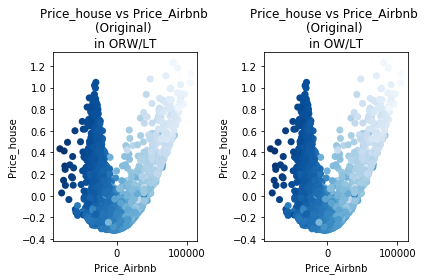

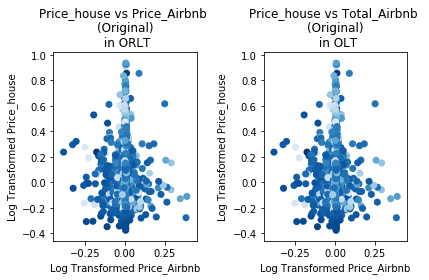

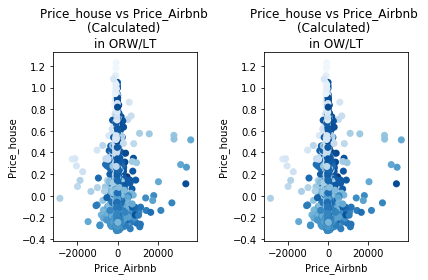

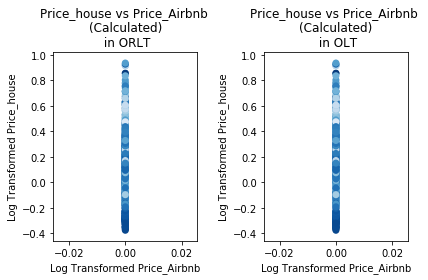

In [94]:
#Plot the visualisation of PCA with colour mapping of the dataset
plt.subplot(1,2,1)
plt.scatter(merged_projected[:,1],merged_projected[:,4],s=50,c=coulour_mapping,linewidths=0,cmap=plt.cm.Blues)
plt.title('Price_house vs Price_Airbnb \n(Original) \nin ORW/LT')
plt.xlabel('Price_Airbnb')
plt.ylabel('Price_house')

plt.subplot(1,2,2)
plt.scatter(merged_outlier_projected[:,1],merged_outlier_projected[:,4],s=50,c=coulour_mapping1,linewidths=0,cmap=plt.cm.Blues)
plt.title('Price_house vs Price_Airbnb \n(Original) \nin OW/LT')
plt.xlabel('Price_Airbnb')
plt.ylabel('Price_house')
plt.tight_layout()
plt.show()

plt.subplot(1,2,1)
plt.scatter(merged_projected[:,7],merged_projected[:,5],s=50,c=coulour_mapping_log,linewidths=0,cmap=plt.cm.Blues)
plt.title('Price_house vs Price_Airbnb \n(Original)\n in ORLT')
plt.xlabel('Log Transformed Price_Airbnb')
plt.ylabel('Log Transformed Price_house')

plt.subplot(1,2,2)
plt.scatter(merged_outlier_projected[:,7],merged_outlier_projected[:,5],s=50,c=coulour_mapping_log1,linewidths=0,cmap=plt.cm.Blues)
plt.title('Price_house vs Total_Airbnb \n(Original)\n in OLT')
plt.xlabel('Log Transformed Price_Airbnb')
plt.ylabel('Log Transformed Price_house')
plt.tight_layout()
plt.show()

plt.subplot(1,2,1)
plt.scatter(merged_projected[:,3],merged_projected[:,4],s=50,c=coulour_mapping,linewidths=0,cmap=plt.cm.Blues)
plt.title('Price_house vs Price_Airbnb \n(Calculated) \nin ORW/LT')
plt.xlabel('Price_Airbnb')
plt.ylabel('Price_house')

plt.subplot(1,2,2)
plt.scatter(merged_outlier_projected[:,3],merged_outlier_projected[:,4],s=50,c=coulour_mapping1,linewidths=0,cmap=plt.cm.Blues)
plt.title('Price_house vs Price_Airbnb \n(Calculated) \nin OW/LT')
plt.xlabel('Price_Airbnb')
plt.ylabel('Price_house')
plt.tight_layout()
plt.show()

plt.subplot(1,2,1)
plt.scatter(merged_projected[:,9],merged_projected[:,5],s=50,c=coulour_mapping_log,linewidths=0,cmap=plt.cm.Blues)
plt.title('Price_house vs Price_Airbnb \n(Calculated)\n in ORLT')
plt.xlabel('Log Transformed Price_Airbnb')
plt.ylabel('Log Transformed Price_house')

plt.subplot(1,2,2)
plt.scatter(merged_outlier_projected[:,9],merged_outlier_projected[:,5],s=50,c=coulour_mapping_log1,linewidths=0,cmap=plt.cm.Blues)
plt.title('Price_house vs Price_Airbnb \n(Calculated)\n in OLT')
plt.xlabel('Log Transformed Price_Airbnb')
plt.ylabel('Log Transformed Price_house')
plt.tight_layout()
plt.show()

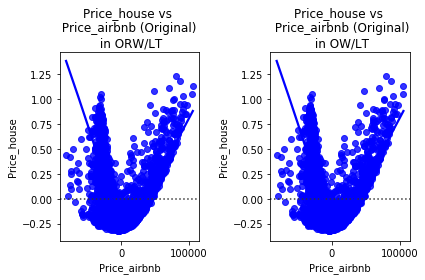

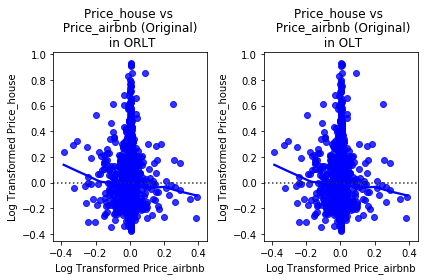

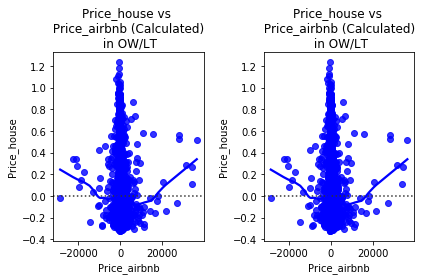

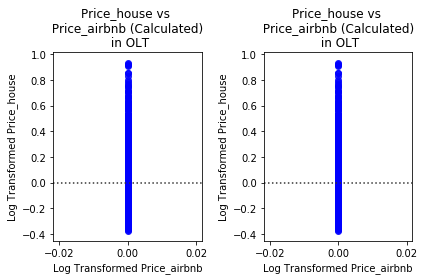

In [95]:
#Plot the residual plots 
plt.subplot(1,2,1)
sns.residplot(merged_projected[:,1],merged_projected[:,4],lowess=True,color='b')
plt.title('Price_house vs \n Price_airbnb (Original) \n in ORW/LT')
plt.xlabel('Price_airbnb')
plt.ylabel('Price_house')

plt.subplot(1,2,2)
sns.residplot(merged_outlier_projected[:,1],merged_outlier_projected[:,4],lowess=True,color='b')
plt.title('Price_house vs \n Price_airbnb (Original)\n in OW/LT')
plt.xlabel('Price_airbnb')
plt.ylabel('Price_house')
plt.tight_layout()
plt.show()

plt.subplot(1,2,1)
sns.residplot(merged_projected[:,7],merged_projected[:,5],lowess=True,color='b')
plt.title('Price_house vs \n Price_airbnb (Original) \n in ORLT')
plt.xlabel('Log Transformed Price_airbnb')
plt.ylabel('Log Transformed Price_house')

plt.subplot(1,2,2)
sns.residplot(merged_outlier_projected[:,7],merged_outlier_projected[:,5],lowess=True,color='b')
plt.title('Price_house vs \n Price_airbnb (Original)\n in OLT')
plt.xlabel('Log Transformed Price_airbnb')
plt.ylabel('Log Transformed Price_house')
plt.tight_layout()
plt.show()

plt.subplot(1,2,1)
sns.residplot(merged_projected[:,3],merged_projected[:,4],lowess=True,color='b')
plt.title('Price_house vs \n Price_airbnb (Calculated) \n in OW/LT')
plt.xlabel('Price_airbnb')
plt.ylabel('Price_house')

plt.subplot(1,2,2)
sns.residplot(merged_outlier_projected[:,3],merged_outlier_projected[:,4],lowess=True,color='b')
plt.title('Price_house vs \n Price_airbnb (Calculated) \n in OW/LT')
plt.xlabel('Price_airbnb')
plt.ylabel('Price_house')
plt.tight_layout()
plt.show()

plt.subplot(1,2,1)
sns.residplot(merged_projected[:,9],merged_projected[:,5],lowess=True,color='b')
plt.title('Price_house vs \n Price_airbnb (Calculated) \n in OLT')
plt.xlabel('Log Transformed Price_airbnb')
plt.ylabel('Log Transformed Price_house')

plt.subplot(1,2,2)
sns.residplot(merged_outlier_projected[:,9],merged_outlier_projected[:,5],lowess=True,color='b')
plt.title('Price_house vs \n Price_airbnb (Calculated) \n in OLT')
plt.xlabel('Log Transformed Price_airbnb')
plt.ylabel('Log Transformed Price_house')
plt.tight_layout()
plt.show()

All the residual plots look quite reasonable, except when compared with OALP. As this was assigned the smallest varaiance (almost 0) being the last column in the dataset, both regression plots and residual plots obtained a vertical line. Also, it is worth noting that the regression is now nonlinear. 

As PCA eliminated one of the most features in the dataset - Postcode, it is not appropriate for this analysis. 

# 7. Investigate the correlations further

    7.1 Pairplots

Text(0.5, 1, 'Pairplot with outliers removed')

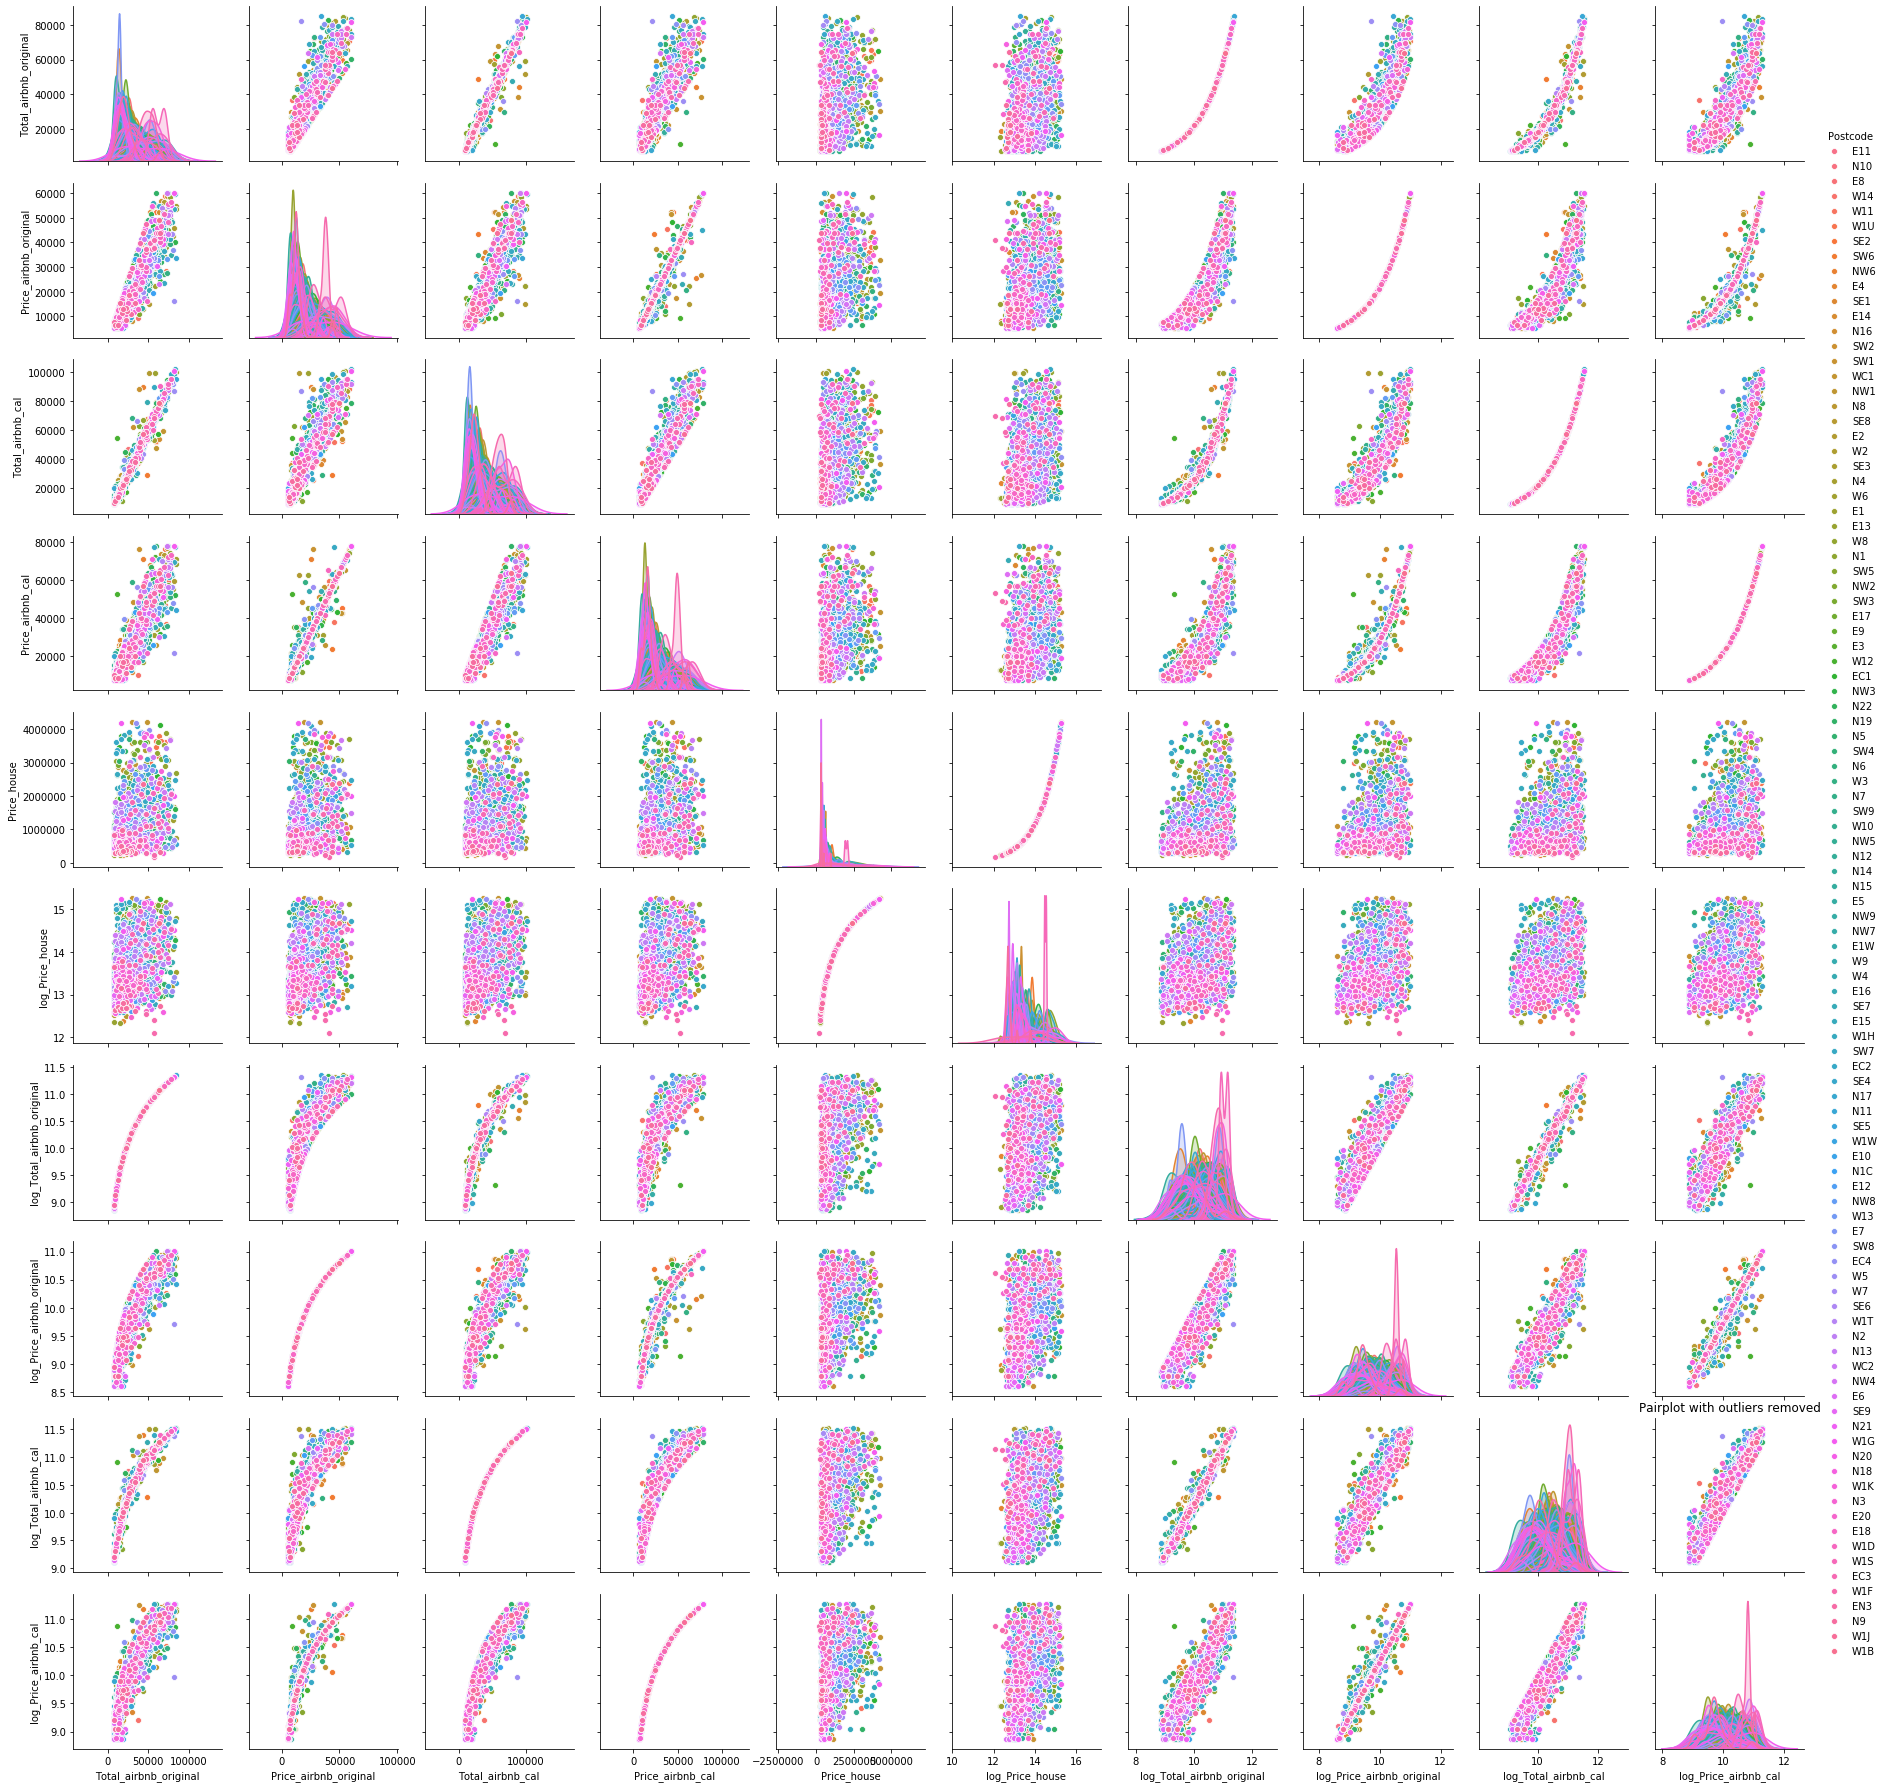

In [228]:
#Visualise all the features in both O and OR sub-dataframes.
sns.pairplot(merged1,hue='Postcode')
plt.title('Pairplot with outliers removed')

Text(0.5, 1, 'Pairplot with outliers')

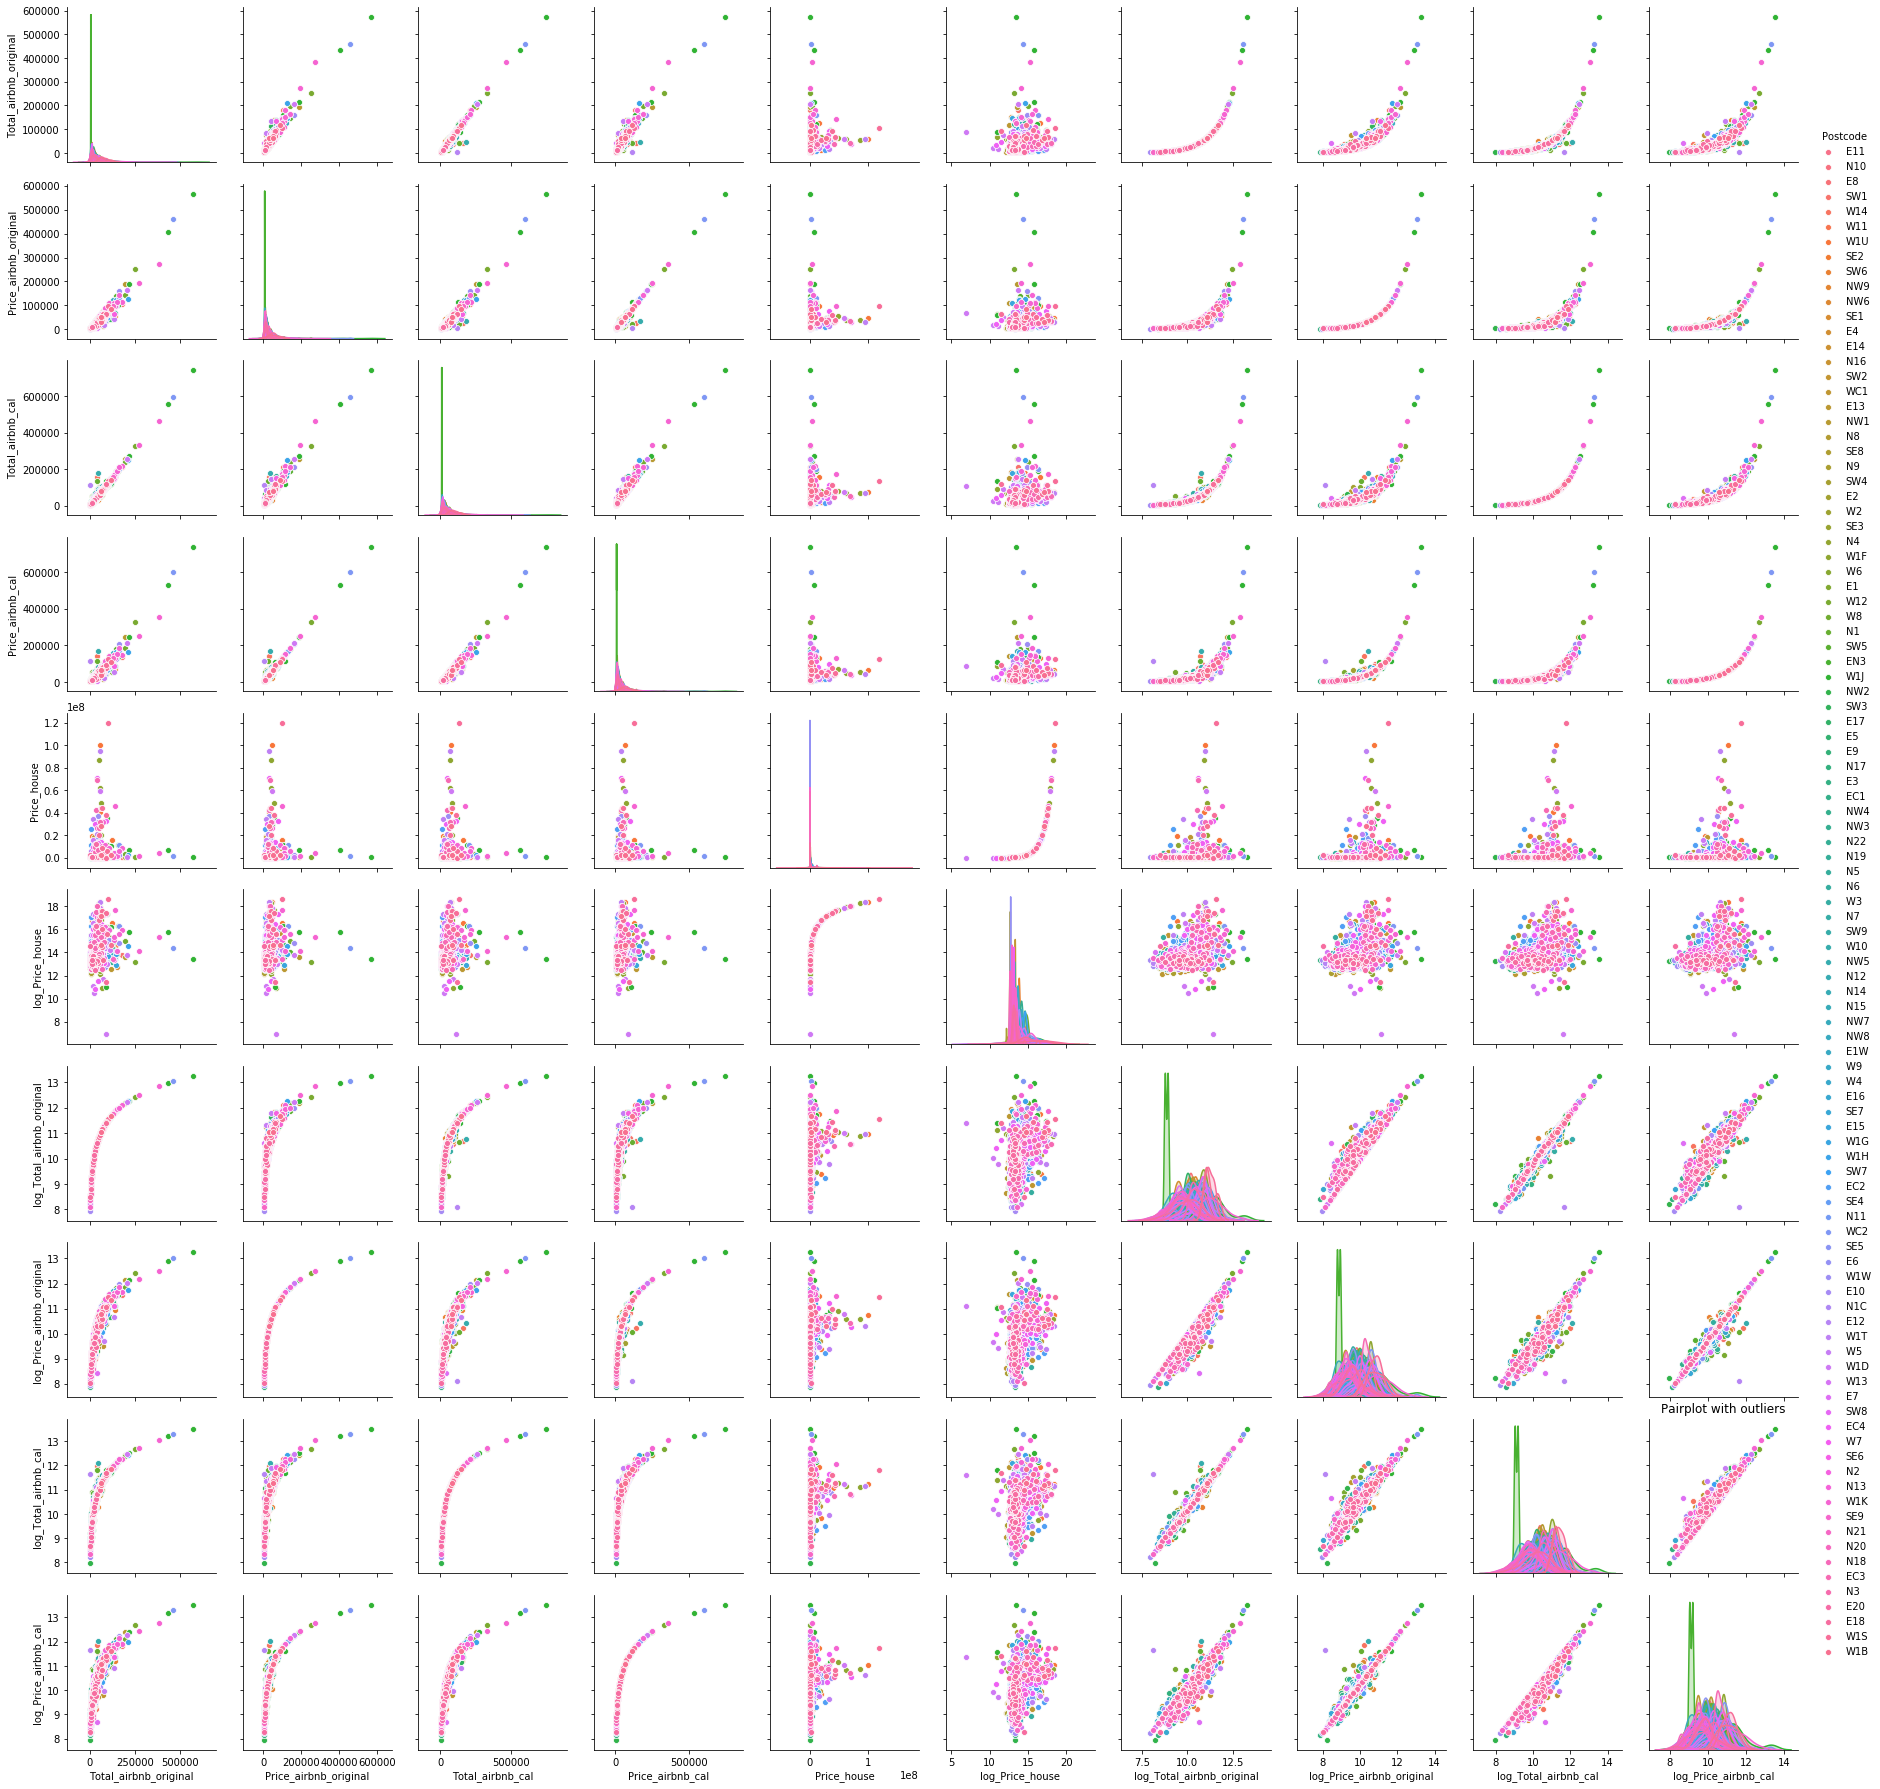

In [229]:
sns.pairplot(merged_with_outlier,hue='Postcode')
plt.title('Pairplot with outliers')

An overview of all the features showed that the datapoints are evenly distributed and showing more linear relationship when outliers are removed. 

    7.2 Residual plots

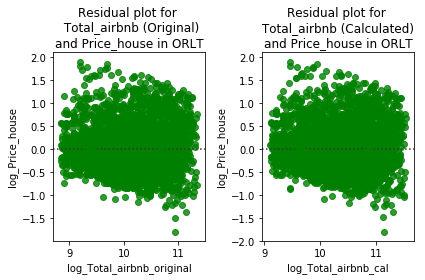

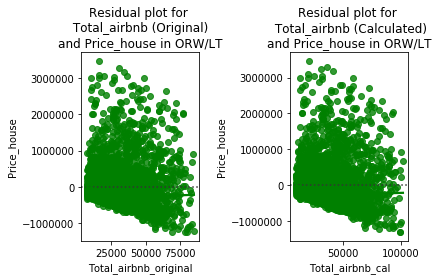

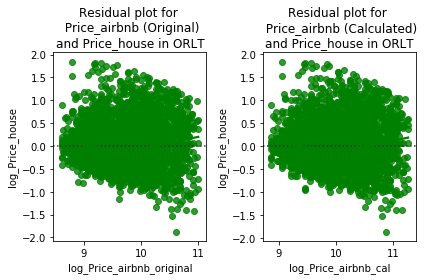

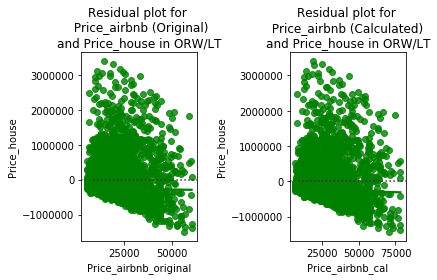

In [96]:
#Plot the residual plots for all sub-dataframes
plt.subplot(1,2,1)
sns.residplot(merged1['log_Total_airbnb_original'],merged1['log_Price_house'],lowess=True,color='g')
plt.title('Residual plot for \n Total_airbnb (Original)\nand Price_house in ORLT')

plt.subplot(1,2,2)
sns.residplot(merged1['log_Total_airbnb_cal'],merged1['log_Price_house'],lowess=True,color='g')
plt.title('Residual plot for \n Total_airbnb (Calculated) \nand Price_house in ORLT')
plt.tight_layout()
plt.show()

plt.subplot(1,2,1)
sns.residplot(merged1['Total_airbnb_original'],merged1['Price_house'],lowess=True,color='g')
plt.title('Residual plot for \n Total_airbnb (Original) \nand Price_house in ORW/LT')

plt.subplot(1,2,2)
sns.residplot(merged1['Total_airbnb_cal'],merged1['Price_house'],lowess=True,color='g')
plt.title('Residual plot for \n Total_airbnb (Calculated)\nand Price_house in ORW/LT')
plt.tight_layout()
plt.show()

plt.subplot(1,2,1)
sns.residplot(merged1['log_Price_airbnb_original'],merged1['log_Price_house'],lowess=True,color='g')
plt.title('Residual plot for \n Price_airbnb (Original)\nand Price_house in ORLT')

plt.subplot(1,2,2)
sns.residplot(merged1['log_Price_airbnb_cal'],merged1['log_Price_house'],lowess=True,color='g')
plt.title('Residual plot for \n Price_airbnb (Calculated)\nand Price_house in ORLT')
plt.tight_layout()
plt.show()

plt.subplot(1,2,1)
sns.residplot(merged1['Price_airbnb_original'],merged1['Price_house'],lowess=True,color='g')
plt.title('Residual plot for \n Price_airbnb (Original)\nand Price_house in ORW/LT')

plt.subplot(1,2,2)
sns.residplot(merged1['Price_airbnb_cal'],merged1['Price_house'],lowess=True,color='g')
plt.title('Residual plot for \n Price_airbnb (Calculated) \nand Price_house in ORW/LT')
plt.tight_layout()
plt.show()

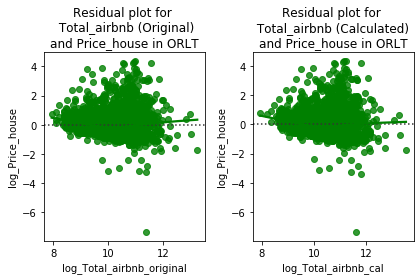

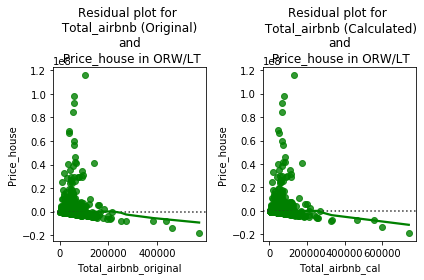

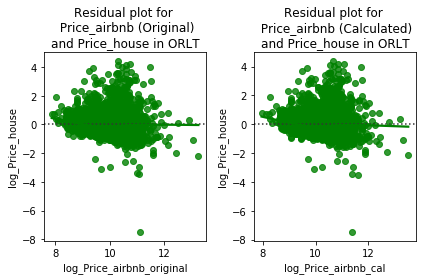

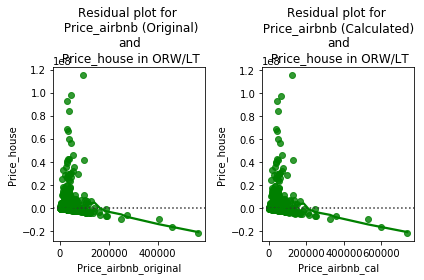

In [97]:
#Plot the residual plots for all sub-dataframes
plt.subplot(1,2,1)
sns.residplot(merged_with_outlier['log_Total_airbnb_original'],merged_with_outlier['log_Price_house'],lowess=True,color='g')
plt.title('Residual plot for \n Total_airbnb (Original)\nand Price_house in ORLT')

plt.subplot(1,2,2)
sns.residplot(merged_with_outlier['log_Total_airbnb_cal'],merged_with_outlier['log_Price_house'],lowess=True,color='g')
plt.title('Residual plot for \n Total_airbnb (Calculated) \nand Price_house in ORLT')
plt.tight_layout()
plt.show()

plt.subplot(1,2,1)
sns.residplot(merged_with_outlier['Total_airbnb_original'],merged_with_outlier['Price_house'],lowess=True,color='g')
plt.title('Residual plot for \n Total_airbnb (Original) \nand\n Price_house in ORW/LT')

plt.subplot(1,2,2)
sns.residplot(merged_with_outlier['Total_airbnb_cal'],merged_with_outlier['Price_house'],lowess=True,color='g')
plt.title('Residual plot for \n Total_airbnb (Calculated)\nand\n Price_house in ORW/LT')
plt.tight_layout()
plt.show()

plt.subplot(1,2,1)
sns.residplot(merged_with_outlier['log_Price_airbnb_original'],merged_with_outlier['log_Price_house'],lowess=True,color='g')
plt.title('Residual plot for \n Price_airbnb (Original)\nand Price_house in ORLT')

plt.subplot(1,2,2)
sns.residplot(merged_with_outlier['log_Price_airbnb_cal'],merged_with_outlier['log_Price_house'],lowess=True,color='g')
plt.title('Residual plot for \n Price_airbnb (Calculated)\nand Price_house in ORLT')
plt.tight_layout()
plt.show()

plt.subplot(1,2,1)
sns.residplot(merged_with_outlier['Price_airbnb_original'],merged_with_outlier['Price_house'],lowess=True,color='g')
plt.title('Residual plot for \n Price_airbnb (Original)\nand\n Price_house in ORW/LT')

plt.subplot(1,2,2)
sns.residplot(merged_with_outlier['Price_airbnb_cal'],merged_with_outlier['Price_house'],lowess=True,color='g')
plt.title('Residual plot for \n Price_airbnb (Calculated) \nand\n Price_house in ORW/LT')
plt.tight_layout()
plt.show()

As the above graphs show, outliers have heavily impacted the residual values. OLT also has less residual values than OW/LT.

Overall, ORLT has the best residual values. 

    7.3 Correlation heatmap

In [99]:
#Correlation heatmap
correlation  = merged1.corr()
correlation1 = merged_with_outlier.corr()

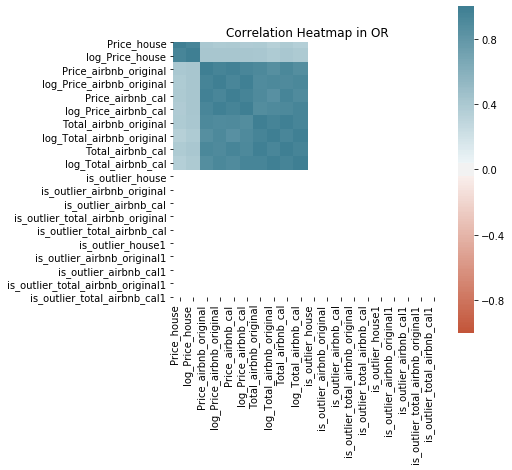

In [102]:
plt.figure(figsize=(6,6))
sns.heatmap(correlation,vmin=-1,vmax=1,cmap=sns.diverging_palette(20, 220, n=200),square=True)
plt.title('Correlation Heatmap in OR')
plt.xticks(horizontalalignment='right')
plt.show()

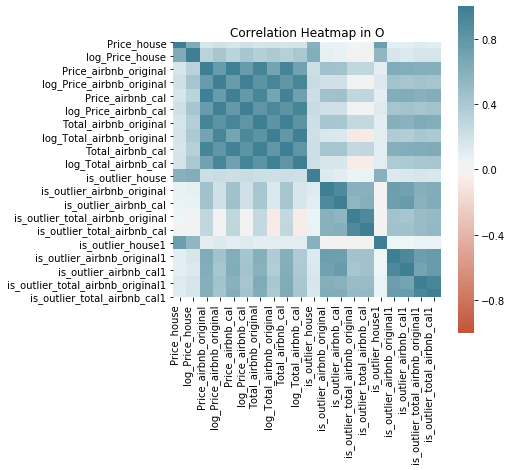

In [103]:
plt.figure(figsize=(6,6))
sns.heatmap(correlation1,vmin=-1,vmax=1,cmap=sns.diverging_palette(20, 220, n=200),square=True)
plt.title('Correlation Heatmap in O')
plt.xticks(horizontalalignment='right')
plt.show()

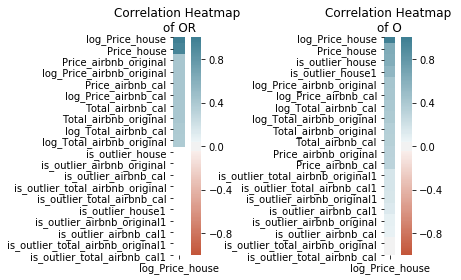

In [105]:
#Restricting to house price and sort the values from the most to the least
correlation_house = correlation[['log_Price_house']]
correlation_house = correlation_house.sort_values(by='log_Price_house',ascending=False)

correlation_house1 = correlation1[['log_Price_house']]
correlation_house1 = correlation_house1.sort_values(by='log_Price_house',ascending=False)

plt.subplot(1,2,1)
sns.heatmap(correlation_house,vmin=-1,vmax=1,cmap=sns.diverging_palette(20, 220, n=200),square=True)
plt.title('Correlation Heatmap \nof OR')

plt.subplot(1,2,2)
sns.heatmap(correlation_house1,vmin=-1,vmax=1,cmap=sns.diverging_palette(20, 220, n=200),square=True)
plt.title('Correlation Heatmap \nof O')
plt.tight_layout()
plt.show()

The most correlated feature for both HP and log_HP is OALP in ORLT and OLT.

    7.4 Pearson Correlation

In [106]:
#Drop the is_outliers columns
merged1 = merged1[['Postcode','Total_airbnb_original','Price_airbnb_original','Total_airbnb_cal',
                      'Price_airbnb_cal','Price_house','log_Price_house','log_Total_airbnb_original',
                      'log_Price_airbnb_original','log_Total_airbnb_cal','log_Price_airbnb_cal']]

In [107]:
#Drop the is_outliers columns
merged_with_outlier = merged_with_outlier[['Postcode','Total_airbnb_original','Price_airbnb_original','Total_airbnb_cal',
                      'Price_airbnb_cal','Price_house','log_Price_house','log_Total_airbnb_original',
                      'log_Price_airbnb_original','log_Total_airbnb_cal','log_Price_airbnb_cal']]

In [108]:
#Pearson correlation
pearsoncorr  = merged1.corr(method='pearson')
pearsoncorr1 = merged_with_outlier.corr(method='pearson')

(10.0, 0.0)

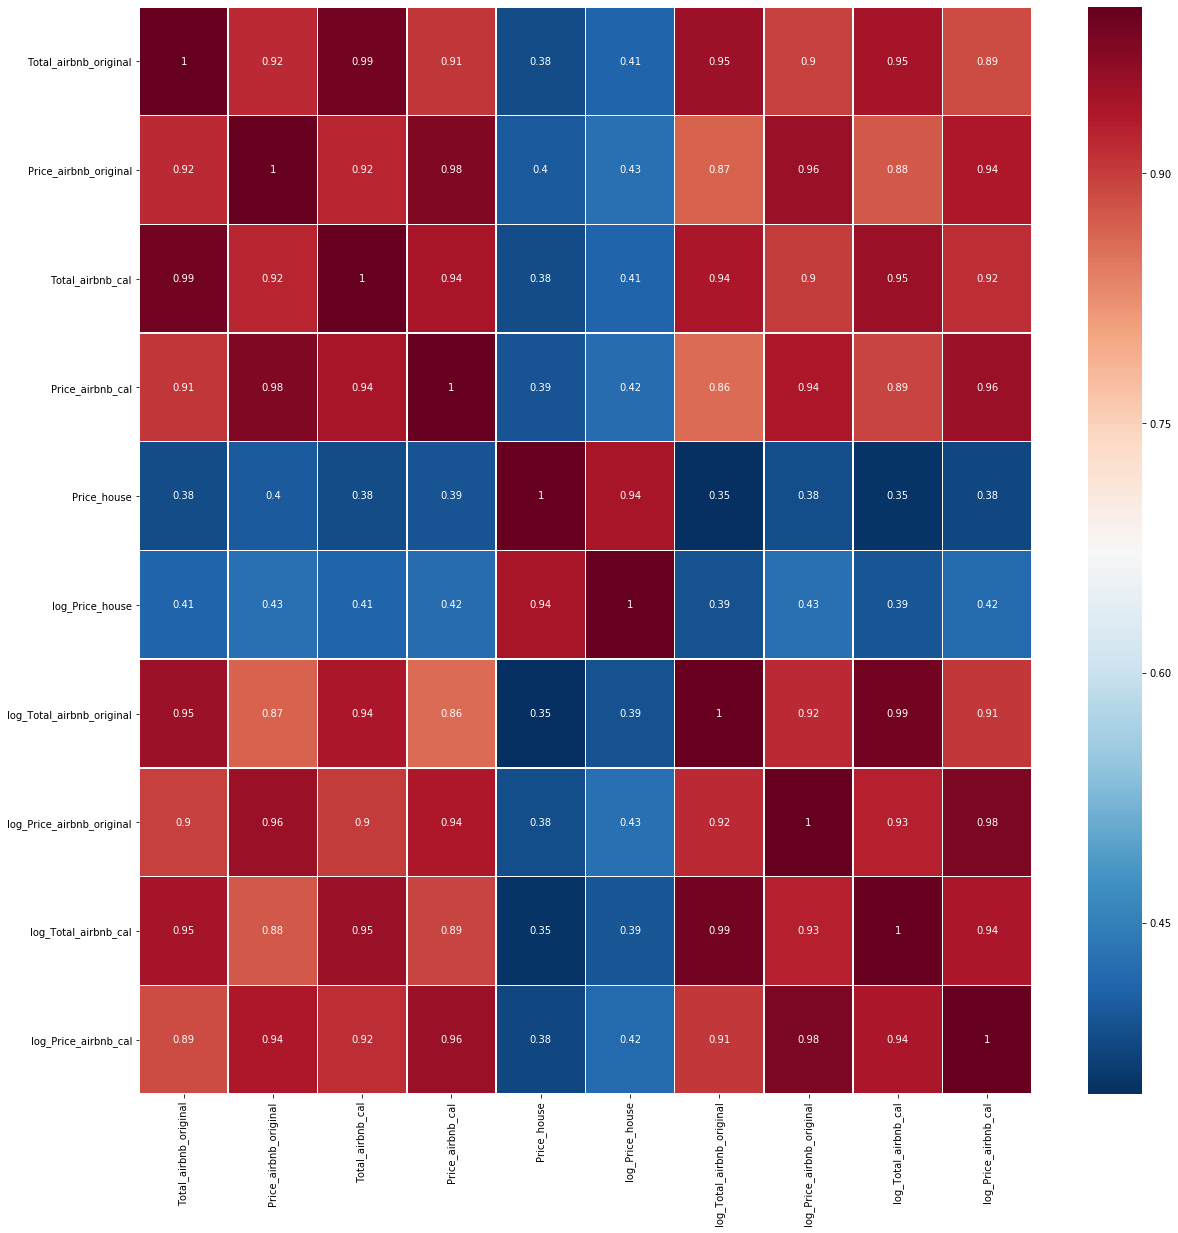

In [109]:
#Plot the Pearson correlation heatmap 
plt.subplots(figsize=(20,20))
sns.heatmap(pearsoncorr, 
            xticklabels=pearsoncorr.columns,
            yticklabels=pearsoncorr.columns,
            cmap='RdBu_r',
            annot=True,
            linewidth=0.5)
b, t = plt.ylim()
b += 0.5 
t -= 0.5 
plt.ylim(b, t)

(10.0, 0.0)

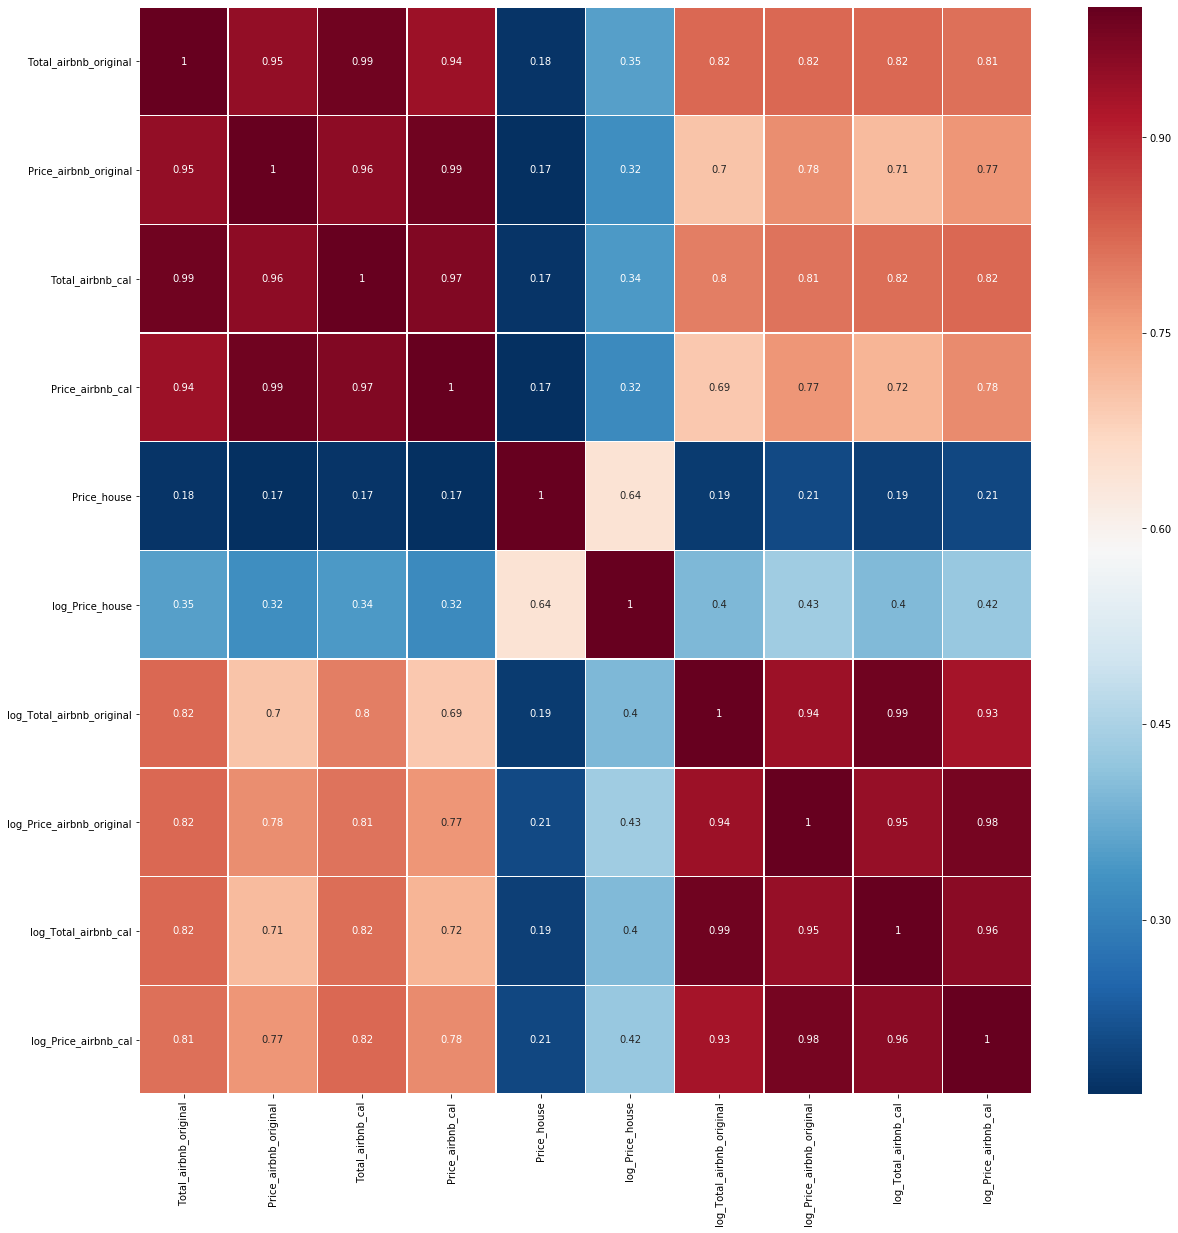

In [110]:
#Plot the Pearson correlation heatmap
plt.subplots(figsize=(20,20))
sns.heatmap(pearsoncorr1, 
            xticklabels=pearsoncorr1.columns,
            yticklabels=pearsoncorr1.columns,
            cmap='RdBu_r',
            annot=True,
            linewidth=0.5)
b, t = plt.ylim()
b += 0.5 
t -= 0.5 
plt.ylim(b, t)

ORLT and OLT achieved the best pearson correlation values, in particular with OALP and CALP. Surprisingly, log_HP also achieved high pearson values with ALP without log transformation. 

In [111]:
#Obtain the p-values of ORLT 
pearson_corr,p_val_pearson   = stats.pearsonr(merged1['log_Total_airbnb_original'],merged1['log_Price_house'])
print('Pearson correlation between Total_airbnb (Original) and Price_house is in ORLT is: ',pearson_corr,
      '\n with p value of: ',p_val_pearson)

pearson_corr1,p_val_pearson1 = stats.pearsonr(merged1['log_Price_airbnb_original'],merged1['log_Price_house'])
print('Pearson correlation between Price_airbnb (Original) and Price_house in ORLT is: ',pearson_corr1,
      '\n with p value of: ',p_val_pearson1)

pearson_corr2,p_val_pearson2 = stats.pearsonr(merged1['log_Total_airbnb_cal'],merged1['log_Price_house'])
print('Pearson correlation between Total_airbnb (Calculated) and Price_house in ORLT is: ',pearson_corr2,
      '\n with p value of: ',p_val_pearson2)

pearson_corr3,p_val_pearson3 = stats.pearsonr(merged1['log_Price_airbnb_cal'],merged1['log_Price_house'])
print('Pearson correlation between Price_airbnb (Calculated) and Price_house is in ORLT is: ',pearson_corr3,
      '\n with p value of: ',p_val_pearson3)

Pearson correlation between Total_airbnb (Original) and Price_house is in ORLT is:  0.3892031863065293 
 with p value of:  8.16457917971314e-129
Pearson correlation between Price_airbnb (Original) and Price_house in ORLT is:  0.4280826800163247 
 with p value of:  2.80828448341595e-158
Pearson correlation between Total_airbnb (Calculated) and Price_house in ORLT is:  0.39480408608371487 
 with p value of:  8.055280691428389e-133
Pearson correlation between Price_airbnb (Calculated) and Price_house is in ORLT is:  0.4203239183565458 
 with p value of:  4.408905725978992e-152


In [112]:
#Obtain the p-values of OLT 
pearson_corr4,p_val_pearson4 = stats.pearsonr(merged_with_outlier['log_Total_airbnb_original'],
                                            merged_with_outlier['log_Price_house'])
print('Pearson correlation between Total_airbnb (Original) and Price_house in OLT is: ',pearson_corr4,
      '\n with p value of: ',p_val_pearson4)

pearson_corr5,p_val_pearson5 = stats.pearsonr(merged_with_outlier['log_Total_airbnb_cal'],
                                            merged_with_outlier['log_Price_house'])
print('Pearson correlation between Total_airbnb (Calculated) and Price_house in OLT is: ',pearson_corr5,
      '\n with p value of: ',p_val_pearson5)

pearson_corr6,p_val_pearson6 = stats.pearsonr(merged_with_outlier['log_Price_airbnb_original'],
                                            merged_with_outlier['log_Price_house'])
print('Pearson correlation between Price_airbnb (Original) and Price_house in OLT is: ',pearson_corr6,
      '\n with p value of: ',p_val_pearson6)

pearson_corr7,p_val_pearson7 = stats.pearsonr(merged_with_outlier['log_Price_airbnb_cal'],
                                            merged_with_outlier['log_Price_house'])
print('Pearson correlation between Price_airbnb (Calculated) and Price_house is in OLT is: ',pearson_corr7,
      '\n with p value of: ',p_val_pearson7)

Pearson correlation between Total_airbnb (Original) and Price_house in OLT is:  0.39723673796495274 
 with p value of:  7.068120963247521e-152
Pearson correlation between Total_airbnb (Calculated) and Price_house in OLT is:  0.4005081227310684 
 with p value of:  1.3845893326592958e-154
Pearson correlation between Price_airbnb (Original) and Price_house in OLT is:  0.43342909666233775 
 with p value of:  1.3688575317902272e-183
Pearson correlation between Price_airbnb (Calculated) and Price_house is in OLT is:  0.42464875160948784 
 with p value of:  1.5561344449311e-175


Both ORLT and OLT sub-dataframes also obtaied low p-values with OLT slightly lower, meaning that the sample size is high enough to be confident statistically significant. 

    7.5 Spearman Correlation

In [113]:
#Spearman correlation
spearmancorr  = merged1.corr(method='spearman')
spearmancorr1 = merged_with_outlier.corr(method='spearman')

(10.0, 0.0)

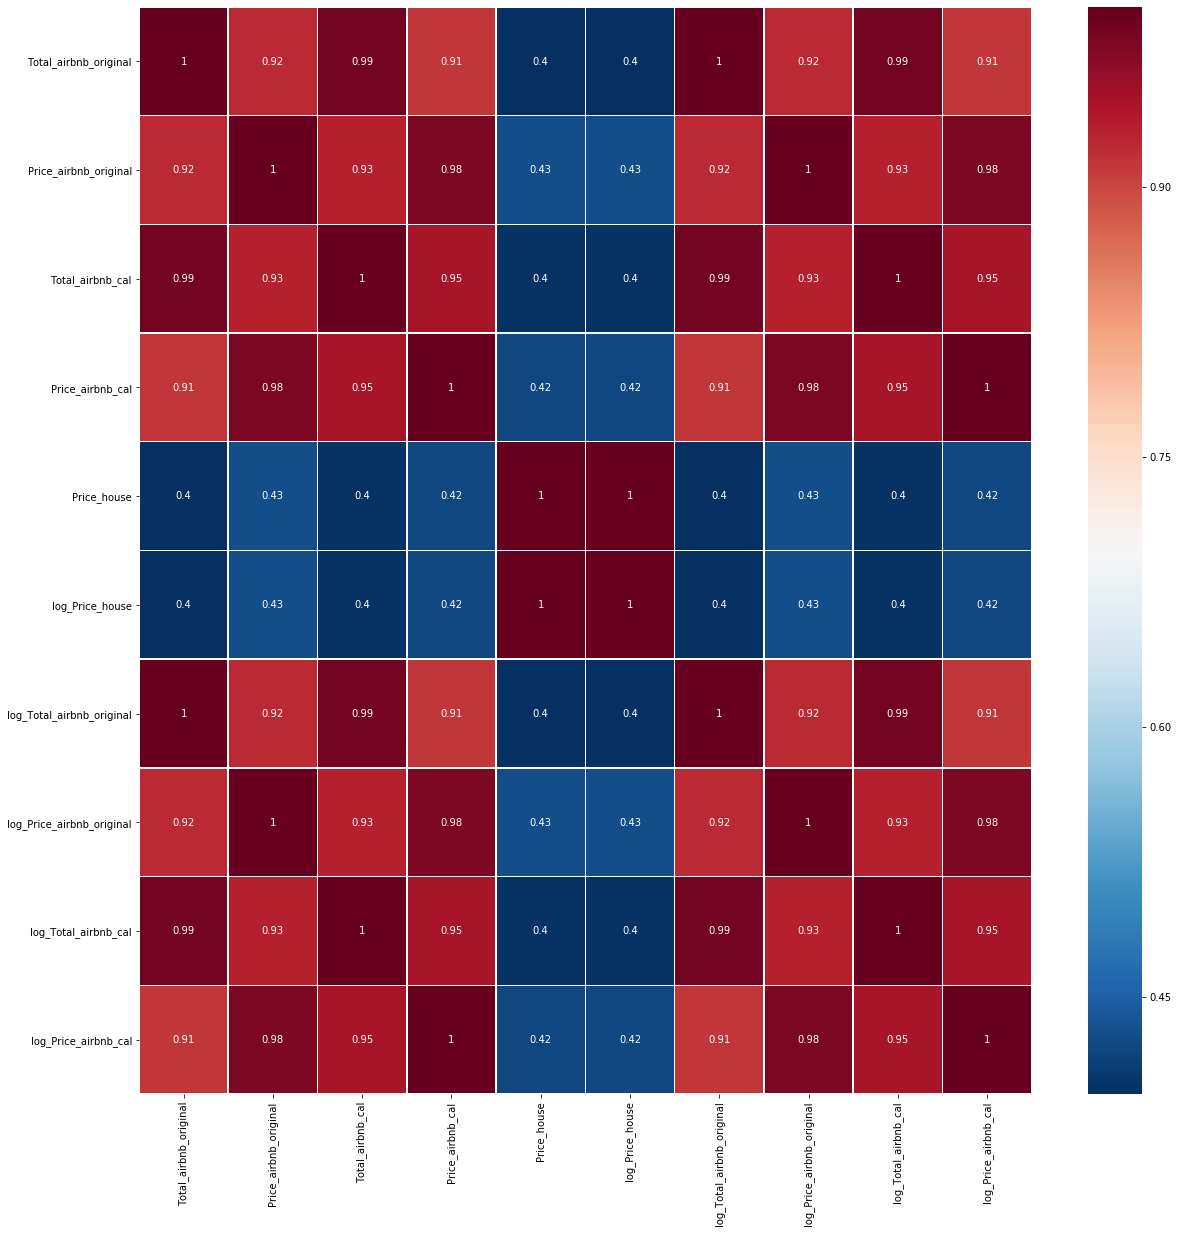

In [114]:
#Plot Spearman correlation heatmap
plt.subplots(figsize=(20,20))
sns.heatmap(spearmancorr, 
            xticklabels=spearmancorr.columns,
            yticklabels=spearmancorr.columns,
            cmap='RdBu_r',
            annot=True,
            linewidth=0.5)
b, t = plt.ylim()
b += 0.5 
t -= 0.5 
plt.ylim(b, t)

(10.0, 0.0)

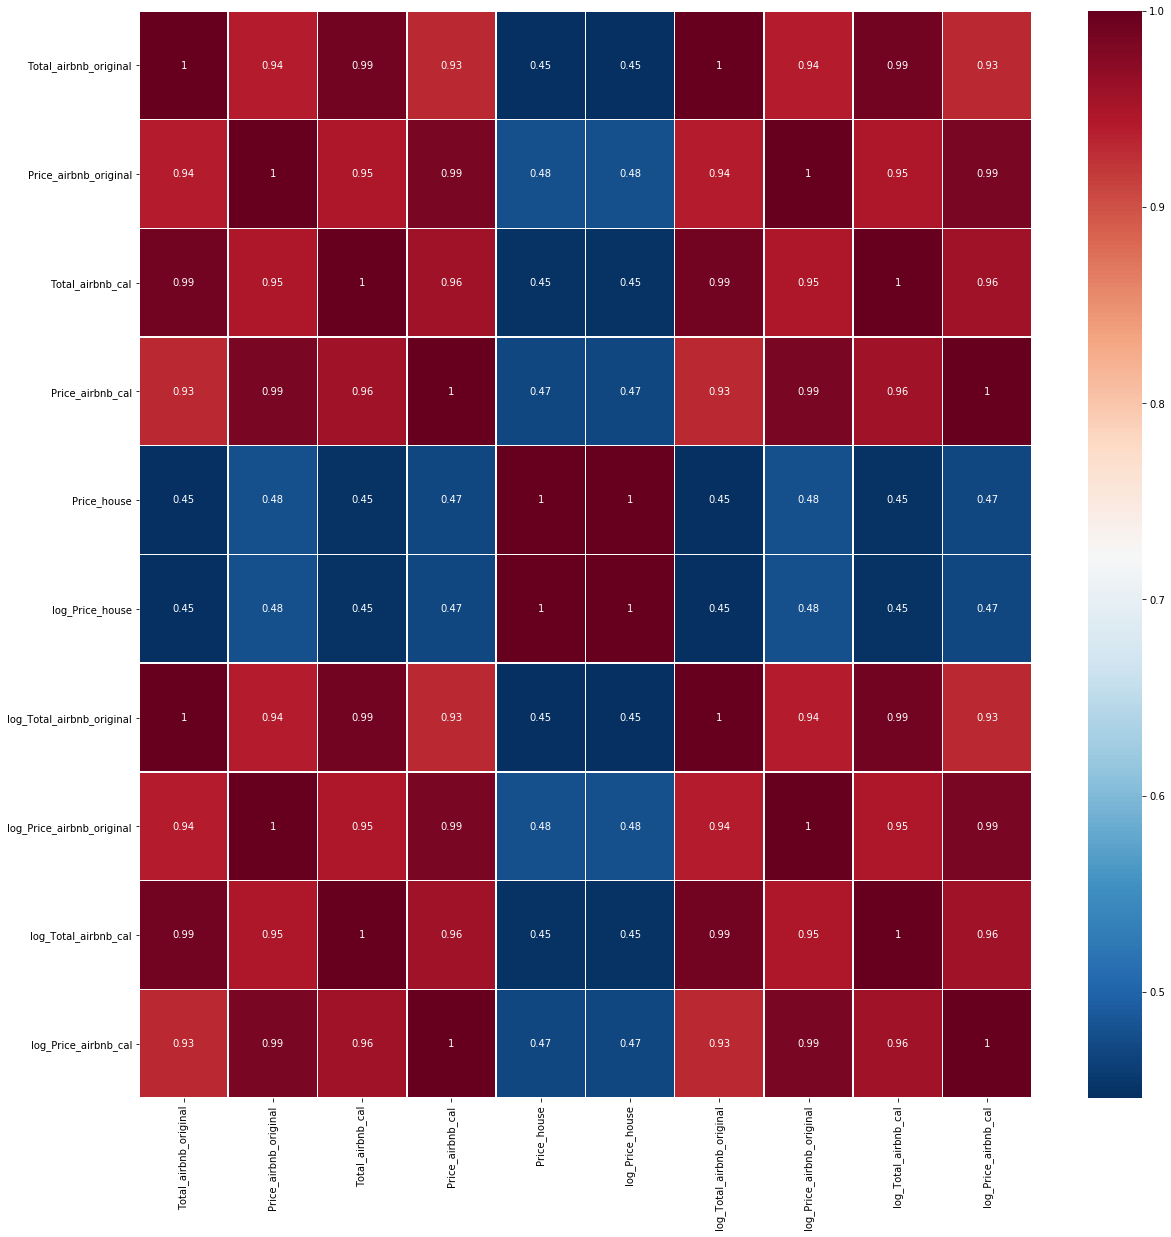

In [115]:
#Plot Spearman correlation heatmap
plt.subplots(figsize=(20,20))
sns.heatmap(spearmancorr1, 
            xticklabels=spearmancorr1.columns,
            yticklabels=spearmancorr1.columns,
            cmap='RdBu_r',
            annot=True,
            linewidth=0.5)
b, t = plt.ylim()
b += 0.5 
t -= 0.5 
plt.ylim(b, t)

All 4 sub-dataframes achieved high spearman correlation values.

In [116]:
#Obtain p-values of ORLT
spearman_corr,p_val_spearman=stats.spearmanr(merged1['log_Total_airbnb_original'],merged1['log_Price_house'])
print('Pearson correlation between Total_airbnb (Original) and Price_house is in ORLT is: ',spearman_corr,
      '\n with p value of: ',p_val_spearman)

spearman_corr1,p_val_spearman1=stats.spearmanr(merged1['log_Total_airbnb_cal'],merged1['log_Price_house'])
print('Pearson correlation between Total_airbnb (Calculated) and Price_house in ORLT is: ',spearman_corr1,
      '\n with p value of: ',p_val_spearman1)

spearman_corr2,p_val_spearman2=stats.spearmanr(merged1['log_Price_airbnb_original'],merged1['log_Price_house'])
print('Pearson correlation between Price_airbnb (Original) and Price_house in ORLT is: ',spearman_corr2,
      '\n with p value of: ',p_val_spearman2)

spearman_corr3,p_val_spearman3=stats.spearmanr(merged1['log_Price_airbnb_cal'],merged1['log_Price_house'])
print('Pearson correlation between Price_airbnb (Calculated) and Price_house is in ORLT is: ',spearman_corr3,
      '\n with p value of: ',p_val_spearman3)

Pearson correlation between Total_airbnb (Original) and Price_house is in ORLT is:  0.39610800735349866 
 with p value of:  9.168330345671116e-134
Pearson correlation between Total_airbnb (Calculated) and Price_house in ORLT is:  0.40038775160612566 
 with p value of:  6.831957124687027e-137
Pearson correlation between Price_airbnb (Original) and Price_house in ORLT is:  0.43105995203909364 
 with p value of:  1.0651605666604238e-160
Pearson correlation between Price_airbnb (Calculated) and Price_house is in ORLT is:  0.4239113659006529 
 with p value of:  6.305677278883813e-155


In [117]:
#Obtain p-values of OLT
spearman_corr4,p_val_spearman4=stats.spearmanr(merged_with_outlier['log_Total_airbnb_original'],
                                            merged_with_outlier['log_Price_house'])
print('Pearson correlation between Total_airbnb (Original) and Price_house in OLT is: ',spearman_corr4,
      '\n with p value of: ',p_val_spearman4)

spearman_corr5,p_val_spearman5=stats.spearmanr(merged_with_outlier['log_Total_airbnb_cal'],
                                            merged_with_outlier['log_Price_house'])
print('Pearson correlation between Total_airbnb (Calculated) and Price_house in OLT is: ',spearman_corr5,
      '\n with p value of: ',p_val_spearman5)

spearman_corr6,p_val_spearman6=stats.spearmanr(merged_with_outlier['log_Price_airbnb_original'],
                                            merged_with_outlier['log_Price_house'])
print('Pearson correlation between Price_airbnb (Original) and Price_house in OLT is: ',spearman_corr6,
      '\n with p value of: ',p_val_spearman6)

spearman_corr7,p_val_spearman7=stats.spearmanr(merged_with_outlier['log_Price_airbnb_cal'],
                                            merged_with_outlier['log_Price_house'])
print('Pearson correlation between Price_airbnb (Calculated) and Price_house is in OLT is: ',spearman_corr7,
      '\n with p value of: ',p_val_spearman7)

Pearson correlation between Total_airbnb (Original) and Price_house in OLT is:  0.44589842097367843 
 with p value of:  1.9014143017045062e-195
Pearson correlation between Total_airbnb (Calculated) and Price_house in OLT is:  0.44950703719387264 
 with p value of:  5.675888850963966e-199
Pearson correlation between Price_airbnb (Original) and Price_house in OLT is:  0.47873906712733605 
 with p value of:  3.78719417508346e-229
Pearson correlation between Price_airbnb (Calculated) and Price_house is in OLT is:  0.4716457899789151 
 with p value of:  1.4888452208746787e-221


OALP and CALP in OLT also achieved best both spearman correlation values, p-values for both are also very low.

Pearson correlation measures the interval scales and Spearman correlation measures monotonic relationship, therefore, Pearson correlation is more appropriate for this analysis. 

As per analysis above, only OALP and CALP from both ORLT and OLT will be considered for this analysis. 

    7.6 Time Series 

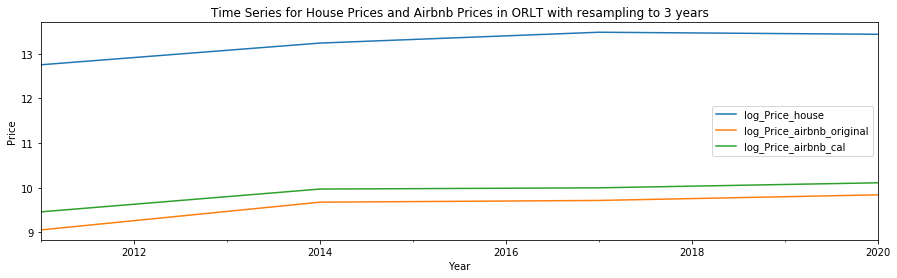

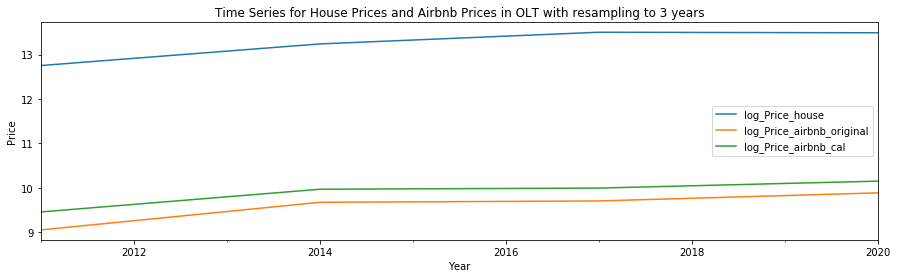

In [118]:
#Plot the time series graph for both OLT and ORLT and resample to 3 years
merged1[["log_Price_house", "log_Price_airbnb_original",'log_Price_airbnb_cal']].resample("3y").median().plot(figsize=(15,4))
plt.title('Time Series for House Prices and Airbnb Prices in ORLT with resampling to 3 years')
plt.xlabel('Year')
plt.ylabel('Price')
plt.show()

merged_with_outlier[["log_Price_house", "log_Price_airbnb_original",'log_Price_airbnb_cal']].resample("3y").median().plot(figsize=(15,4))
plt.title('Time Series for House Prices and Airbnb Prices in OLT with resampling to 3 years')
plt.xlabel('Year')
plt.ylabel('Price')
plt.show()

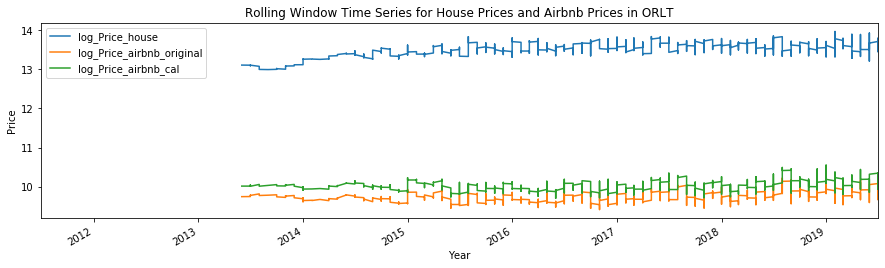

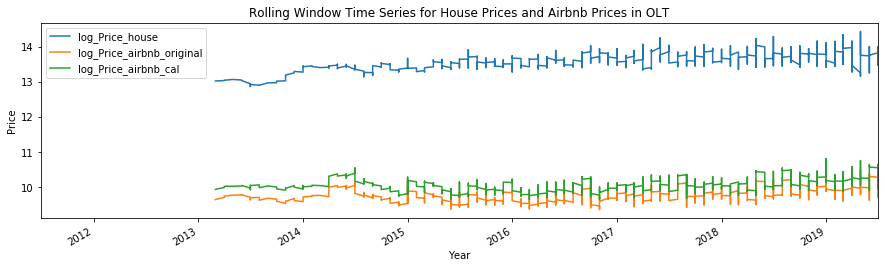

In [119]:
#Plot the rolling windwo time series graph for both OLT and ORLT with length of 24
merged1[["log_Price_house", "log_Price_airbnb_original",'log_Price_airbnb_cal']].rolling(24).mean().plot(figsize=(15,4))
plt.title('Rolling Window Time Series for House Prices and Airbnb Prices in ORLT')
plt.xlabel('Year')
plt.ylabel('Price')
plt.show()

merged_with_outlier[["log_Price_house", "log_Price_airbnb_original",'log_Price_airbnb_cal']].rolling(24).mean().plot(figsize=(15,4))
plt.title('Rolling Window Time Series for House Prices and Airbnb Prices in OLT')
plt.xlabel('Year')
plt.ylabel('Price')
plt.show()

The time-series plot showed that both HP and ALP take similar trend over the years. 
By plotting the time-series with a rolling window with a length of 24, it allows us to observe the fluctuation of both HP and ALP over time more clearly. 

    7.6.1 Pearson correlation time series with rolling window

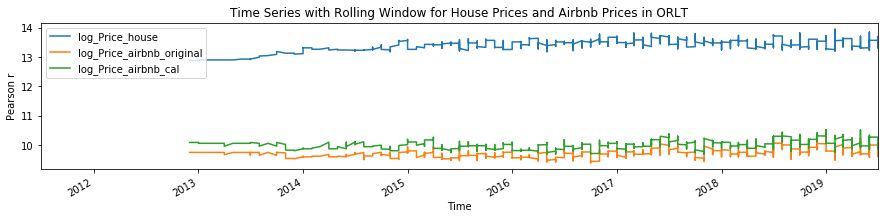

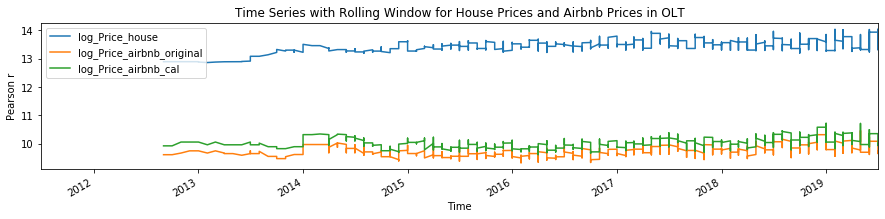

In [120]:
#The Pearson correlation is a good place to start to find the global synchrony of two datasets. 
#Plot the rolling windwo time series graph with Pearson correlation for both ORLT and OLT
f,ax = plt.subplots(figsize=(15,3))
merged1[["log_Price_house", "log_Price_airbnb_original",'log_Price_airbnb_cal']].rolling(window=30,center=True).median().plot(ax=ax)
ax.set(xlabel='Time',ylabel='Pearson r',title='Time Series with Rolling Window for House Prices and Airbnb Prices in ORLT')
plt.legend(loc='upper left')
plt.show()

f,ax = plt.subplots(figsize=(15,3))
merged_with_outlier[["log_Price_house", "log_Price_airbnb_original",'log_Price_airbnb_cal']].rolling(window=30,center=True).median().plot(ax=ax)
ax.set(xlabel='Time',ylabel='Pearson r',title='Time Series with Rolling Window for House Prices and Airbnb Prices in OLT')
plt.legend(loc='upper left')
plt.show()

# 8. Time Lagged Cross-correlation (TLCC)

In [121]:
#Use pandas own functions to implement a cross correlation function
def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))

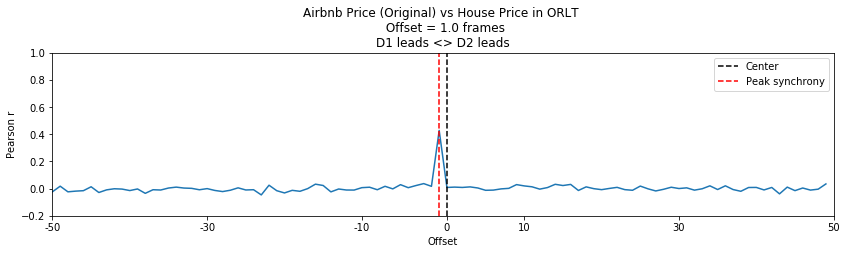

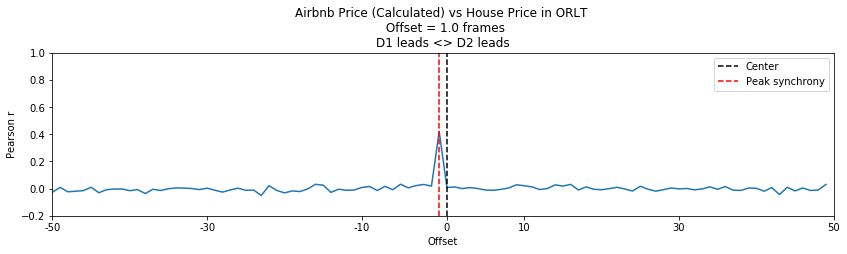

In [122]:
#TLCC for ORLT
d1 = merged1['log_Price_airbnb_original']
d2 = merged1['log_Price_house']

years  = 1
fps    = 50

rs     = [crosscorr(d1,d2,lag) for lag in range(-int(years*fps),int(years*fps+1))]
offset = np.ceil(len(rs)/2)-np.argmax(rs)

f,ax = plt.subplots(figsize=(14,3))
ax.plot(rs)
ax.axvline(np.ceil(len(rs)/2),color='k',linestyle='--',label='Center')
ax.axvline(np.argmax(rs),color='r',linestyle='--',label='Peak synchrony')
ax.set(title=f'Airbnb Price (Original) vs House Price in ORLT \n Offset = {offset} frames\nD1 leads <> D2 leads',
       ylim=[-.2,1],xlim=[0,101],xlabel='Offset',ylabel='Pearson r')
ax.set_xticks([0, 20, 40, 51, 61, 81, 101])
ax.set_xticklabels([-50, -30, -10, 0, 10, 30, 50]);
plt.legend()
plt.show()

d3 = merged1['log_Price_airbnb_cal']
d4 = merged1['log_Price_house']

rs1     = [crosscorr(d3,d4,lag) for lag in range(-int(years*fps),int(years*fps+1))]
offset1 = np.ceil(len(rs1)/2)-np.argmax(rs1)

f,ax = plt.subplots(figsize=(14,3))
ax.plot(rs1)
ax.axvline(np.ceil(len(rs1)/2),color='k',linestyle='--',label='Center')
ax.axvline(np.argmax(rs1),color='r',linestyle='--',label='Peak synchrony')
ax.set(title=f'Airbnb Price (Calculated) vs House Price in ORLT \n Offset = {offset1} frames\nD1 leads <> D2 leads',
       ylim=[-.2,1],xlim=[0,101],xlabel='Offset',ylabel='Pearson r')
ax.set_xticks([0, 20, 40, 51, 61, 81, 101])
ax.set_xticklabels([-50, -30, -10, 0, 10, 30, 50]);
plt.legend()
plt.show()

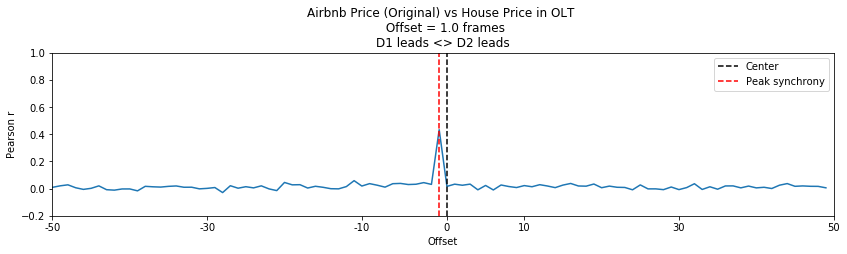

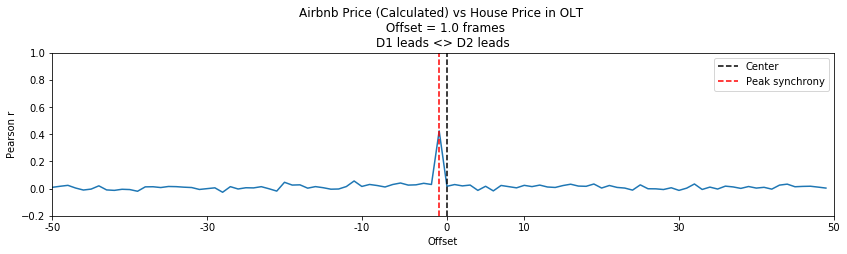

In [123]:
#TLCC for OLT
d4 = merged_with_outlier['log_Price_airbnb_original']
d5 = merged_with_outlier['log_Price_house']

years  = 1
fps    = 50

rs3     = [crosscorr(d4,d5,lag) for lag in range(-int(years*fps),int(years*fps+1))]
offset3 = np.ceil(len(rs3)/2)-np.argmax(rs3)

f,ax = plt.subplots(figsize=(14,3))
ax.plot(rs3)
ax.axvline(np.ceil(len(rs3)/2),color='k',linestyle='--',label='Center')
ax.axvline(np.argmax(rs3),color='r',linestyle='--',label='Peak synchrony')
ax.set(title=f'Airbnb Price (Original) vs House Price in OLT \n Offset = {offset3} frames\nD1 leads <> D2 leads',
       ylim=[-.2,1],xlim=[0,101],xlabel='Offset',ylabel='Pearson r')
ax.set_xticks([0, 20, 40, 51, 61, 81, 101])
ax.set_xticklabels([-50, -30, -10, 0, 10, 30, 50]);
plt.legend()
plt.show()

d6 = merged_with_outlier['log_Price_airbnb_cal']
d7 = merged_with_outlier['log_Price_house']

rs4     = [crosscorr(d6,d7,lag) for lag in range(-int(years*fps),int(years*fps+1))]
offset4 = np.ceil(len(rs4)/2)-np.argmax(rs4)

f,ax = plt.subplots(figsize=(14,3))
ax.plot(rs4)
ax.axvline(np.ceil(len(rs4)/2),color='k',linestyle='--',label='Center')
ax.axvline(np.argmax(rs4),color='r',linestyle='--',label='Peak synchrony')
ax.set(title=f'Airbnb Price (Calculated) vs House Price in OLT \n Offset = {offset4} frames\nD1 leads <> D2 leads',
       ylim=[-.2,1],xlim=[0,101],xlabel='Offset',ylabel='Pearson r')
ax.set_xticks([0, 20, 40, 51, 61, 81, 101])
ax.set_xticklabels([-50, -30, -10, 0, 10, 30, 50]);
plt.legend()
plt.show()

From above TLCC graphs, ALP is the leading interaction in both OLT and ORLT, where the Pearson correlation is maximised when HP is pulled forward by one frame (1year). 

TLCC for each postcode district will be analysed below. 

In [125]:
#Split the Postcode areas into East, West, North, North Weset, South East, South West, Central and Outer 
East_merged_with_outlier   = merged_with_outlier[merged_with_outlier['Postcode'].str[0]=='E']
East_merged_with_outlier   = East_merged_with_outlier[East_merged_with_outlier['Postcode'].str[1]!='C']
East_merged_with_outlier   = East_merged_with_outlier[East_merged_with_outlier['Postcode'].str[1]!='N']

if East_merged_with_outlier['Postcode'].all()<='E18':
    East_merged_with_outlier['Postcode'] = East_merged_with_outlier['Postcode']
else: 
    East_merged_with_outlier['Postcode'] = East_merged_with_outlier['Postcode'].str[0:2]

East_merged_with_outlier.drop_duplicates(subset=['Postcode']).reset_index()
    
West_merged_with_outlier   = merged_with_outlier[merged_with_outlier['Postcode'].str[0]=='W']
West_merged_with_outlier   = West_merged_with_outlier[West_merged_with_outlier['Postcode'].str[1]!='C']

West_merged_with_outlier.drop_duplicates(subset=['Postcode']).reset_index()

North_merged_with_outlier = merged_with_outlier[merged_with_outlier['Postcode'].str[0]=='N']
NW_merged_with_outlier    = North_merged_with_outlier[North_merged_with_outlier['Postcode'].str[1]=='W']
North_merged = North_merged_with_outlier[North_merged_with_outlier['Postcode'].str[1]!='W']

North_merged_with_outlier.drop_duplicates(subset=['Postcode']).reset_index()
NW_merged_with_outlier.drop_duplicates(subset=['Postcode']).reset_index()

South_merged_with_outlier = merged_with_outlier[merged_with_outlier['Postcode'].str[0]=='S']    
SE_merged_with_outlier    = South_merged_with_outlier[South_merged_with_outlier['Postcode'].str[1]=='E']
SW_merged_with_outlier = South_merged_with_outlier[South_merged_with_outlier['Postcode'].str[1]=='W']

SE_merged_with_outlier.drop_duplicates(subset=['Postcode']).reset_index()
SW_merged_with_outlier.drop_duplicates(subset=['Postcode']).reset_index()
       
Central_merged_with_outlier = merged_with_outlier[merged_with_outlier['Postcode'].str[1]=='C']

Central_merged_with_outlier.drop_duplicates(subset=['Postcode']).reset_index()

IG = merged_with_outlier[merged_with_outlier['Postcode'].str[0]=='I']
RM = merged_with_outlier[merged_with_outlier['Postcode'].str[0]=='R']
EN = merged_with_outlier[merged_with_outlier['Postcode'].str[1]=='N']
DA = merged_with_outlier[merged_with_outlier['Postcode'].str[0]=='D']
BR = merged_with_outlier[merged_with_outlier['Postcode'].str[0]=='B']
CR = merged_with_outlier[merged_with_outlier['Postcode'].str[0]=='C']
SM = merged_with_outlier[merged_with_outlier['Postcode'].str[1]=='M']
KT = merged_with_outlier[merged_with_outlier['Postcode'].str[0]=='K']
TW = merged_with_outlier[merged_with_outlier['Postcode'].str[0]=='T']
UB = merged_with_outlier[merged_with_outlier['Postcode'].str[0]=='U']
HA = merged_with_outlier[merged_with_outlier['Postcode'].str[0]=='H']
WD = merged_with_outlier[merged_with_outlier['Postcode'].str[1]=='D']

Outer_merged_with_outlier = pd.concat([IG,RM,EN,DA,BR,CR,SM,KT,TW,UB,HA,WD]).reset_index()

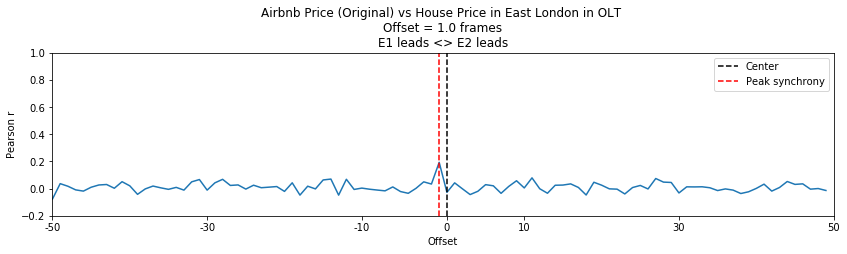

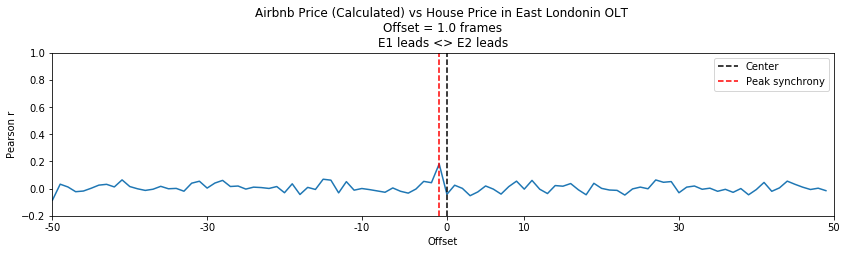

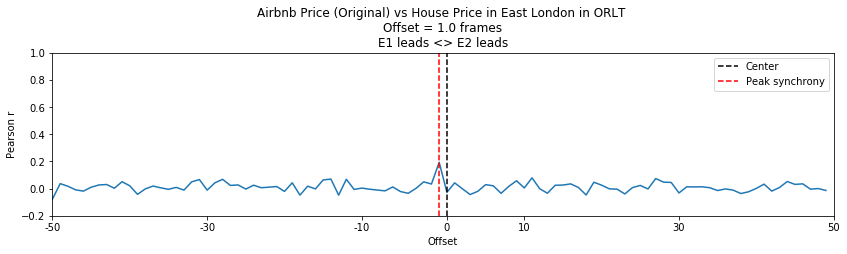

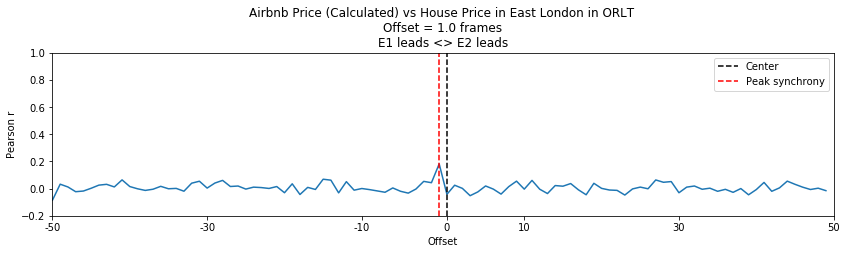

In [126]:
e1 = East_merged_with_outlier['log_Price_airbnb_original']
e2 = East_merged_with_outlier['log_Price_airbnb_cal']
e3 = East_merged_with_outlier['log_Price_house']

years  = 1
fps    = 50

east_rs     = [crosscorr(e1,e3,lag) for lag in range(-int(years*fps),int(years*fps+1))]
east_offset = np.ceil(len(east_rs)/2)-np.argmax(east_rs)

f,ax = plt.subplots(figsize=(14,3))
ax.plot(east_rs)
ax.axvline(np.ceil(len(east_rs)/2),color='k',linestyle='--',label='Center')
ax.axvline(np.argmax(east_rs),color='r',linestyle='--',label='Peak synchrony')
ax.set(title=f'Airbnb Price (Original) vs House Price in East London in OLT \nOffset = {east_offset} frames\nE1 leads <> E2 leads',
       ylim=[-.2,1],xlim=[0,101],xlabel='Offset',ylabel='Pearson r')
ax.set_xticks([0, 20, 40, 51, 61, 81, 101])
ax.set_xticklabels([-50, -30, -10, 0, 10, 30, 50]);
plt.legend()
plt.show()

east_rs1     = [crosscorr(e2,e3,lag) for lag in range(-int(years*fps),int(years*fps+1))]
east_offset1 = np.ceil(len(east_rs1)/2)-np.argmax(east_rs1)

f,ax = plt.subplots(figsize=(14,3))
ax.plot(east_rs1)
ax.axvline(np.ceil(len(east_rs1)/2),color='k',linestyle='--',label='Center')
ax.axvline(np.argmax(east_rs1),color='r',linestyle='--',label='Peak synchrony')
ax.set(title=f'Airbnb Price (Calculated) vs House Price in East Londonin OLT \nOffset = {east_offset1} frames\nE1 leads <> E2 leads',
       ylim=[-.2,1],xlim=[0,101],xlabel='Offset',ylabel='Pearson r')
ax.set_xticks([0, 20, 40, 51, 61, 81, 101])
ax.set_xticklabels([-50, -30, -10, 0, 10, 30, 50]);
plt.legend()
plt.show()

e5 = East_merged['log_Price_airbnb_original']
e6 = East_merged['log_Price_airbnb_cal']
e7 = East_merged['log_Price_house']

years  = 1
fps    = 50

east_rs5     = [crosscorr(e5,e7,lag) for lag in range(-int(years*fps),int(years*fps+1))]
east_offset5 = np.ceil(len(east_rs5)/2)-np.argmax(east_rs5)

f,ax = plt.subplots(figsize=(14,3))
ax.plot(east_rs5)
ax.axvline(np.ceil(len(east_rs5)/2),color='k',linestyle='--',label='Center')
ax.axvline(np.argmax(east_rs5),color='r',linestyle='--',label='Peak synchrony')
ax.set(title=f'Airbnb Price (Original) vs House Price in East London in ORLT \nOffset = {east_offset5} frames\nE1 leads <> E2 leads',
       ylim=[-.2,1],xlim=[0,101],xlabel='Offset',ylabel='Pearson r')
ax.set_xticks([0, 20, 40, 51, 61, 81, 101])
ax.set_xticklabels([-50, -30, -10, 0, 10, 30, 50]);
plt.legend()
plt.show()

east_rs6     = [crosscorr(e6,e7,lag) for lag in range(-int(years*fps),int(years*fps+1))]
east_offset6 = np.ceil(len(east_rs6)/2)-np.argmax(east_rs6)

f,ax = plt.subplots(figsize=(14,3))
ax.plot(east_rs6)
ax.axvline(np.ceil(len(east_rs6)/2),color='k',linestyle='--',label='Center')
ax.axvline(np.argmax(east_rs6),color='r',linestyle='--',label='Peak synchrony')
ax.set(title=f'Airbnb Price (Calculated) vs House Price in East London in ORLT \nOffset = {east_offset6} frames\nE1 leads <> E2 leads',
       ylim=[-.2,1],xlim=[0,101],xlabel='Offset',ylabel='Pearson r')
ax.set_xticks([0, 20, 40, 51, 61, 81, 101])
ax.set_xticklabels([-50, -30, -10, 0, 10, 30, 50]);
plt.legend()
plt.show()

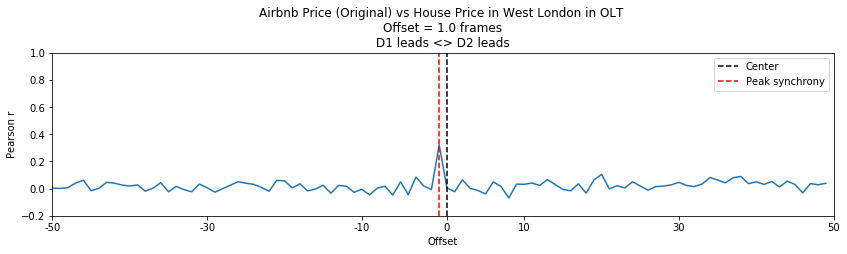

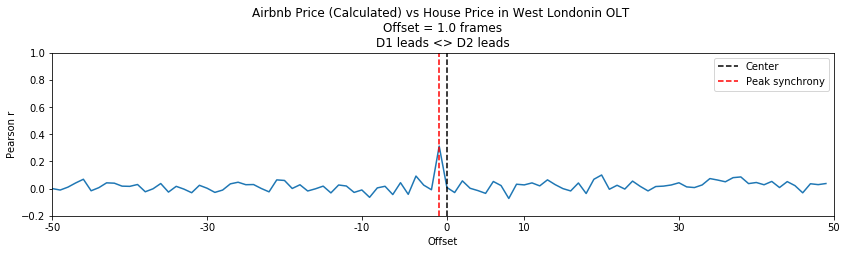

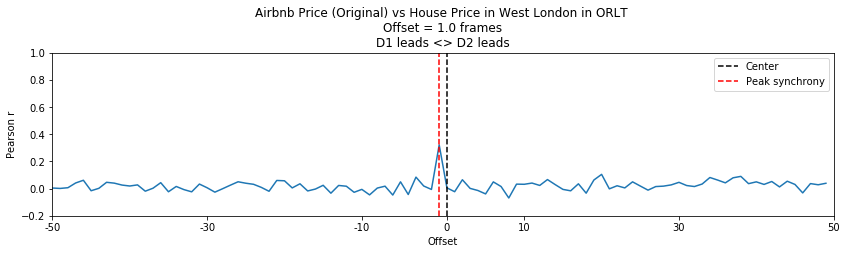

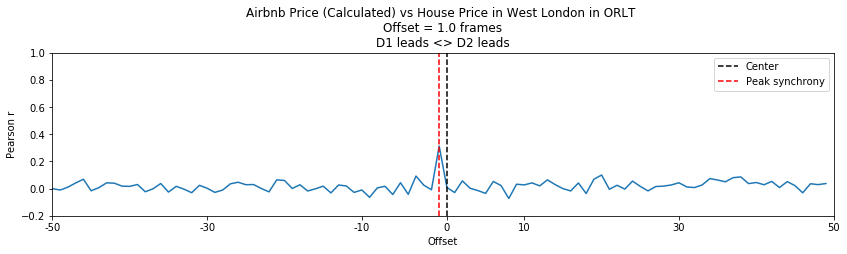

In [127]:
w1 = West_merged_with_outlier['log_Price_airbnb_original']
w2 = West_merged_with_outlier['log_Price_airbnb_cal']
w3 = West_merged_with_outlier['log_Price_house']

years  = 1
fps    = 50

west_rs     = [crosscorr(w1,w3,lag) for lag in range(-int(years*fps),int(years*fps+1))]
west_offset = np.ceil(len(west_rs)/2)-np.argmax(west_rs)

f,ax = plt.subplots(figsize=(14,3))
ax.plot(west_rs)
ax.axvline(np.ceil(len(west_rs)/2),color='k',linestyle='--',label='Center')
ax.axvline(np.argmax(west_rs),color='r',linestyle='--',label='Peak synchrony')
ax.set(title=f'Airbnb Price (Original) vs House Price in West London in OLT \nOffset = {west_offset} frames\nD1 leads <> D2 leads',
       ylim=[-.2,1],xlim=[0,101],xlabel='Offset',ylabel='Pearson r')
ax.set_xticks([0, 20, 40, 51, 61, 81, 101])
ax.set_xticklabels([-50, -30, -10, 0, 10, 30, 50]);
plt.legend()
plt.show()

west_rs1     = [crosscorr(w2,w3,lag) for lag in range(-int(years*fps),int(years*fps+1))]
west_offset1 = np.ceil(len(west_rs1)/2)-np.argmax(west_rs1)

f,ax = plt.subplots(figsize=(14,3))
ax.plot(west_rs1)
ax.axvline(np.ceil(len(west_rs1)/2),color='k',linestyle='--',label='Center')
ax.axvline(np.argmax(west_rs1),color='r',linestyle='--',label='Peak synchrony')
ax.set(title=f'Airbnb Price (Calculated) vs House Price in West Londonin OLT \nOffset = {west_offset1} frames\nD1 leads <> D2 leads',
       ylim=[-.2,1],xlim=[0,101],xlabel='Offset',ylabel='Pearson r')
ax.set_xticks([0, 20, 40, 51, 61, 81, 101])
ax.set_xticklabels([-50, -30, -10, 0, 10, 30, 50]);
plt.legend()
plt.show()

w5 = West_merged['log_Price_airbnb_original']
w6 = West_merged['log_Price_airbnb_cal']
w7 = West_merged['log_Price_house']

years  = 1
fps    = 50

west_rs5     = [crosscorr(w5,w7,lag) for lag in range(-int(years*fps),int(years*fps+1))]
west_offset5 = np.ceil(len(west_rs5)/2)-np.argmax(west_rs5)

f,ax = plt.subplots(figsize=(14,3))
ax.plot(west_rs5)
ax.axvline(np.ceil(len(west_rs5)/2),color='k',linestyle='--',label='Center')
ax.axvline(np.argmax(west_rs5),color='r',linestyle='--',label='Peak synchrony')
ax.set(title=f'Airbnb Price (Original) vs House Price in West London in ORLT \nOffset = {west_offset5} frames\nD1 leads <> D2 leads',
       ylim=[-.2,1],xlim=[0,101],xlabel='Offset',ylabel='Pearson r')
ax.set_xticks([0, 20, 40, 51, 61, 81, 101])
ax.set_xticklabels([-50, -30, -10, 0, 10, 30, 50]);
plt.legend()
plt.show()

west_rs6     = [crosscorr(w6,w7,lag) for lag in range(-int(years*fps),int(years*fps+1))]
west_offset6 = np.ceil(len(west_rs6)/2)-np.argmax(west_rs6)

f,ax = plt.subplots(figsize=(14,3))
ax.plot(west_rs6)
ax.axvline(np.ceil(len(west_rs6)/2),color='k',linestyle='--',label='Center')
ax.axvline(np.argmax(west_rs6),color='r',linestyle='--',label='Peak synchrony')
ax.set(title=f'Airbnb Price (Calculated) vs House Price in West London in ORLT \nOffset = {west_offset6} frames\nD1 leads <> D2 leads',
       ylim=[-.2,1],xlim=[0,101],xlabel='Offset',ylabel='Pearson r')
ax.set_xticks([0, 20, 40, 51, 61, 81, 101])
ax.set_xticklabels([-50, -30, -10, 0, 10, 30, 50]);
plt.legend()
plt.show()

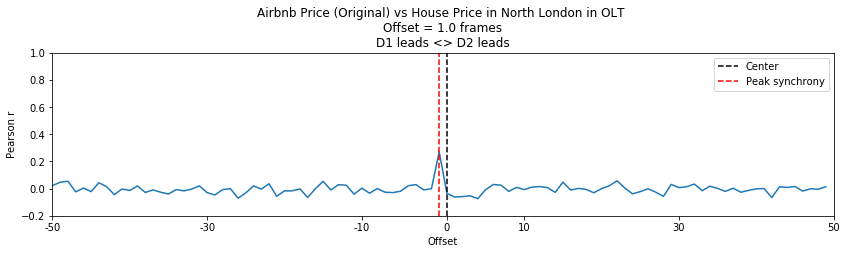

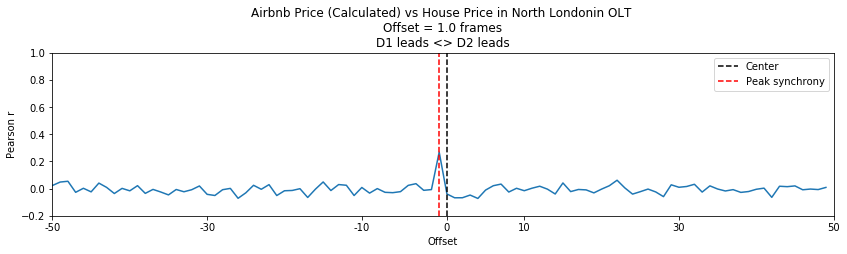

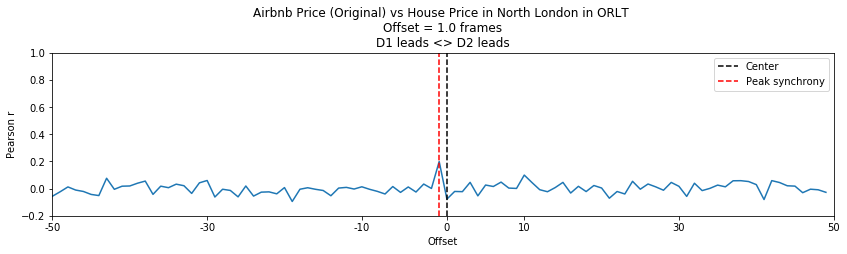

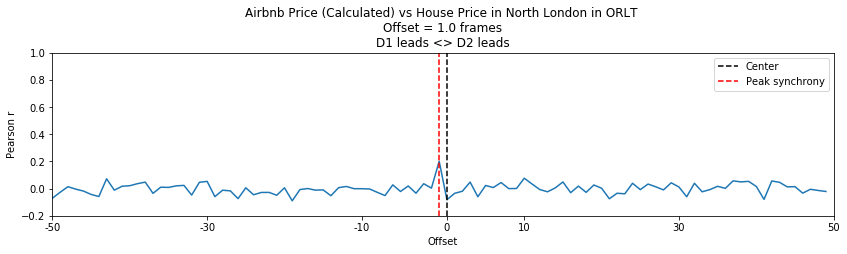

In [128]:
n1 = North_merged_with_outlier['log_Price_airbnb_original']
n2 = North_merged_with_outlier['log_Price_airbnb_cal']
n3 = North_merged_with_outlier['log_Price_house']

years  = 1
fps    = 50

north_rs     = [crosscorr(n1,n3,lag) for lag in range(-int(years*fps),int(years*fps+1))]
north_offset = np.ceil(len(north_rs)/2)-np.argmax(north_rs)

f,ax = plt.subplots(figsize=(14,3))
ax.plot(north_rs)
ax.axvline(np.ceil(len(north_rs)/2),color='k',linestyle='--',label='Center')
ax.axvline(np.argmax(north_rs),color='r',linestyle='--',label='Peak synchrony')
ax.set(title=f'Airbnb Price (Original) vs House Price in North London in OLT \nOffset = {north_offset} frames\nD1 leads <> D2 leads',
       ylim=[-.2,1],xlim=[0,101],xlabel='Offset',ylabel='Pearson r')
ax.set_xticks([0, 20, 40, 51, 61, 81, 101])
ax.set_xticklabels([-50, -30, -10, 0, 10, 30, 50]);
plt.legend()
plt.show()

north_rs1     = [crosscorr(n2,n3,lag) for lag in range(-int(years*fps),int(years*fps+1))]
north_offset1 = np.ceil(len(north_rs1)/2)-np.argmax(north_rs1)

f,ax = plt.subplots(figsize=(14,3))
ax.plot(north_rs1)
ax.axvline(np.ceil(len(north_rs1)/2),color='k',linestyle='--',label='Center')
ax.axvline(np.argmax(north_rs1),color='r',linestyle='--',label='Peak synchrony')
ax.set(title=f'Airbnb Price (Calculated) vs House Price in North Londonin OLT \nOffset = {north_offset1} frames\nD1 leads <> D2 leads',
       ylim=[-.2,1],xlim=[0,101],xlabel='Offset',ylabel='Pearson r')
ax.set_xticks([0, 20, 40, 51, 61, 81, 101])
ax.set_xticklabels([-50, -30, -10, 0, 10, 30, 50]);
plt.legend()
plt.show()

n5 = North_merged['log_Price_airbnb_original']
n6 = North_merged['log_Price_airbnb_cal']
n7 = North_merged['log_Price_house']

years  = 1
fps    = 50

north_rs5     = [crosscorr(n5,n7,lag) for lag in range(-int(years*fps),int(years*fps+1))]
north_offset5 = np.ceil(len(north_rs5)/2)-np.argmax(north_rs5)

f,ax = plt.subplots(figsize=(14,3))
ax.plot(north_rs5)
ax.axvline(np.ceil(len(north_rs5)/2),color='k',linestyle='--',label='Center')
ax.axvline(np.argmax(north_rs5),color='r',linestyle='--',label='Peak synchrony')
ax.set(title=f'Airbnb Price (Original) vs House Price in North London in ORLT \nOffset = {north_offset5} frames\nD1 leads <> D2 leads',
       ylim=[-.2,1],xlim=[0,101],xlabel='Offset',ylabel='Pearson r')
ax.set_xticks([0, 20, 40, 51, 61, 81, 101])
ax.set_xticklabels([-50, -30, -10, 0, 10, 30, 50]);
plt.legend()
plt.show()

north_rs6     = [crosscorr(n6,n7,lag) for lag in range(-int(years*fps),int(years*fps+1))]
north_offset6 = np.ceil(len(north_rs6)/2)-np.argmax(north_rs6)

f,ax = plt.subplots(figsize=(14,3))
ax.plot(north_rs6)
ax.axvline(np.ceil(len(north_rs6)/2),color='k',linestyle='--',label='Center')
ax.axvline(np.argmax(north_rs6),color='r',linestyle='--',label='Peak synchrony')
ax.set(title=f'Airbnb Price (Calculated) vs House Price in North London in ORLT \nOffset = {north_offset6} frames\nD1 leads <> D2 leads',
       ylim=[-.2,1],xlim=[0,101],xlabel='Offset',ylabel='Pearson r')
ax.set_xticks([0, 20, 40, 51, 61, 81, 101])
ax.set_xticklabels([-50, -30, -10, 0, 10, 30, 50]);
plt.legend()
plt.show()

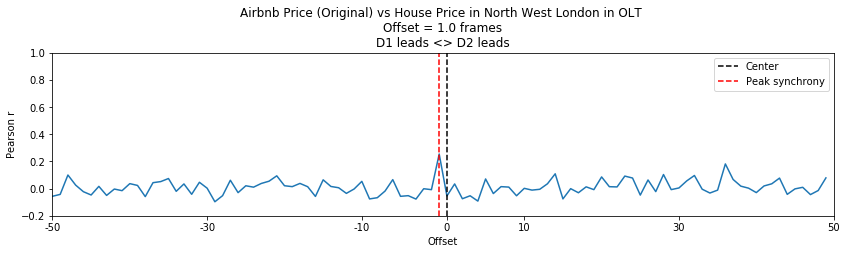

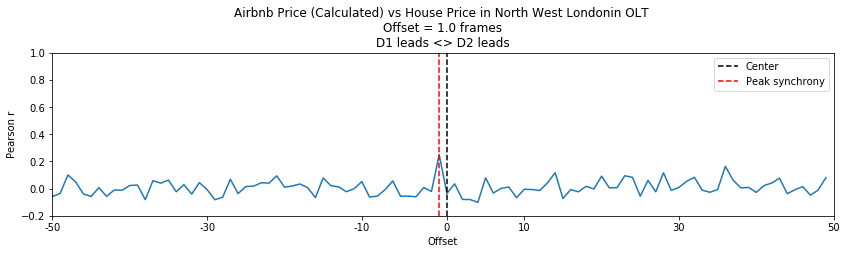

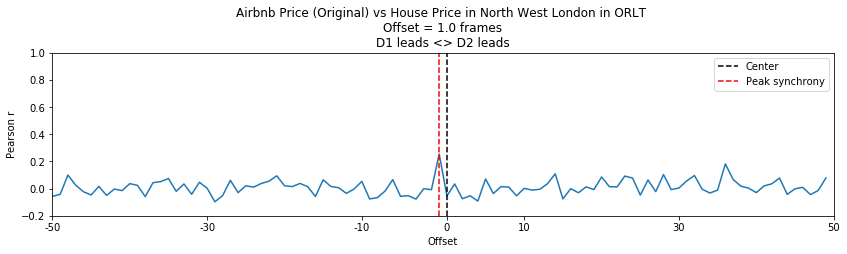

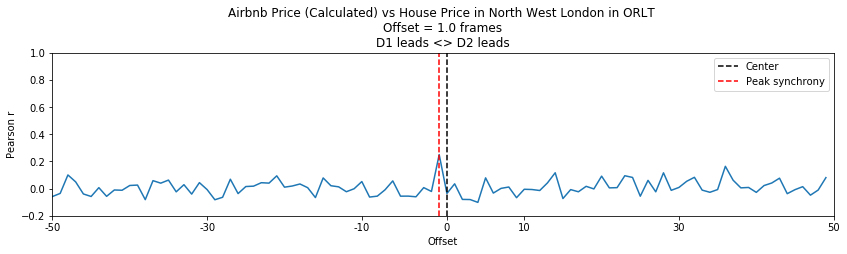

In [129]:
nw1 = NW_merged_with_outlier['log_Price_airbnb_original']
nw2 = NW_merged_with_outlier['log_Price_airbnb_cal']
nw3 = NW_merged_with_outlier['log_Price_house']

years  = 1
fps    = 50

nw_rs     = [crosscorr(nw1,nw3,lag) for lag in range(-int(years*fps),int(years*fps+1))]
nw_offset = np.ceil(len(nw_rs)/2)-np.argmax(nw_rs)

f,ax = plt.subplots(figsize=(14,3))
ax.plot(nw_rs)
ax.axvline(np.ceil(len(nw_rs)/2),color='k',linestyle='--',label='Center')
ax.axvline(np.argmax(nw_rs),color='r',linestyle='--',label='Peak synchrony')
ax.set(title=f'Airbnb Price (Original) vs House Price in North West London in OLT \nOffset = {nw_offset} frames\nD1 leads <> D2 leads',
       ylim=[-.2,1],xlim=[0,101],xlabel='Offset',ylabel='Pearson r')
ax.set_xticks([0, 20, 40, 51, 61, 81, 101])
ax.set_xticklabels([-50, -30, -10, 0, 10, 30, 50]);
plt.legend()
plt.show()

nw_rs1     = [crosscorr(nw2,nw3,lag) for lag in range(-int(years*fps),int(years*fps+1))]
nw_offset1 = np.ceil(len(nw_rs1)/2)-np.argmax(nw_rs1)

f,ax = plt.subplots(figsize=(14,3))
ax.plot(nw_rs1)
ax.axvline(np.ceil(len(nw_rs1)/2),color='k',linestyle='--',label='Center')
ax.axvline(np.argmax(nw_rs1),color='r',linestyle='--',label='Peak synchrony')
ax.set(title=f'Airbnb Price (Calculated) vs House Price in North West Londonin OLT \nOffset = {nw_offset1} frames\nD1 leads <> D2 leads',
       ylim=[-.2,1],xlim=[0,101],xlabel='Offset',ylabel='Pearson r')
ax.set_xticks([0, 20, 40, 51, 61, 81, 101])
ax.set_xticklabels([-50, -30, -10, 0, 10, 30, 50]);
plt.legend()
plt.show()

nw5 = North_West_merged['log_Price_airbnb_original']
nw6 = North_West_merged['log_Price_airbnb_cal']
nw7 = North_West_merged['log_Price_house']

years  = 1
fps    = 50

nw_rs5     = [crosscorr(nw5,nw7,lag) for lag in range(-int(years*fps),int(years*fps+1))]
nw_offset5 = np.ceil(len(nw_rs5)/2)-np.argmax(nw_rs5)

f,ax = plt.subplots(figsize=(14,3))
ax.plot(nw_rs5)
ax.axvline(np.ceil(len(nw_rs5)/2),color='k',linestyle='--',label='Center')
ax.axvline(np.argmax(nw_rs5),color='r',linestyle='--',label='Peak synchrony')
ax.set(title=f'Airbnb Price (Original) vs House Price in North West London in ORLT \nOffset = {nw_offset5} frames\nD1 leads <> D2 leads',
       ylim=[-.2,1],xlim=[0,101],xlabel='Offset',ylabel='Pearson r')
ax.set_xticks([0, 20, 40, 51, 61, 81, 101])
ax.set_xticklabels([-50, -30, -10, 0, 10, 30, 50]);
plt.legend()
plt.show()

nw_rs6     = [crosscorr(nw6,nw7,lag) for lag in range(-int(years*fps),int(years*fps+1))]
nw_offset6 = np.ceil(len(nw_rs6)/2)-np.argmax(nw_rs6)

f,ax = plt.subplots(figsize=(14,3))
ax.plot(nw_rs6)
ax.axvline(np.ceil(len(nw_rs6)/2),color='k',linestyle='--',label='Center')
ax.axvline(np.argmax(nw_rs6),color='r',linestyle='--',label='Peak synchrony')
ax.set(title=f'Airbnb Price (Calculated) vs House Price in North West London in ORLT \nOffset = {nw_offset6} frames\nD1 leads <> D2 leads',
       ylim=[-.2,1],xlim=[0,101],xlabel='Offset',ylabel='Pearson r')
ax.set_xticks([0, 20, 40, 51, 61, 81, 101])
ax.set_xticklabels([-50, -30, -10, 0, 10, 30, 50]);
plt.legend()
plt.show()

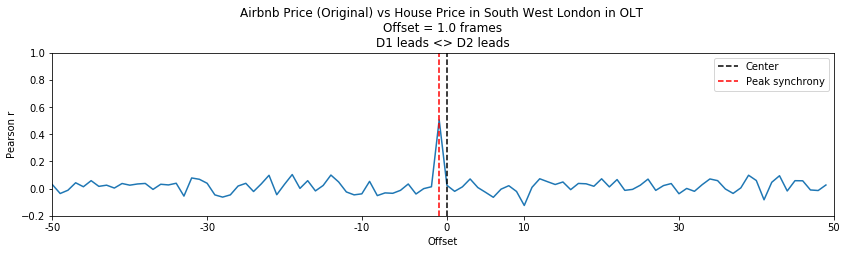

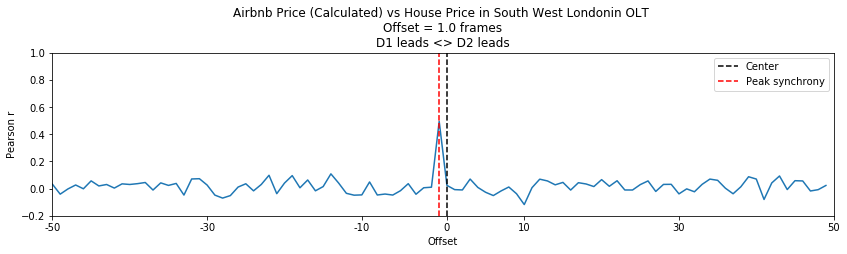

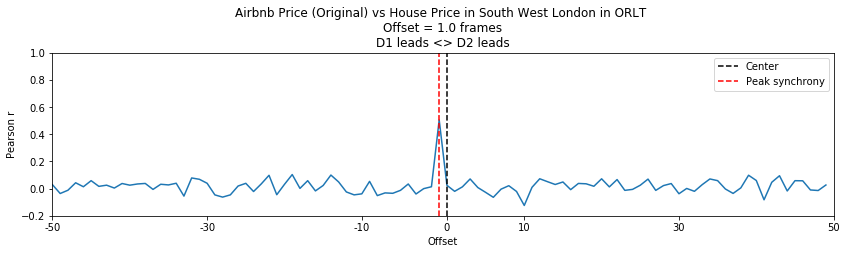

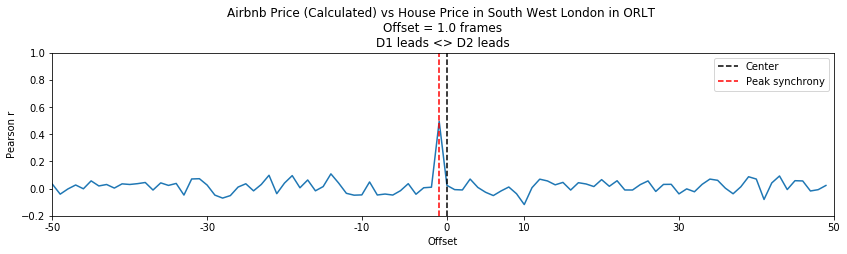

In [130]:
sw1 = SW_merged_with_outlier['log_Price_airbnb_original']
sw2 = SW_merged_with_outlier['log_Price_airbnb_cal']
sw3 = SW_merged_with_outlier['log_Price_house']

years  = 1
fps    = 50

sw_rs     = [crosscorr(sw1,sw3,lag) for lag in range(-int(years*fps),int(years*fps+1))]
sw_offset = np.ceil(len(sw_rs)/2)-np.argmax(sw_rs)

f,ax = plt.subplots(figsize=(14,3))
ax.plot(sw_rs)
ax.axvline(np.ceil(len(sw_rs)/2),color='k',linestyle='--',label='Center')
ax.axvline(np.argmax(sw_rs),color='r',linestyle='--',label='Peak synchrony')
ax.set(title=f'Airbnb Price (Original) vs House Price in South West London in OLT \nOffset = {sw_offset} frames\nD1 leads <> D2 leads',
       ylim=[-.2,1],xlim=[0,101],xlabel='Offset',ylabel='Pearson r')
ax.set_xticks([0, 20, 40, 51, 61, 81, 101])
ax.set_xticklabels([-50, -30, -10, 0, 10, 30, 50]);
plt.legend()
plt.show()

sw_rs1     = [crosscorr(sw2,sw3,lag) for lag in range(-int(years*fps),int(years*fps+1))]
sw_offset1 = np.ceil(len(sw_rs1)/2)-np.argmax(sw_rs1)

f,ax = plt.subplots(figsize=(14,3))
ax.plot(sw_rs1)
ax.axvline(np.ceil(len(sw_rs1)/2),color='k',linestyle='--',label='Center')
ax.axvline(np.argmax(sw_rs1),color='r',linestyle='--',label='Peak synchrony')
ax.set(title=f'Airbnb Price (Calculated) vs House Price in South West Londonin OLT \nOffset = {sw_offset1} frames\nD1 leads <> D2 leads',
       ylim=[-.2,1],xlim=[0,101],xlabel='Offset',ylabel='Pearson r')
ax.set_xticks([0, 20, 40, 51, 61, 81, 101])
ax.set_xticklabels([-50, -30, -10, 0, 10, 30, 50]);
plt.legend()
plt.show()

sw5 = South_West_merged['log_Price_airbnb_original']
sw6 = South_West_merged['log_Price_airbnb_cal']
sw7 = South_West_merged['log_Price_house']

years  = 1
fps    = 50

sw_rs5     = [crosscorr(sw5,sw7,lag) for lag in range(-int(years*fps),int(years*fps+1))]
sw_offset5 = np.ceil(len(sw_rs5)/2)-np.argmax(sw_rs5)

f,ax = plt.subplots(figsize=(14,3))
ax.plot(sw_rs5)
ax.axvline(np.ceil(len(sw_rs5)/2),color='k',linestyle='--',label='Center')
ax.axvline(np.argmax(sw_rs5),color='r',linestyle='--',label='Peak synchrony')
ax.set(title=f'Airbnb Price (Original) vs House Price in South West London in ORLT \nOffset = {sw_offset5} frames\nD1 leads <> D2 leads',
       ylim=[-.2,1],xlim=[0,101],xlabel='Offset',ylabel='Pearson r')
ax.set_xticks([0, 20, 40, 51, 61, 81, 101])
ax.set_xticklabels([-50, -30, -10, 0, 10, 30, 50]);
plt.legend()
plt.show()

sw_rs6     = [crosscorr(sw6,sw7,lag) for lag in range(-int(years*fps),int(years*fps+1))]
sw_offset6 = np.ceil(len(sw_rs6)/2)-np.argmax(sw_rs6)

f,ax = plt.subplots(figsize=(14,3))
ax.plot(sw_rs6)
ax.axvline(np.ceil(len(sw_rs6)/2),color='k',linestyle='--',label='Center')
ax.axvline(np.argmax(sw_rs6),color='r',linestyle='--',label='Peak synchrony')
ax.set(title=f'Airbnb Price (Calculated) vs House Price in South West London in ORLT \nOffset = {sw_offset6} frames\nD1 leads <> D2 leads',
       ylim=[-.2,1],xlim=[0,101],xlabel='Offset',ylabel='Pearson r')
ax.set_xticks([0, 20, 40, 51, 61, 81, 101])
ax.set_xticklabels([-50, -30, -10, 0, 10, 30, 50]);
plt.legend()
plt.show()

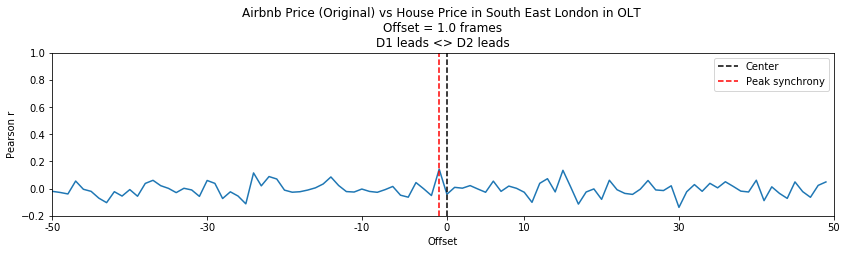

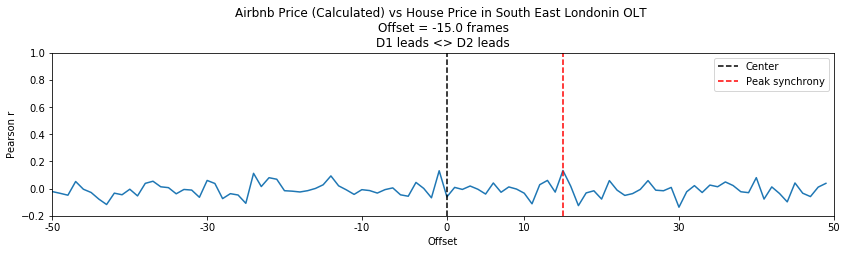

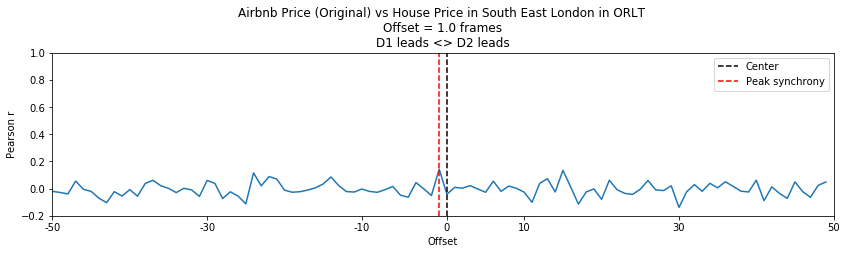

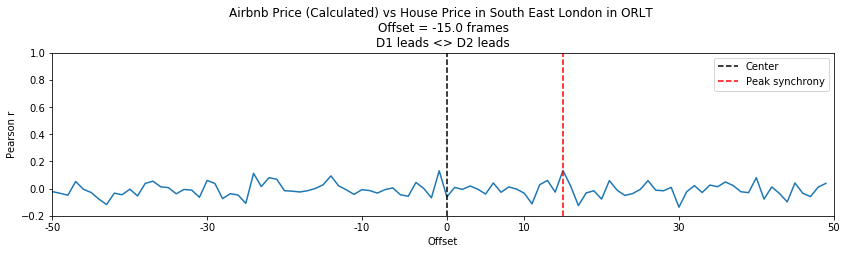

In [131]:
se1 = SE_merged_with_outlier['log_Price_airbnb_original']
se2 = SE_merged_with_outlier['log_Price_airbnb_cal']
se3 = SE_merged_with_outlier['log_Price_house']

years  = 1
fps    = 50

se_rs     = [crosscorr(se1,se3,lag) for lag in range(-int(years*fps),int(years*fps+1))]
se_offset = np.ceil(len(se_rs)/2)-np.argmax(se_rs)

f,ax = plt.subplots(figsize=(14,3))
ax.plot(se_rs)
ax.axvline(np.ceil(len(se_rs)/2),color='k',linestyle='--',label='Center')
ax.axvline(np.argmax(se_rs),color='r',linestyle='--',label='Peak synchrony')
ax.set(title=f'Airbnb Price (Original) vs House Price in South East London in OLT \nOffset = {se_offset} frames\nD1 leads <> D2 leads',
       ylim=[-.2,1],xlim=[0,101],xlabel='Offset',ylabel='Pearson r')
ax.set_xticks([0, 20, 40, 51, 61, 81, 101])
ax.set_xticklabels([-50, -30, -10, 0, 10, 30, 50]);
plt.legend()
plt.show()

se_rs1     = [crosscorr(se2,se3,lag) for lag in range(-int(years*fps),int(years*fps+1))]
se_offset1 = np.ceil(len(se_rs1)/2)-np.argmax(se_rs1)

f,ax = plt.subplots(figsize=(14,3))
ax.plot(se_rs1)
ax.axvline(np.ceil(len(se_rs1)/2),color='k',linestyle='--',label='Center')
ax.axvline(np.argmax(se_rs1),color='r',linestyle='--',label='Peak synchrony')
ax.set(title=f'Airbnb Price (Calculated) vs House Price in South East Londonin OLT \nOffset = {se_offset1} frames\nD1 leads <> D2 leads',
       ylim=[-.2,1],xlim=[0,101],xlabel='Offset',ylabel='Pearson r')
ax.set_xticks([0, 20, 40, 51, 61, 81, 101])
ax.set_xticklabels([-50, -30, -10, 0, 10, 30, 50]);
plt.legend()
plt.show()

se5 = South_East_merged['log_Price_airbnb_original']
se6 = South_East_merged['log_Price_airbnb_cal']
se7 = South_East_merged['log_Price_house']

years  = 1
fps    = 50

se_rs5     = [crosscorr(se5,se7,lag) for lag in range(-int(years*fps),int(years*fps+1))]
se_offset5 = np.ceil(len(se_rs5)/2)-np.argmax(se_rs5)

f,ax = plt.subplots(figsize=(14,3))
ax.plot(se_rs5)
ax.axvline(np.ceil(len(se_rs5)/2),color='k',linestyle='--',label='Center')
ax.axvline(np.argmax(se_rs5),color='r',linestyle='--',label='Peak synchrony')
ax.set(title=f'Airbnb Price (Original) vs House Price in South East London in ORLT \nOffset = {se_offset5} frames\nD1 leads <> D2 leads',
       ylim=[-.2,1],xlim=[0,101],xlabel='Offset',ylabel='Pearson r')
ax.set_xticks([0, 20, 40, 51, 61, 81, 101])
ax.set_xticklabels([-50, -30, -10, 0, 10, 30, 50]);
plt.legend()
plt.show()

se_rs6     = [crosscorr(se6,se7,lag) for lag in range(-int(years*fps),int(years*fps+1))]
se_offset6 = np.ceil(len(se_rs6)/2)-np.argmax(se_rs6)

f,ax = plt.subplots(figsize=(14,3))
ax.plot(se_rs6)
ax.axvline(np.ceil(len(se_rs6)/2),color='k',linestyle='--',label='Center')
ax.axvline(np.argmax(se_rs6),color='r',linestyle='--',label='Peak synchrony')
ax.set(title=f'Airbnb Price (Calculated) vs House Price in South East London in ORLT \nOffset = {se_offset6} frames\nD1 leads <> D2 leads',
       ylim=[-.2,1],xlim=[0,101],xlabel='Offset',ylabel='Pearson r')
ax.set_xticks([0, 20, 40, 51, 61, 81, 101])
ax.set_xticklabels([-50, -30, -10, 0, 10, 30, 50]);
plt.legend()
plt.show()

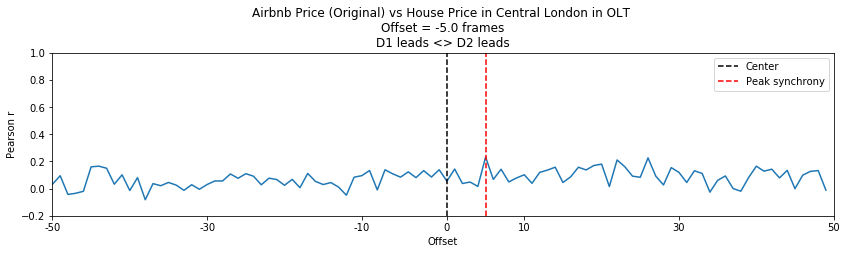

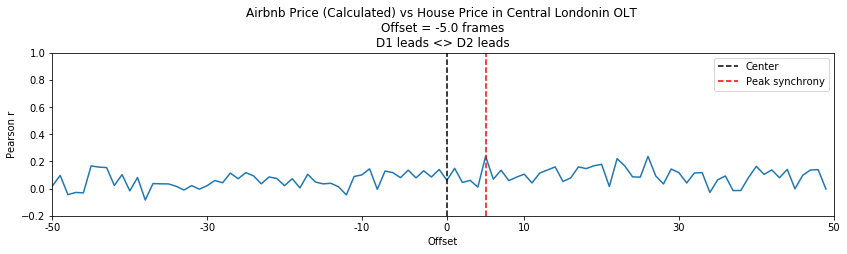

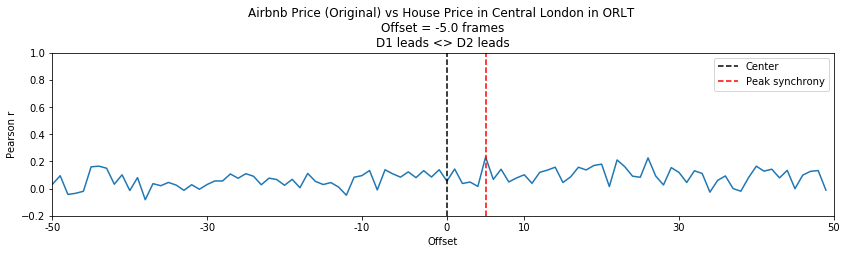

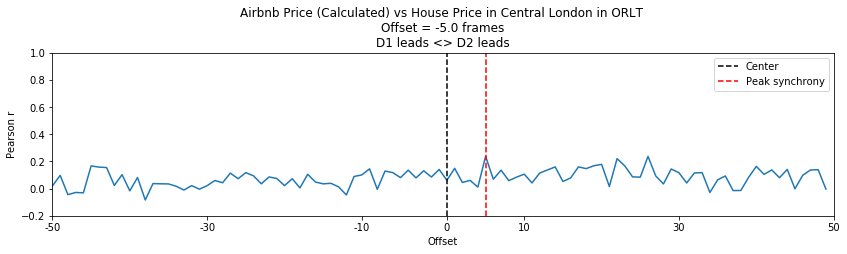

In [132]:
c1 = Central_merged_with_outlier['log_Price_airbnb_original']
c2 = Central_merged_with_outlier['log_Price_airbnb_cal']
c3 = Central_merged_with_outlier['log_Price_house']

years  = 1
fps    = 50

c_rs     = [crosscorr(c1,c3,lag) for lag in range(-int(years*fps),int(years*fps+1))]
c_offset = np.ceil(len(c_rs)/2)-np.argmax(c_rs)

f,ax = plt.subplots(figsize=(14,3))
ax.plot(c_rs)
ax.axvline(np.ceil(len(c_rs)/2),color='k',linestyle='--',label='Center')
ax.axvline(np.argmax(c_rs),color='r',linestyle='--',label='Peak synchrony')
ax.set(title=f'Airbnb Price (Original) vs House Price in Central London in OLT \nOffset = {c_offset} frames\nD1 leads <> D2 leads',
       ylim=[-.2,1],xlim=[0,101],xlabel='Offset',ylabel='Pearson r')
ax.set_xticks([0, 20, 40, 51, 61, 81, 101])
ax.set_xticklabels([-50, -30, -10, 0, 10, 30, 50]);
plt.legend()
plt.show()

c_rs1     = [crosscorr(c2,c3,lag) for lag in range(-int(years*fps),int(years*fps+1))]
c_offset1 = np.ceil(len(c_rs1)/2)-np.argmax(c_rs1)

f,ax = plt.subplots(figsize=(14,3))
ax.plot(c_rs1)
ax.axvline(np.ceil(len(c_rs1)/2),color='k',linestyle='--',label='Center')
ax.axvline(np.argmax(c_rs1),color='r',linestyle='--',label='Peak synchrony')
ax.set(title=f'Airbnb Price (Calculated) vs House Price in Central Londonin OLT \nOffset = {c_offset1} frames\nD1 leads <> D2 leads',
       ylim=[-.2,1],xlim=[0,101],xlabel='Offset',ylabel='Pearson r')
ax.set_xticks([0, 20, 40, 51, 61, 81, 101])
ax.set_xticklabels([-50, -30, -10, 0, 10, 30, 50]);
plt.legend()
plt.show()

c5 = Central_merged['log_Price_airbnb_original']
c6 = Central_merged['log_Price_airbnb_cal']
c7 = Central_merged['log_Price_house']

years  = 1
fps    = 50

c_rs5     = [crosscorr(c5,c7,lag) for lag in range(-int(years*fps),int(years*fps+1))]
c_offset5 = np.ceil(len(c_rs5)/2)-np.argmax(c_rs5)

f,ax = plt.subplots(figsize=(14,3))
ax.plot(c_rs5)
ax.axvline(np.ceil(len(c_rs5)/2),color='k',linestyle='--',label='Center')
ax.axvline(np.argmax(c_rs5),color='r',linestyle='--',label='Peak synchrony')
ax.set(title=f'Airbnb Price (Original) vs House Price in Central London in ORLT \nOffset = {c_offset5} frames\nD1 leads <> D2 leads',
       ylim=[-.2,1],xlim=[0,101],xlabel='Offset',ylabel='Pearson r')
ax.set_xticks([0, 20, 40, 51, 61, 81, 101])
ax.set_xticklabels([-50, -30, -10, 0, 10, 30, 50]);
plt.legend()
plt.show()

c_rs6     = [crosscorr(c6,c7,lag) for lag in range(-int(years*fps),int(years*fps+1))]
c_offset6 = np.ceil(len(c_rs6)/2)-np.argmax(c_rs6)

f,ax = plt.subplots(figsize=(14,3))
ax.plot(c_rs6)
ax.axvline(np.ceil(len(c_rs6)/2),color='k',linestyle='--',label='Center')
ax.axvline(np.argmax(c_rs6),color='r',linestyle='--',label='Peak synchrony')
ax.set(title=f'Airbnb Price (Calculated) vs House Price in Central London in ORLT \nOffset = {c_offset6} frames\nD1 leads <> D2 leads',
       ylim=[-.2,1],xlim=[0,101],xlabel='Offset',ylabel='Pearson r')
ax.set_xticks([0, 20, 40, 51, 61, 81, 101])
ax.set_xticklabels([-50, -30, -10, 0, 10, 30, 50]);
plt.legend()
plt.show()

As per the TLCC plots for each postcode districts, ALP is the leading interaction in most postcode districts except for Central London where HP leads by 5 frames in OLT and 25 frames in ORLT and leads by 15 frames for South East London with CALP in OLT. 

TLCC provided sufficient eveidence that ALP do indicated changes in HP. Combining with the results that there is a medium degree Pearson correlation, regression models will now be build.

# 9. Regression Models

    9.1 Simple linear regression model (SLRM)

       9.1.1 OLS 

In [134]:
#A simple linear regression will be build first using the most correlated column: OALP from OLT. 
#Set Postcode as the index for the dataframe to allow visualisation of each postcode district
merged2 = merged1.set_index('Postcode')
merged_with_outlier1 = merged_with_outlier.set_index('Postcode')

In [135]:
#Set depedent (X) and independent (y) variables
X = pd.DataFrame(merged_with_outlier1['log_Price_house'])
y = pd.DataFrame(merged_with_outlier1['log_Price_airbnb_original'])

In [136]:
#First try the simple linear regression model 
lm = sm.OLS(X,y).fit()
linear_predictions = lm.predict()

lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:        log_Price_house   R-squared (uncentered):                   0.996
Model:                            OLS   Adj. R-squared (uncentered):              0.996
Method:                 Least Squares   F-statistic:                          9.821e+05
Date:                Sun, 15 Dec 2019   Prob (F-statistic):                        0.00
Time:                        08:54:45   Log-Likelihood:                         -5156.1
No. Observations:                4015   AIC:                                  1.031e+04
Df Residuals:                    4014   BIC:                                  1.032e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
log_Price_airbnb_original     1.3913      0.001    990.993      0.000       1.389       1.394
==============================================================================
Omnibus:                      432.439   Durbin-Watson:                   1.934
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3825.115
Skew:                          -0.025   Prob(JB):                         0.00
Kurtosis:                       7.781   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The model has obtained a very high r-squared value of 99.6%.

log_Price_airbnb_original    1.39134
dtype: float64


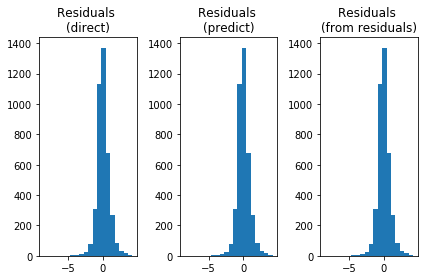

In [137]:
print(lm.params)

#Calculating dependent variable values from parameters directly
Dep_value  = merged_with_outlier1['log_Price_airbnb_original']*lm.params['log_Price_airbnb_original']
Dep_value_predict = linear_predictions

#Calculate the residuals 3 ways
residuals_direct  = merged_with_outlier1['log_Price_house']-Dep_value
residuals_predict = merged_with_outlier1['log_Price_house']-Dep_value_predict
residuals_fromlib = lm.resid

f, ax = plt.subplots(1, 3)
ax[0].set_title("Residuals \n(direct)")
ax[0].hist(residuals_direct,20)
ax[1].set_title("Residuals \n(predict)")
ax[1].hist(residuals_predict,20)
ax[2].set_title("Residuals \n(from residuals)")
ax[2].hist(residuals_fromlib,20)
plt.tight_layout()

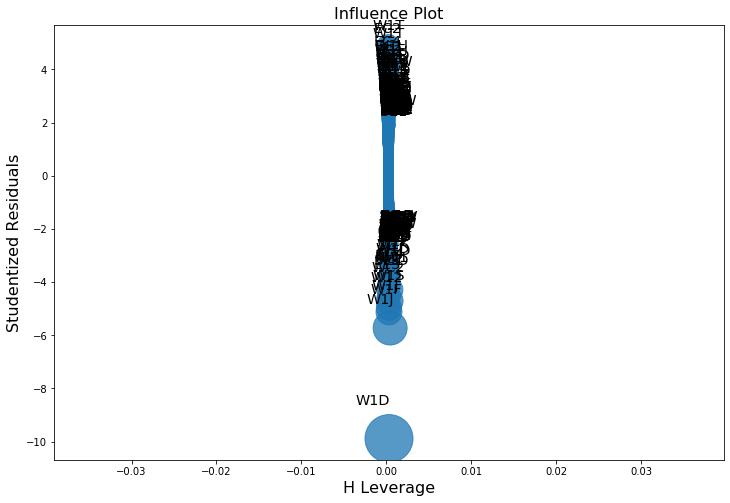

In [138]:
f,ax = plt.subplots(figsize=(12,8))
f = sm.graphics.influence_plot(lm,ax=ax,criterion='cooks')

The influence plot confirmed that the residual values are ranging between -5 and 5, and all have 0 leverage. One exception is datapoints in W1D have the most residuals. 

In [139]:
print("R-squared:",lm.rsquared)
print("MSE model:",lm.mse_model)
print("MSE residuals:",lm.mse_resid)
print("MSE total:",lm.mse_total)

R-squared: 0.9959293407153885
MSE model: 750267.0218020347
MSE residuals: 0.7639672040128415
MSE total: 187.62978484656094


The standard measures showed why the R-Squared value is so high. Both MSE and MSE residuals are extremly high, but still gives a good indication that at least some varation of the data were described.  

In [184]:
#Drop the outliers in W1D
Xa = X.drop('W1D')
ya = y.drop('W1D')

lm_a = sm.OLS(Xa,ya).fit()
linear_predictions_a = lm_a.predict()

lm_a.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:        log_Price_house   R-squared (uncentered):                   0.996
Model:                            OLS   Adj. R-squared (uncentered):              0.996
Method:                 Least Squares   F-statistic:                          1.021e+06
Date:                Sun, 15 Dec 2019   Prob (F-statistic):                        0.00
Time:                        09:23:18   Log-Likelihood:                         -5032.8
No. Observations:                3989   AIC:                                  1.007e+04
Df Residuals:                    3988   BIC:                                  1.007e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
log_Price_airbnb_original     1.3922      0.001   1010.317      0.000       1.389       1.395
==============================================================================
Omnibus:                      297.845   Durbin-Watson:                   1.928
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1286.201
Skew:                           0.235   Prob(JB):                    5.07e-280
Kurtosis:                       5.742   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [186]:
print(lm_a.params)

print("R-squared:",lm_a.rsquared)
print("MSE model:",lm_a.mse_model)
print("MSE residuals:",lm_a.mse_resid)
print("MSE total:",lm_a.mse_total)

log_Price_airbnb_original    1.392173
dtype: float64
R-squared: 0.9961082399810166
MSE model: 745468.0023343414
MSE residuals: 0.7303203073300515
MSE total: 187.61106034594476


By removing W1D didn't improve the model, this is due to it has 0 leverage meaning it has small potential influence on the model 

       9.1.2 10-fold

In [140]:
#10-fold cross-validation linear regression model 
model  = linear_model.LinearRegression()
scores = []
rmse   = []
kfold  = KFold(n_splits=10,shuffle=True,random_state=42)

for i ,(train,test) in enumerate(kfold.split(X,y)):
    model.fit(X.iloc[train,:],y.iloc[train,:])
    prediction = model.predict(X.iloc[test,:])
    score = r2_score(y.iloc[test,:],prediction)
    scores.append(score)
    test_rmse = (np.sqrt(mean_squared_error(y.iloc[test,:],prediction)))
    rmse.append(test_rmse)
    
print(scores)
print(sum(scores)/len(scores))
print(rmse)
print(sum(rmse)/len(rmse))

[0.2062744626985339, 0.18314684343248067, 0.14176608939387136, 0.24631875000143022, 0.14115189314017873, 0.21444196893359502, 0.20509572960563294, 0.14328819581435592, 0.167438701051011, 0.21679235769344063]
0.18657149917645305
[0.526053190927853, 0.5708707964886861, 0.5889146149670816, 0.49801751316617315, 0.5407711162351718, 0.5314205631147434, 0.5552967387317511, 0.5456454189300506, 0.558685377282473, 0.5507695607532539]
0.5466444890597237


A 10-fold cross-validated SLRM showed the R-squared value is only approximately 19% with RMSE approximately 0.55. Meaning the fit is low but it is a good fit.

    9.2 Multiple linear regression model (MLRM)

       9.2.1 OLS

In [156]:
#A MLRM will be build using both OALP and CALP and see if results will improve. 
#Set depedent (X) and independent (y) variables
X1 = merged_with_outlier1['log_Price_house'];
y1 = sm.add_constant(merged_with_outlier1[['log_Price_airbnb_original','log_Price_airbnb_cal']])

In [157]:
lm1 = sm.OLS(X1,y1).fit()
linear_predictions1 = lm1.predict()

lm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        log_Price_house   R-squared:                       0.188
Model:                            OLS   Adj. R-squared:                  0.188
Method:                 Least Squares   F-statistic:                     464.2
Date:                Sun, 15 Dec 2019   Prob (F-statistic):          4.64e-182
Time:                        09:09:47   Log-Likelihood:                -4356.1
No. Observations:                4015   AIC:                             8718.
Df Residuals:                    4012   BIC:                             8737.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         8.1306      0.188     43.298      0.000       7.762       8.499
log_Price_airbnb_original     0.6158      0.101      6.120      0.000       0.419       0.813
log_Price_airbnb_cal         -0.0491      0.100     -0.489      0.625      -0.246       0.148
==============================================================================
Omnibus:                     1336.452   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13952.719
Skew:                           1.279   Prob(JB):                         0.00
Kurtosis:                      11.767   Cond. No.                         238.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

MLRM now achived R-squared values of 18.8%. However, as the variables interact with MLRM, each variable needs to be interpret accordingly. 

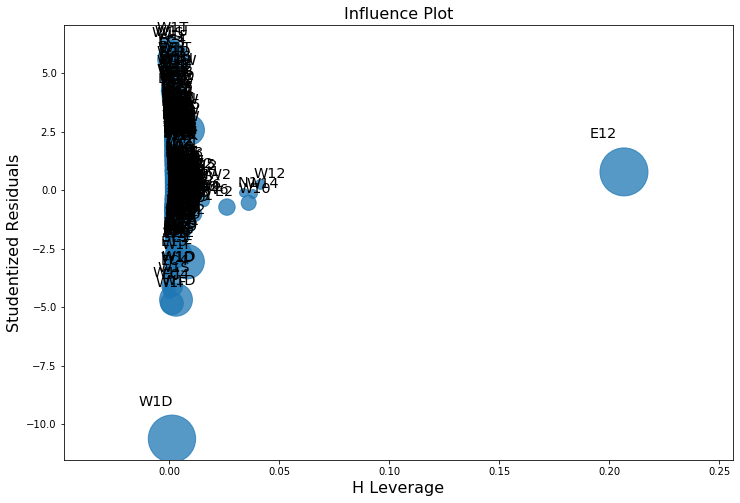

In [158]:
f,ax = plt.subplots(figsize=(12,8))
f = sm.graphics.influence_plot(lm1,ax=ax,criterion='cooks')

The influence plot showed that almost all of the datapoints have 0 leverage, and reisual values in the range of -5 and 5 except for datapoints in W1D and E12. 

const                        8.130574
log_Price_airbnb_original    0.615799
log_Price_airbnb_cal        -0.049051
dtype: float64


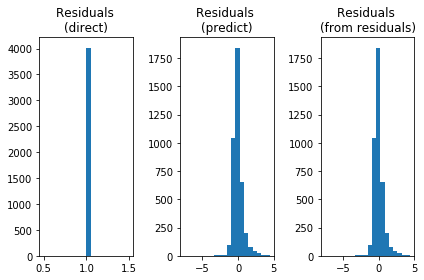

In [160]:
print(lm1.params)

#Calculating dependent variable values from parameters directly
Dep_value1  = merged_with_outlier1['log_Price_airbnb_original']*lm1.params['log_Price_airbnb_original']+merged_with_outlier1['log_Price_airbnb_cal']*lm1.params['log_Price_airbnb_cal']+lm1.params['const']
Dep_value_predict1 = linear_predictions1

#Calculate the residuals 3 ways
residuals_direct1  = merged_with_outlier1['log_Price_house']-Dep_value1
residuals_predict1 = merged_with_outlier1['log_Price_house']-Dep_value_predict1
residuals_fromlib1 = lm1.resid

f, ax = plt.subplots(1, 3)
ax[0].set_title("Residuals \n(direct)")
ax[0].hist(np.isfinite(residuals_direct1),20)
ax[1].set_title("Residuals \n(predict)")
ax[1].hist(residuals_predict1,20)
ax[2].set_title("Residuals \n(from residuals)")
ax[2].hist(residuals_fromlib1,20)
plt.tight_layout()

The residual histograms for the direct residuals calculated from parameters are not normalised, whilst the other two showed promising results ranging between -5 and 5. 

In [161]:
residuals_direct_mean  = residuals_direct1.mean()
residuals_predict_mean = residuals_predict1.mean()
residuals_fromlib_mean = residuals_fromlib1.mean()

print(residuals_direct_mean,residuals_predict_mean,residuals_fromlib_mean)

residuals_direct_sum  = residuals_direct1.sum()
residuals_predict_sum = residuals_predict1.sum()
residuals_fromlib_sum = residuals_fromlib1.sum()

print(residuals_direct_sum,residuals_predict_sum,residuals_fromlib_sum)

2.885971522642051e-15 2.9284448119527418e-15 2.9284448119527418e-15
1.1716849712684052e-11 1.1883827255587676e-11 1.1883827255587676e-11


In [162]:
#create instance of influence
influence = lm1.get_influence()

#leverage (hat values)
leverage = influence.hat_matrix_diag

#Cook's D values (and p-values) as tuple of arrays
cooks_d = influence.cooks_distance

#standardized residuals
studentised_residuals_int = influence.resid_studentized_internal

#studentized residuals
studentised_residuals_ext = influence.resid_studentized_external

print(studentised_residuals_int.mean(),studentised_residuals_int.sum(),studentised_residuals_ext.mean(),studentised_residuals_ext.sum())

1.974944522844004e-05 0.07929402259218676 0.00017897132692689923 0.7185698776115004


A closer look at the residuals showed that there are still still outliers in the dataset which influenced the result. 

Text(0.5, 1.0, 'Regression plot of the Multiple Linear Regression Model')

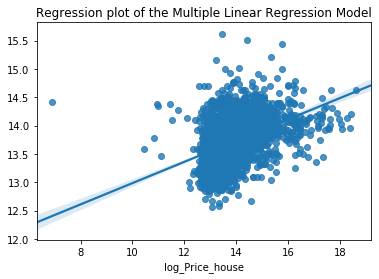

In [189]:
#Plot the regression plot 
sns.regplot(x=X1,y=linear_predictions1)
plt.title('Regression plot of the Multiple Linear Regression Model')

Text(0.5, 1.0, 'Residual Plot of the Multiple Linear Regression Model')

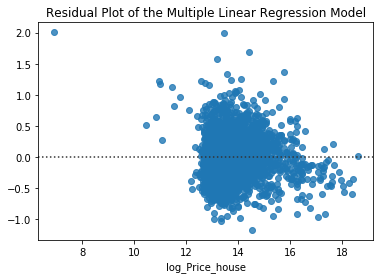

In [164]:
#Plot the residual plot 
sns.residplot(X1,linear_predictions1)
plt.title('Residual Plot of the Multiple Linear Regression Model')

Both regression and residual plot confirmed that there are still some outliers with modelled and actual HP. 

In [165]:
#Apply exponential transform the the price house to allow interpretaion
exp_linear_predictions1 = np.expm1(linear_predictions1)

Text(0.5, 1.0, 'Regression plot of the Multiple Linear Regression Model \n with Reverse Log Transformation')

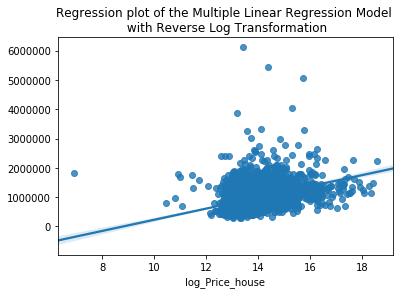

In [166]:
#Plot the regression plot with exponential transformed house price
sns.regplot(x=X1,y=exp_linear_predictions1)
plt.title('Regression plot of the Multiple Linear Regression Model \n with Reverse Log Transformation')

In [167]:
print("R-squared:",lm1.rsquared)
print("MSE model:",lm1.mse_model)
print("MSE residuals:",lm1.mse_resid)
print("MSE total:",lm1.mse_total)

R-squared: 0.18790914623454036
MSE model: 238.1858882360234
MSE residuals: 0.5131470050905691
MSE total: 0.6315688990770827


The results have improved.

In [190]:
#Drop the outliers of E12 which has more leverage than W1D
X1 = merged_with_outlier1['log_Price_house'];
y1 = sm.add_constant(merged_with_outlier1[['log_Price_airbnb_original','log_Price_airbnb_cal']])

Xb = X1.drop('E12')
yb = y1.drop('E12')

lm_b = sm.OLS(Xb,yb).fit()
linear_predictions_b = lm_b.predict()

lm_b.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        log_Price_house   R-squared:                       0.187
Model:                            OLS   Adj. R-squared:                  0.187
Method:                 Least Squares   F-statistic:                     459.2
Date:                Sun, 15 Dec 2019   Prob (F-statistic):          3.35e-180
Time:                        09:26:29   Log-Likelihood:                -4332.0
No. Observations:                3991   AIC:                             8670.
Df Residuals:                    3988   BIC:                             8689.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         8.1482      0.189     43.109      0.000       7.778       8.519
log_Price_airbnb_original     0.6566      0.113      5.810      0.000       0.435       0.878
log_Price_airbnb_cal         -0.0902      0.113     -0.800      0.423      -0.311       0.131
==============================================================================
Omnibus:                     1329.515   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13928.323
Skew:                           1.279   Prob(JB):                         0.00
Kurtosis:                      11.787   Cond. No.                         241.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [191]:
print("R-squared:",lm_b.rsquared)
print("MSE model:",lm_b.mse_model)
print("MSE residuals:",lm_b.mse_resid)
print("MSE total:",lm_b.mse_total)

R-squared: 0.18718394078881107
MSE model: 235.85980988845267
MSE residuals: 0.5136324807049347
MSE total: 0.6316004894306227


Again, dropping E12 didnt't improve the model, this is because although E12 has high leverage but has 0 residual values. 

    9.2.2 10-fold

In [168]:
#10-fold cross-validated mulitple regression model 
X1 = np.asarray(merged_with_outlier1['log_Price_house']).reshape(-1,1)
y1 = sm.add_constant(merged_with_outlier1[['log_Price_airbnb_original','log_Price_airbnb_cal']])

model1  = linear_model.LinearRegression()
scores1 = []
rmse1   = []
kfold  = KFold(n_splits=10,shuffle=True,random_state=42)

for i ,(train,test) in enumerate(kfold.split(X1,y1)):
    model1.fit(X1[train,:],y1.iloc[train,:])
    prediction1 = model1.predict(X1[test,:])
    score1 = r2_score(y1.iloc[test,:],prediction1)
    scores1.append(score1)
    test_rmse1 = (np.sqrt(mean_squared_error(y1.iloc[test,:],prediction1)))
    rmse1.append(test_rmse1)
    
print(scores1)
print(sum(scores1)/len(scores1))
print(rmse1)
print(sum(rmse1)/len(rmse1))

[0.4701255934744038, 0.45176255838109425, 0.42417630326097244, 0.49081197743601773, 0.4289895724232788, 0.47139180985184587, 0.4694997458421928, 0.42708681599960235, 0.4428816973836507, 0.4745713552939286]
0.45512974293469866
[0.4290568221784512, 0.46878386553951856, 0.4840611888761712, 0.4112256171061676, 0.4396484088112519, 0.4379811941627804, 0.45522331803550053, 0.4447425687873006, 0.4562428082775231, 0.45264453148600203]
0.44796103232606665


Results from a 10-fold cross-validated MLRM has increased to 45.5% with RMSE 0.448. It can be concluded that it is a reasonable model as it is higher than the threshold of 15%. 

    SLRM and MLRM with ORLT.

In [172]:
#Set dependent (X) and independent (y) variables
X2 = merged2['log_Price_house'];
y2 = sm.add_constant(merged2[['log_Price_airbnb_original','log_Price_airbnb_cal']])

In [173]:
lm2 = sm.OLS(X2,y2).fit()
linear_predictions2 = lm2.predict()

lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        log_Price_house   R-squared:                       0.183
Model:                            OLS   Adj. R-squared:                  0.183
Method:                 Least Squares   F-statistic:                     398.2
Date:                Sun, 15 Dec 2019   Prob (F-statistic):          9.90e-157
Time:                        09:17:23   Log-Likelihood:                -2476.5
No. Observations:                3552   AIC:                             4959.
Df Residuals:                    3549   BIC:                             4977.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         8.8814      0.171     51.987      0.000       8.546       9.216
log_Price_airbnb_original     0.4705      0.088      5.349      0.000       0.298       0.643
log_Price_airbnb_cal          0.0081      0.088      0.092      0.927      -0.165       0.181
==============================================================================
Omnibus:                      266.800   Durbin-Watson:                   1.950
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              340.957
Skew:                           0.676   Prob(JB):                     9.17e-75
Kurtosis:                       3.689   Cond. No.                         299.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Using ORLT sub-dataframe, there is little difference compare to OLT (ORLT: 18.3% OLT:18.8%). OALP remanied the feature influence house price the most.

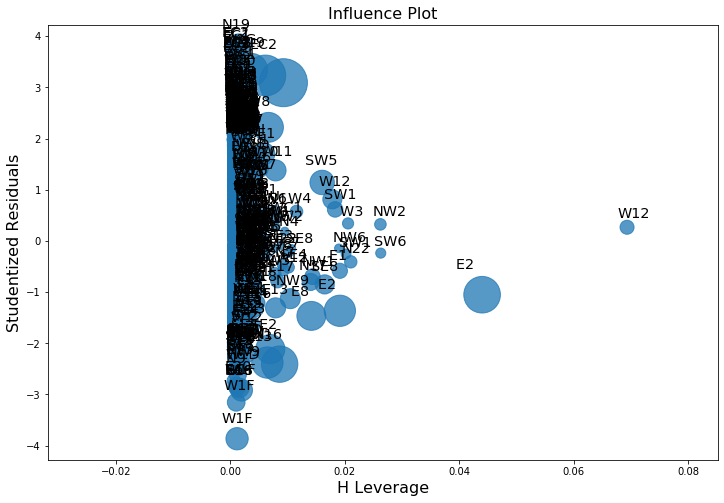

In [174]:
f,ax = plt.subplots(figsize=(12,8))
f = sm.graphics.influence_plot(lm2,ax=ax,criterion='cooks')

The influence plot showed that there are more outliers gaining more leverage, especially with E2 and W12. Judging by the inlfluence plot and as shown before, removing E2 and W12 would not alter model results as both the leverage and residual values are still low. 

const                        8.881406
log_Price_airbnb_original    0.470526
log_Price_airbnb_cal         0.008081
dtype: float64


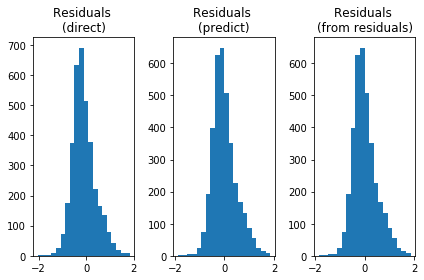

In [175]:
print(lm2.params)

#Calculating dependent variable values from parameters directly
Dep_value2  = merged2['log_Price_airbnb_original']*lm1.params['log_Price_airbnb_original']+merged2['log_Price_airbnb_cal']*lm1.params['log_Price_airbnb_cal']+lm1.params['const']
Dep_value_predict2 = linear_predictions2

#Calculate the residuals 3 ways
residuals_direct2  = merged2['log_Price_house']-Dep_value2
residuals_predict2 = merged2['log_Price_house']-Dep_value_predict2
residuals_fromlib2 = lm2.resid

f, ax = plt.subplots(1, 3)
ax[0].set_title("Residuals \n(direct)")
ax[0].hist(residuals_direct2,20)
ax[1].set_title("Residuals \n(predict)")
ax[1].hist(residuals_predict2,20)
ax[2].set_title("Residuals \n(from residuals)")
ax[2].hist(residuals_fromlib2,20)
plt.tight_layout()

The residuals look more promising than OLT sub-dataframes, with all three calculated residuals values normalised and ranging between -2 and 2. 

In [176]:
residuals_direct_mean1  = residuals_direct2.mean()
residuals_predict_mean1 = residuals_predict2.mean()
residuals_fromlib_mean1 = residuals_fromlib2.mean()

print(residuals_direct_mean1,residuals_predict_mean1,residuals_fromlib_mean1)

residuals_direct_sum1  = residuals_direct2.sum()
residuals_predict_sum1 = residuals_predict2.sum()
residuals_fromlib_sum1 = residuals_fromlib2.sum()

print(residuals_direct_sum1,residuals_predict_sum1,residuals_fromlib_sum1)

-0.09479802478218413 4.034810523727821e-15 4.034810523727821e-15
-336.72258402631877 1.4310330698208418e-11 1.4310330698208418e-11


In [177]:
#create instance of influence
influence1 = lm2.get_influence()

#leverage (hat values)
leverage1 = influence1.hat_matrix_diag

#Cook's D values (and p-values) as tuple of arrays
cooks_d1 = influence1.cooks_distance

#standardized residuals
studentised_residuals_int1 = influence1.resid_studentized_internal

#studentized residuals
studentised_residuals_ext1 = influence1.resid_studentized_external

print(studentised_residuals_int1.mean(),studentised_residuals_int1.sum(),studentised_residuals_ext1.mean(),studentised_residuals_ext1.sum())

6.365726564622949e-06 0.022611060757540713 0.00010176747828241053 0.3614780828591222


There are less outliers and the fit is better than OLT sub-dataframe.

Text(0.5, 1.0, 'Regression plot of the Multiple Linear Regression Model')

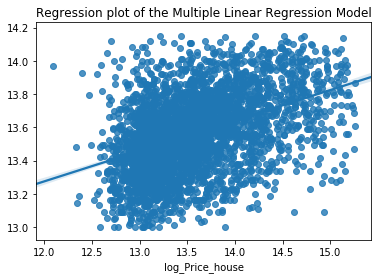

In [178]:
#Plot the regression plot
sns.regplot(x=X2,y=linear_predictions2)
plt.title('Regression plot of the Multiple Linear Regression Model')

Text(0.5, 1.0, 'Residual Plot of the Multiple Linear Regression Model')

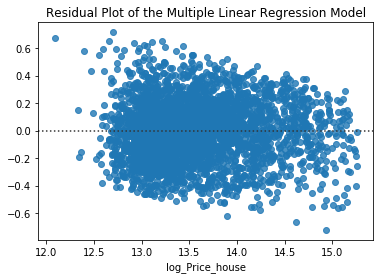

In [179]:
#Plot the residual plot
sns.residplot(X2,linear_predictions2)
plt.title('Residual Plot of the Multiple Linear Regression Model')

Both regression and residual plots confirmed that there are less outliers and better fit to the prediction. 

In [180]:
#Exponentially transform the house prices
exp_linear_predictions2 = np.expm1(linear_predictions2)

Text(0.5, 1.0, 'Regression plot of the Multiple Linear Regression Model \n with Reverse Log Transformation')

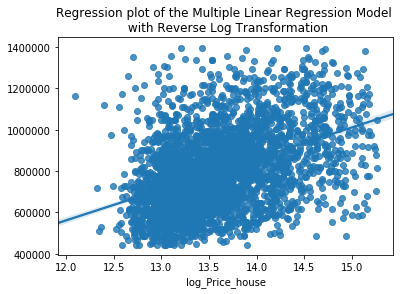

In [181]:
#Plot the regression plot with exponentially transformed house prices
sns.regplot(x=X2,y=exp_linear_predictions2)
plt.title('Regression plot of the Multiple Linear Regression Model \n with Reverse Log Transformation')

Exponential-transformed HP allow interpretation of variables better. Most outliers lie on the higher price brackets of house. 

In [182]:
print("R-squared:",lm2.rsquared)
print("MSE model:",lm2.mse_model)
print("MSE residuals:",lm2.mse_resid)
print("MSE total:",lm2.mse_total)

R-squared: 0.18325671995062254
MSE model: 94.08654309718742
MSE residuals: 0.23630731700061827
MSE total: 0.2891657995577497


Although there is little difference between the R-Squared values comparing with OLT and ORLT, but both MSE residuals and MSE decreased significanlly for ORLT. 

    9.2.2 10-fold

In [183]:
#10-fold cross-validated multiple regression model 
X2 = np.asarray(merged2['log_Price_house']).reshape(-1,1)
y2 = sm.add_constant(merged2[['log_Price_airbnb_original','log_Price_airbnb_cal']])

model2  = linear_model.LinearRegression()
scores = []
rmse   = []
kfold  = KFold(n_splits=10,shuffle=True,random_state=42)

for i ,(train,test) in enumerate(kfold.split(X2,y2)):
    model.fit(X2[train,:],y2.iloc[train,:])
    prediction = model.predict(X2[test,:])
    score = r2_score(y2.iloc[test,:],prediction)
    scores.append(score)
    test_rmse = (np.sqrt(mean_squared_error(y2.iloc[test,:],prediction)))
    rmse.append(test_rmse)
    
print(scores)
print(sum(scores)/len(scores))
print(rmse)
print(sum(rmse)/len(rmse))

[0.4477863601826546, 0.4415853622392573, 0.4185621438650678, 0.48432197278954936, 0.4441110530207775, 0.4374483924179801, 0.4763522942433985, 0.47356930764235566, 0.4264219968084448, 0.4698085142943181]
0.45199673975038035
[0.3680184072882624, 0.3623682353928171, 0.3658476376708255, 0.3406517222601987, 0.35187067080659684, 0.3483246210078903, 0.34918923488088277, 0.34965621529149604, 0.3702521146413625, 0.3495667482331101]
0.3555745607473442


It can concluded that OLT achieves slightly higher R-Squared value but ORLT can achieve similar score with less error.

    9.3 Mutliple linear regression model in all postcode districts

In [193]:
#Therefore, ORLT will be used to build regression models for each postcode districts
Xe = East_merged['log_Price_house']
ye = sm.add_constant(East_merged[['log_Price_airbnb_original','log_Price_airbnb_cal']])

lm_e = sm.OLS(Xe,ye).fit()
linear_predictions_e = lm_e.predict()

lm_e.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     16.03
Date:                Sun, 15 Dec 2019   Prob (F-statistic):           1.48e-07
Time:                        09:45:55   Log-Likelihood:                -421.71
No. Observations:                 826   AIC:                             849.4
Df Residuals:                     823   BIC:                             863.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        11.6764      0.282     41.334      0.000      11.122      12.231
log_Price_airbnb_original     0.1917      0.098      1.956      0.051      -0.001       0.384
log_Price_airbnb_cal         -0.0301      0.097     -0.309      0.757      -0.221       0.161
==============================================================================
Omnibus:                      458.959   Durbin-Watson:                   1.866
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5096.861
Skew:                           2.297   Prob(JB):                         0.00
Kurtosis:                      14.269   Cond. No.                         278.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [194]:
Xe = np.asarray(East_merged['log_Price_house']).reshape(-1,1)
ye = sm.add_constant(East_merged[['log_Price_airbnb_original','log_Price_airbnb_cal']])

model_e  = linear_model.LinearRegression()
scores_e = []
rmse_e   = []
kfold_e  = KFold(n_splits=10,shuffle=True,random_state=42)

for i ,(train,test) in enumerate(kfold.split(Xe,ye)):
    model_e.fit(Xe[train,:],ye.iloc[train,:])
    prediction_e = model_e.predict(Xe[test,:])
    score_e = r2_score(ye.iloc[test,:],prediction_e)
    scores_e.append(score_e)
    test_rmse_e = (np.sqrt(mean_squared_error(ye.iloc[test,:],prediction_e)))
    rmse_e.append(test_rmse_e)
    
print(sum(scores_e)/len(scores))
print(sum(rmse_e)/len(rmse))

0.3501958365550492
0.39248770944845857


In [195]:
exp_linear_predictions_e = np.expm1(linear_predictions_e)

Text(0.5, 1.0, 'Regression plot of the Multiple Linear Regression Model \n in East London')

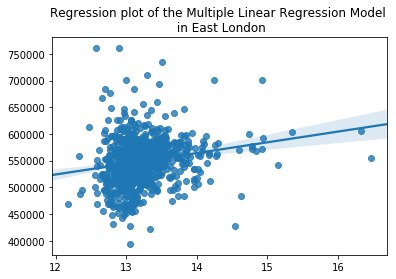

In [196]:
sns.regplot(x=Xe,y=exp_linear_predictions_e)
plt.title('Regression plot of the Multiple Linear Regression Model \n in East London')

In [198]:
Xn = North_merged['log_Price_house']
yn = sm.add_constant(North_merged[['log_Price_airbnb_original','log_Price_airbnb_cal']])

lm_n = sm.OLS(Xn,yn).fit()
linear_predictions_n = lm_n.predict()

lm_n.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        log_Price_house   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     16.33
Date:                Sun, 15 Dec 2019   Prob (F-statistic):           1.13e-07
Time:                        09:46:06   Log-Likelihood:                -388.80
No. Observations:                 776   AIC:                             783.6
Df Residuals:                     773   BIC:                             797.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        11.8746      0.269     44.153      0.000      11.347      12.403
log_Price_airbnb_original     0.0416      0.144      0.288      0.773      -0.242       0.325
log_Price_airbnb_cal          0.1152      0.143      0.808      0.420      -0.165       0.395
==============================================================================
Omnibus:                      170.003   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              411.185
Skew:                           1.148   Prob(JB):                     5.16e-90
Kurtosis:                       5.728   Cond. No.                         260.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [199]:
Xn = np.array(North_merged['log_Price_house']).reshape(-1,1)
yn = sm.add_constant(North_merged[['log_Price_airbnb_original','log_Price_airbnb_cal']])

model_n  = linear_model.LinearRegression()
scores_n = []
rmse_n   = []
kfold_n  = KFold(n_splits=10,shuffle=True,random_state=42)

for i ,(train,test) in enumerate(kfold_n.split(Xn,yn)):
    model_n.fit(Xn[train,:],yn.iloc[train,:])
    prediction_n = model_n.predict(Xn[test,:])
    score_n = r2_score(yn.iloc[test,:],prediction_n)
    scores_n.append(score_n)
    test_rmse_n = (np.sqrt(mean_squared_error(yn.iloc[test,:],prediction_n)))
    rmse_n.append(test_rmse_n)
    
print(sum(scores_n)/len(scores_n))
print(sum(rmse_n)/len(rmse_n))

0.35252193663073034
0.4183841197259399


In [200]:
exp_linear_predictions_n = np.expm1(linear_predictions_n)

Text(0.5, 1.0, 'Regression plot of the Multiple Linear Regression Model \n in North London')

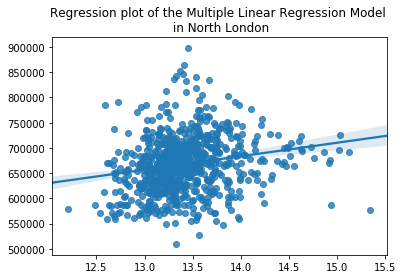

In [201]:
sns.regplot(x=Xn,y=exp_linear_predictions_n)
plt.title('Regression plot of the Multiple Linear Regression Model \n in North London')

In [203]:
Xc = Central_merged['log_Price_house'];
yc = sm.add_constant(Central_merged[['log_Price_airbnb_original','log_Price_airbnb_cal']])

lm_c = sm.OLS(Xc,yc).fit()
linear_predictions_c = lm_c.predict()

lm_c.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        log_Price_house   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     2.496
Date:                Sun, 15 Dec 2019   Prob (F-statistic):             0.0845
Time:                        09:46:16   Log-Likelihood:                -382.19
No. Observations:                 249   AIC:                             770.4
Df Residuals:                     246   BIC:                             780.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        11.5708      1.439      8.041      0.000       8.737      14.405
log_Price_airbnb_original    -0.1090      1.044     -0.104      0.917      -2.165       1.947
log_Price_airbnb_cal          0.4111      1.048      0.392      0.695      -1.653       2.475
==============================================================================
Omnibus:                        4.776   Durbin-Watson:                   1.844
Prob(Omnibus):                  0.092   Jarque-Bera (JB):                4.435
Skew:                           0.307   Prob(JB):                        0.109
Kurtosis:                       3.222   Cond. No.                         330.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [204]:
Xc = np.asarray(Central_merged['log_Price_house']).reshape(-1,1)
yc = sm.add_constant(Central_merged[['log_Price_airbnb_original','log_Price_airbnb_cal']])

model_c  = linear_model.LinearRegression()
scores_c = []
rmse_c   = []
kfold_c  = KFold(n_splits=10,shuffle=True,random_state=42)

for i ,(train,test) in enumerate(kfold_c.split(Xc,yc)):
    model_c.fit(Xc[train,:],yc.iloc[train,:])
    prediction_c = model_c.predict(Xc[test,:])
    score_c = r2_score(yc.iloc[test,:],prediction_c)
    scores_c.append(score_c)
    test_rmse_c = (np.sqrt(mean_squared_error(yc.iloc[test,:],prediction_c)))
    rmse_c.append(test_rmse_c)
    
print(sum(scores_c)/len(scores_c))
print(sum(rmse_c)/len(rmse_c))

0.24038823920927177
0.43048074475560527


In [205]:
exp_linear_predictions_c = np.expm1(linear_predictions_c)

Text(0.5, 1.0, 'Regression plot of the Multiple Linear Regression Model \n in Central London')

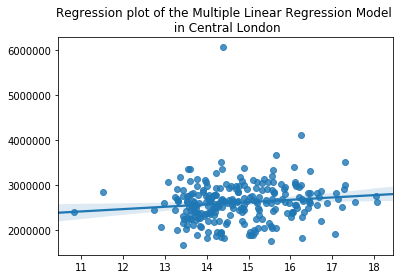

In [206]:
sns.regplot(x=Xc,y=exp_linear_predictions_c)
plt.title('Regression plot of the Multiple Linear Regression Model \n in Central London')

In [208]:
Xw = West_merged['log_Price_house'];
yw = sm.add_constant(West_merged[['log_Price_airbnb_original','log_Price_airbnb_cal']])

lm_w = sm.OLS(Xw,yw).fit()
linear_predictions_w = lm_w.predict()

lm_w.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        log_Price_house   R-squared:                       0.104
Model:                            OLS   Adj. R-squared:                  0.102
Method:                 Least Squares   F-statistic:                     47.60
Date:                Sun, 15 Dec 2019   Prob (F-statistic):           2.77e-20
Time:                        09:46:26   Log-Likelihood:                -1113.8
No. Observations:                 822   AIC:                             2234.
Df Residuals:                     819   BIC:                             2248.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         9.2614      0.524     17.689      0.000       8.234      10.289
log_Price_airbnb_original     0.6739      0.284      2.375      0.018       0.117       1.231
log_Price_airbnb_cal         -0.1861      0.283     -0.659      0.510      -0.741       0.368
==============================================================================
Omnibus:                      167.242   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2852.116
Skew:                           0.394   Prob(JB):                         0.00
Kurtosis:                      12.091   Cond. No.                         236.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [209]:
Xw = np.asarray(West_merged['log_Price_house']).reshape(-1,1)
yw = sm.add_constant(West_merged[['log_Price_airbnb_original','log_Price_airbnb_cal']])

model_w  = linear_model.LinearRegression()
scores_w = []
rmse_w   = []
kfold_w  = KFold(n_splits=10,shuffle=True,random_state=42)

for i ,(train,test) in enumerate(kfold_w.split(Xw,yw)):
    model_w.fit(Xw[train,:],yw.iloc[train,:])
    prediction_w = model_w.predict(Xw[test,:])
    score_w = r2_score(yw.iloc[test,:],prediction_w)
    scores_w.append(score_w)
    test_rmse_w = (np.sqrt(mean_squared_error(yw.iloc[test,:],prediction_w)))
    rmse_w.append(test_rmse_w)
    
print(sum(scores_w)/len(scores_w))
print(sum(rmse_w)/len(rmse_w))

0.3914787702694825
0.503892415493238


In [210]:
exp_linear_predictions_w = np.expm1(linear_predictions_w)

Text(0.5, 1.0, 'Regression plot of the Multiple Linear Regression Model \n in West London')

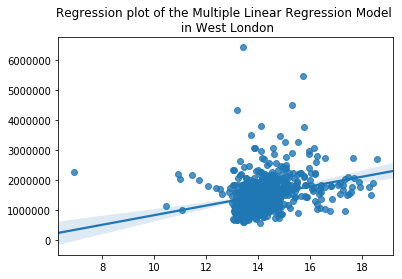

In [211]:
sns.regplot(x=Xw,y=exp_linear_predictions_w)
plt.title('Regression plot of the Multiple Linear Regression Model \n in West London')

In [213]:
Xnw = North_West_merged['log_Price_house'];
ynw = sm.add_constant(North_West_merged[['log_Price_airbnb_original','log_Price_airbnb_cal']])

lm_nw = sm.OLS(Xnw,ynw).fit()
linear_predictions_nw = lm_nw.predict()

lm_nw.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        log_Price_house   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     14.19
Date:                Sun, 15 Dec 2019   Prob (F-statistic):           1.10e-06
Time:                        09:46:36   Log-Likelihood:                -246.86
No. Observations:                 412   AIC:                             499.7
Df Residuals:                     409   BIC:                             511.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        11.5117      0.415     27.743      0.000      10.696      12.327
log_Price_airbnb_original     0.1959      0.203      0.967      0.334      -0.202       0.594
log_Price_airbnb_cal          0.0277      0.197      0.140      0.888      -0.360       0.415
==============================================================================
Omnibus:                       17.839   Durbin-Watson:                   1.964
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               19.415
Skew:                           0.468   Prob(JB):                     6.08e-05
Kurtosis:                       3.505   Cond. No.                         270.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [214]:
Xnw = np.asarray(North_West_merged['log_Price_house']).reshape(-1,1)
ynw = sm.add_constant(North_West_merged[['log_Price_airbnb_original','log_Price_airbnb_cal']])

model_nw  = linear_model.LinearRegression()
scores_nw = []
rmse_nw   = []
kfold_nw  = KFold(n_splits=10,shuffle=True,random_state=42)

for i ,(train,test) in enumerate(kfold_nw.split(Xnw,ynw)):
    model_nw.fit(Xnw[train,:],ynw.iloc[train,:])
    prediction_nw = model_nw.predict(Xnw[test,:])
    score_nw = r2_score(ynw.iloc[test,:],prediction_nw)
    scores_nw.append(score_nw)
    test_rmse_nw = (np.sqrt(mean_squared_error(ynw.iloc[test,:],prediction_nw)))
    rmse_nw.append(test_rmse_nw)
    
print(sum(scores_nw)/len(scores_nw))
print(sum(rmse_nw)/len(rmse_nw))

0.32864780152965684
0.40990321470476143


In [215]:
exp_linear_predictions_nw = np.expm1(linear_predictions_nw)

Text(0.5, 1.0, 'Regression plot of the Multiple Linear Regression Model \n in North West London')

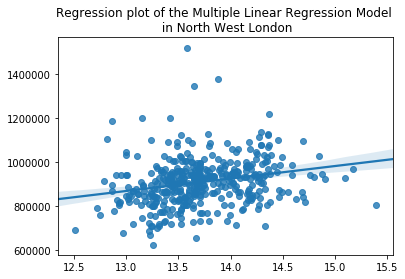

In [216]:
sns.regplot(x=Xnw,y=exp_linear_predictions_nw)
plt.title('Regression plot of the Multiple Linear Regression Model \n in North West London')

In [218]:
Xsw = South_West_merged['log_Price_house'];
ysw = sm.add_constant(South_West_merged[['log_Price_airbnb_original','log_Price_airbnb_cal']])

lm_sw = sm.OLS(Xsw,ysw).fit()
linear_predictions_sw = lm_sw.predict()

lm_sw.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        log_Price_house   R-squared:                       0.256
Model:                            OLS   Adj. R-squared:                  0.253
Method:                 Least Squares   F-statistic:                     89.76
Date:                Sun, 15 Dec 2019   Prob (F-statistic):           3.14e-34
Time:                        09:46:47   Log-Likelihood:                -372.23
No. Observations:                 525   AIC:                             750.5
Df Residuals:                     522   BIC:                             763.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         8.7320      0.398     21.924      0.000       7.950       9.514
log_Price_airbnb_original     0.5902      0.213      2.772      0.006       0.172       1.009
log_Price_airbnb_cal         -0.0756      0.213     -0.355      0.723      -0.494       0.343
==============================================================================
Omnibus:                       69.777   Durbin-Watson:                   2.084
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               99.915
Skew:                           0.915   Prob(JB):                     2.01e-22
Kurtosis:                       4.104   Cond. No.                         271.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [219]:
Xsw = np.asarray(South_West_merged['log_Price_house']).reshape(-1,1)
ysw = sm.add_constant(South_West_merged[['log_Price_airbnb_original','log_Price_airbnb_cal']])

model_sw  = linear_model.LinearRegression()
scores_sw = []
rmse_sw   = []
kfold_sw  = KFold(n_splits=10,shuffle=True,random_state=42)

for i ,(train,test) in enumerate(kfold_sw.split(Xsw,ysw)):
    model_sw.fit(Xsw[train,:],ysw.iloc[train,:])
    prediction_sw = model_sw.predict(Xsw[test,:])
    score_sw = r2_score(ysw.iloc[test,:],prediction_sw)
    scores_sw.append(score_sw)
    test_rmse_sw = (np.sqrt(mean_squared_error(ysw.iloc[test,:],prediction_sw)))
    rmse_sw.append(test_rmse_sw)
    
print(sum(scores_sw)/len(scores_sw))
print(sum(rmse_sw)/len(rmse_sw))

0.48331944958260886
0.3939689041734163


In [220]:
exp_linear_predictions_sw = np.expm1(linear_predictions_sw)

Text(0.5, 1.0, 'Regression plot of the Multiple Linear Regression Model \n in South West London')

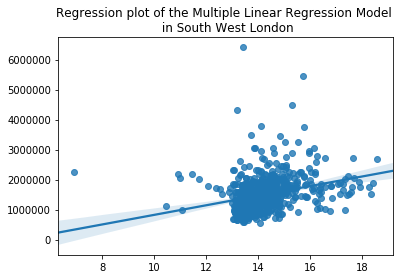

In [221]:
sns.regplot(x=Xw,y=exp_linear_predictions_w)
plt.title('Regression plot of the Multiple Linear Regression Model \n in South West London')

In [223]:
Xse = South_East_merged['log_Price_house'];
yse = sm.add_constant(South_East_merged[['log_Price_airbnb_original','log_Price_airbnb_cal']])

lm_se = sm.OLS(Xse,yse).fit()
linear_predictions_se = lm_se.predict()

lm_se.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        log_Price_house   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     4.767
Date:                Sun, 15 Dec 2019   Prob (F-statistic):            0.00900
Time:                        09:47:22   Log-Likelihood:                -131.37
No. Observations:                 403   AIC:                             268.7
Df Residuals:                     400   BIC:                             280.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        12.3296      0.344     35.883      0.000      11.654      13.005
log_Price_airbnb_original     0.3002      0.192      1.567      0.118      -0.076       0.677
log_Price_airbnb_cal         -0.2044      0.193     -1.061      0.289      -0.583       0.174
==============================================================================
Omnibus:                      275.256   Durbin-Watson:                   1.433
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3411.199
Skew:                           2.785   Prob(JB):                         0.00
Kurtosis:                      16.120   Cond. No.                         289.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [224]:
Xse = np.asarray(South_East_merged['log_Price_house']).reshape(-1,1)
yse = sm.add_constant(South_East_merged[['log_Price_airbnb_original','log_Price_airbnb_cal']])

model_se  = linear_model.LinearRegression()
scores_se = []
rmse_se   = []
kfold_se  = KFold(n_splits=10,shuffle=True,random_state=42)

for i ,(train,test) in enumerate(kfold_se.split(Xse,yse)):
    model_se.fit(Xse[train,:],yse.iloc[train,:])
    prediction_se = model_se.predict(Xse[test,:])
    score_se = r2_score(yse.iloc[test,:],prediction_se)
    scores_se.append(score_se)
    test_rmse_se = (np.sqrt(mean_squared_error(yse.iloc[test,:],prediction_se)))
    rmse_se.append(test_rmse_se)
    
print(sum(scores_se)/len(scores_se))
print(sum(rmse_se)/len(rmse_se))

0.3152838184296644
0.3919837557744806


In [225]:
exp_linear_predictions_se = np.expm1(linear_predictions_se)

Text(0.5, 1.0, 'Regression plot of the Multiple Linear Regression Model \n in South East London')

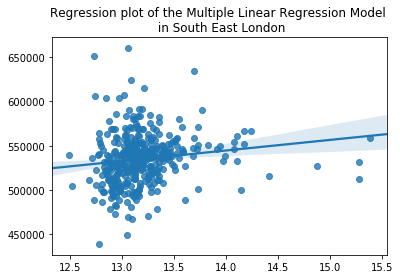

In [226]:
sns.regplot(x=Xse,y=exp_linear_predictions_se)
plt.title('Regression plot of the Multiple Linear Regression Model \n in South East London')

Both South West London obtained the highest R-Squared value with 23.8% for OLS and 46.4% of 10-fold cross-validation, follow by West London with 11.7% for OLS and 40.6% for 10-fold cross-validation. Meaning that ALP is most confident to predict HP in these areas but with only small accuracy.